# Plots for evaluation metrics and output from RNN models


In [534]:
%config IPCompleter.greedy=True # jupyter autocomplete

import datetime
import os
import random
import sys

import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.colors import ListedColormap

mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["black", "gray", "c"]) 
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd

from eval_util import *


## Geography

Census tracts are the geographical area unit.

We use 3 counties surrounding Boston, MA: Middlesex, Norfolk, Suffolk counties.

- Middlesex county (017) population Estimate (2018) 1,614,714; Source: https://en.wikipedia.org/wiki/Middlesex_County,_Massachusetts
- Norfolk (021) county population Estimate (2018) 705,388; Source: https://en.wikipedia.org/wiki/Norfolk_County,_Massachusetts
- Suffolk county (025) population Estimate (2018) 807,252; Source: https://en.wikipedia.org/wiki/Suffolk_County,_Massachusetts

Combined population estimate: 3,127,354 


In [584]:
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from util import get_shapefile_filename, get_shapefile_filepath


TRACT = 'TRACT'
counties = ['middlesex', 'norfolk', 'suffolk']

# Load in and prepare the ACS data
acs_census_tract_population_est_data_filepath  = '../../data/ACS/ma_acs_5_year_census_tract_2018/ACSDT5Y2018.B01003_data_with_overlays_2020-01-12T151801.csv'
acs_census_tract_population_est_df = pd.read_csv(acs_census_tract_population_est_data_filepath)
acs_census_tract_population_est_df['id'] = acs_census_tract_population_est_df['id'].str.replace('1400000US', '')
acs_census_tract_population_est_df = acs_census_tract_population_est_df.rename(
    columns={'id':TRACT}
).astype({TRACT: 'int64'})
acs_census_tract_population_est_df.head(3)

TRACT                               Geographic Area Name  \
0  25015821300  Census Tract 8213, Hampshire County, Massachus...   
1  25003921500  Census Tract 9215, Berkshire County, Massachus...   
2  25005652700   Census Tract 6527, Bristol County, Massachusetts   

   Estimate; Total  Margin of Error; Total  
0             3957                     246  
1             2953                     203  
2             3331                     506

Source: ACS 5-year estimates, 2018


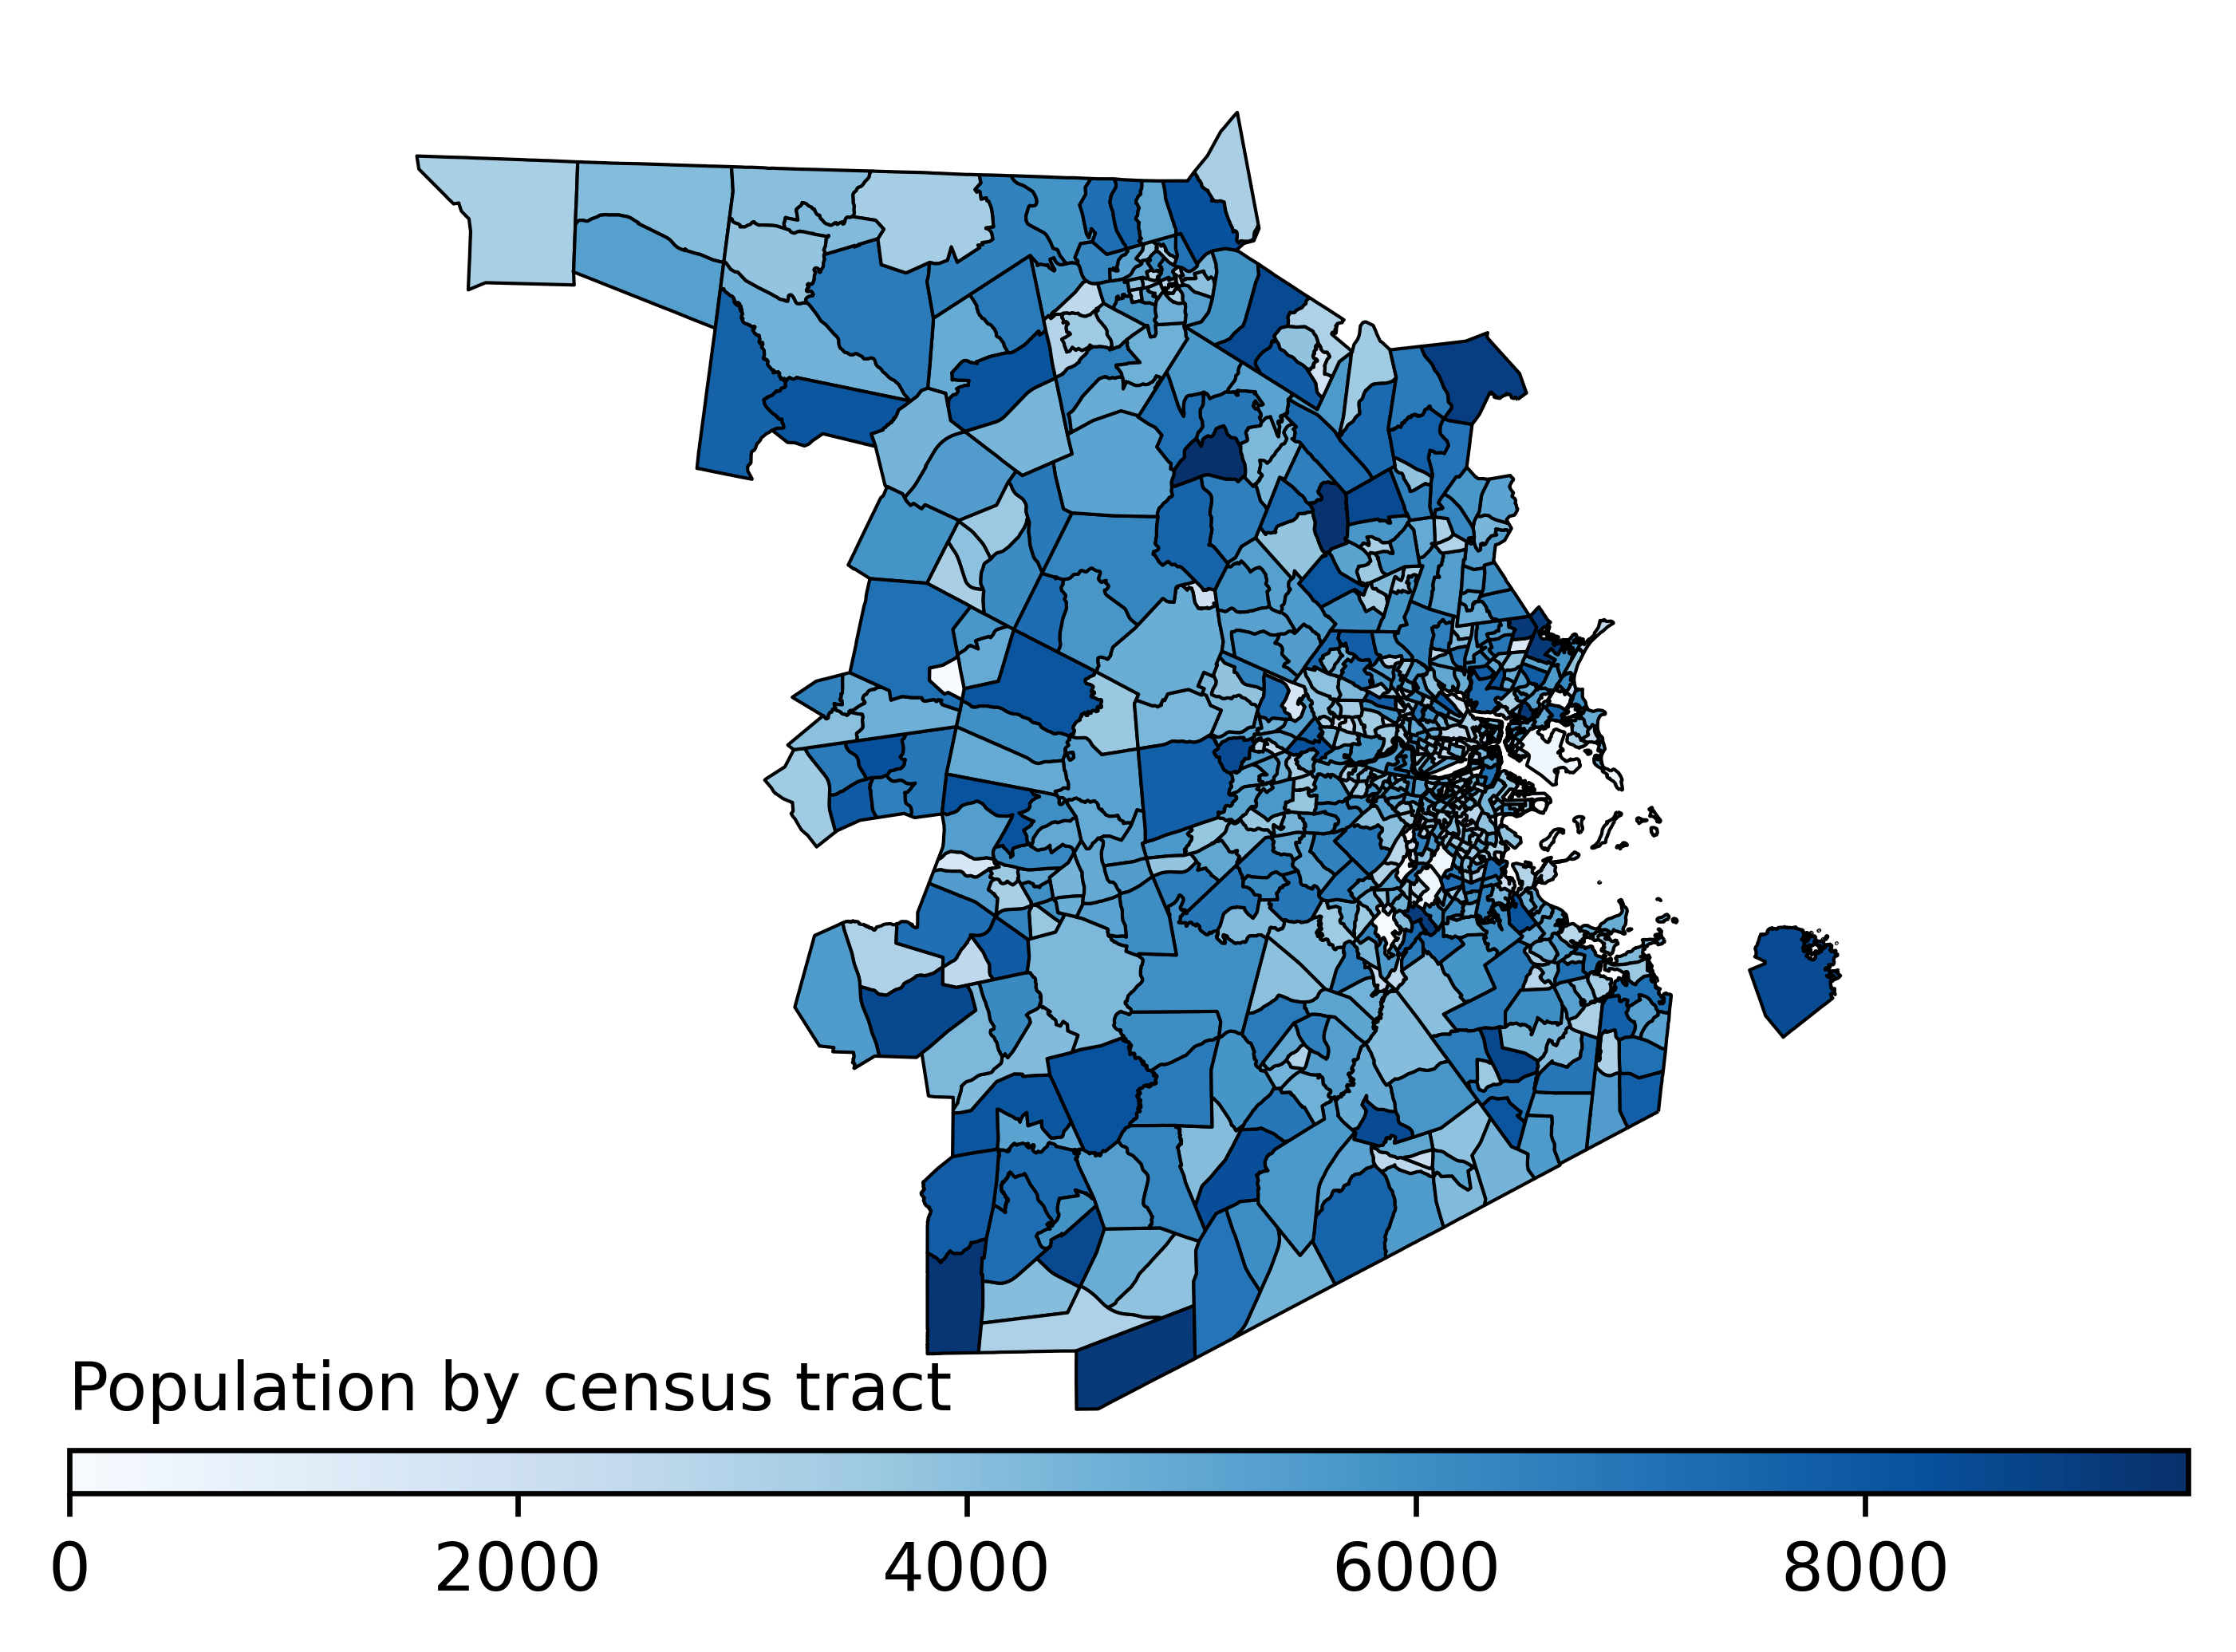

geometry  \
TRACT                                                            
25021418003  POLYGON ((-71.00721 42.23013, -71.00807 42.229...   
25021417701  POLYGON ((-71.00345 42.26050, -71.00326 42.260...   
25021417702  POLYGON ((-70.98695 42.26423, -70.98758 42.263...   

                                          Geographic Area Name  \
TRACT                                                            
25021418003  Census Tract 4180.03, Norfolk County, Massachu...   
25021417701  Census Tract 4177.01, Norfolk County, Massachu...   
25021417702  Census Tract 4177.02, Norfolk County, Massachu...   

             Estimate; Total  Margin of Error; Total  
TRACT                                                 
25021418003             2812                     206  
25021417701             5526                     462  
25021417702             2752                     268

In [1337]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
# Read in the census tracts shapefile,
# make the columns and values like the ACS data, then merge with ACS population data

ACS_POPULATION_ESTIMATE = "Estimate; Total"
GEOMETRY = 'geometry'

# title = 'Population by census tract in %s counties (MA)' % (
#     ', '.join([c.capitalize() for c in counties])
# )
title = 'Population by census tract'
# Read in the shapefile and merge it with the ACS data
tracts_shapefile_filepath = '../../shapefiles/ma/tract_middlesex_norfolk_suffolk.shp'
tracts_shapefile = gpd.read_file(tracts_shapefile_filepath).to_crs(epsg=4326)[['GEOID10', GEOMETRY]].rename(columns={'GEOID10': TRACT})
tracts_shapefile[TRACT] = tracts_shapefile.astype({TRACT: 'int64'})[TRACT]
merged_tracts_data_shapefile = tracts_shapefile.set_index(TRACT).join(acs_census_tract_population_est_df.set_index(TRACT))

# Make the population map!
fig, ax = plt.subplots(1, figsize=(10, 4), dpi=300)
merged_tracts_data_shapefile.plot(
    column=ACS_POPULATION_ESTIMATE,
    ax=ax,
    cmap="Blues",
    edgecolors="black",
    linewidth=0.5, 
)
ax.axis('off')
divider = make_axes_locatable(ax) # set an axis for the color bar
cax = divider.append_axes("bottom", size="3%", pad=-0.05)
# color bar
vmax = merged_tracts_data_shapefile[ACS_POPULATION_ESTIMATE].max()
mappable = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=0, vmax=vmax))
cbar = fig.colorbar(mappable, cax=cax, orientation="horizontal")
cbar.ax.tick_params(labelsize=10)
plt.title(
    title, 
    loc='left', fontsize=10,
)
print('Source: ACS 5-year estimates, 2018')
plt.show()
merged_tracts_data_shapefile.head(3)

## Evaluation 

Many models were evaluated using the below metrics to determine the "best" model parameters. 

See 
https://github.com/aberke/lbs-data/blob/master/trajectory_synthesis/evaluation/evaluate_rnn.ipynb


Here we use what was determined the "best" to show final final results.

The real data is used in evaluation - the generated synthetic data is compared ot the real data.



### Evaluation: Utility & Individual Privacy

Evaluation is meant to ensure that the generated synthetic trajectories balance utility and privacy.  

#### 1. Utility

We evaluate whether in aggregate, the generated synthetic data is like the real data.
We also evaluate whether the process of conditionally generating synthetic trajectories with (home, work) locations is successful.

Utility evaluations are in the first part of this file.


#### 2. Privacy

We evaluate that at the individual trajectory level, the generation process introduced sufficient noise to retain individual user privacy.

Privacy evaluations are in the second part of this file.

## Helper functions and constants

In [188]:
HOURS_PER_DAY = 24
TIME_PERIOD_DAYS = 5

In [243]:
def get_generated_trajectories_filename(sample_name):
    return '../textgenrnn_generator/output/{}.txt'.format(sample_name)


def read_trajectories_from_file(filename):
    """
    Returns a list of lists, where each list represents a trajectory written to file.
    Expects file format where each line is one trajectory, 
    and places in the trajectory are delimited by spaces.
    """
    trajectories = []
    with open(filename, 'r') as f:
        trajectories = [[int(x) for x in line.strip().split()] for line in f]
    return trajectories


def get_min_edit_distances_filename(sample_name, to='real'):
    return '../textgenrnn_generator/output/min-edit-distances-to-{to}-pop-from-{sample_name}.txt'.format(
        sample_name=sample_name, to=to
    )

In [244]:
def get_unprefixed_vectors(prefixed_vectors):
    unprefixed_vectors = []
    for pv in prefixed_vectors:
        _p, v = break_prefix(pv, days=TIME_PERIOD_DAYS, hours=HOURS_PER_DAY)
        unprefixed_vectors.append(v)
    return unprefixed_vectors

### Load and inspect the real data

In [748]:
# Load the real trajectories data. Note these are prefixed by home,work labels
relabeled_trajectories_filename = '../data/relabeled_trajectories_1_workweek.txt'
real_tvs = read_trajectories_from_file(relabeled_trajectories_filename)

Inspect "vocabulary size".  i.e. Number of distinct census areas in data

In [749]:
# What is the vocabulary size? i.e. how many distinct labels?
vocab = set()
for t in real_tvs:
    vocab.update(set(t))
print(len(vocab))

652


- How many distinct (home, work) label pairs?
- Of the distinct (home, work) label pairs, how many users for each?
- How many unique (home, work) label pairs?

In [750]:
def get_home_work_label_pair_count(tvs):
    """
    Returns dictionary (h,w) -> count representing the trajectories in tvs
    """
    home_work_label_pair_to_user_count = {(t[0], t[1]):0 for t in tvs}
    for t in tvs:
        home_work_label_pair_to_user_count[(t[0], t[1])] += 1
    return home_work_label_pair_to_user_count

In [751]:
real_home_work_label_pair_to_user_count = get_home_work_label_pair_count(real_tvs)
print('total number of users: %s' % len(real_tvs))
print('number of distinct (home, work) label pairs: %s' % len(home_work_label_pair_to_user_count))

total number of users: 22704
number of distinct (home, work) label pairs: 8659


In [752]:
unique_home_work_label_pairs = {hw for hw,c in home_work_label_pair_to_user_count.items() if c == 1}
unique_count = len(unique_home_work_label_pairs)
print('total  number of unique (home, work) label pairs:',unique_count)
print('representing portion of dataset:', unique_count/len(real_tvs))

total  number of unique (home, work) label pairs: 6898
representing portion of dataset: 0.3038231148696265


## Model and trajectories

RNN models were trained with a variety of architectures and parameters. Then they generated synthetic trajectories following the same rules. Another notebook evaluated and selected the best. We grab the model details and synthetic data here.

In [753]:
model_name = 'Q-bidirectional.2'

In [754]:
# The model 'names' and parameters  were tracked in a spreadsheet, loaded as a CSV below
models_matrix_df = pd.read_csv(
    '../textgenrnn_generator/textgenrnn_model_parameters_.csv',
    index_col=0
)
models_matrix_df = models_matrix_df.loc[models_matrix_df.index.dropna()]
models_matrix_df.drop([
    'generated for cambridge', 
    'generated for general sample'
], axis=0, inplace=True)
model = models_matrix_df[[model_name]].rename({model_name:'parameters'}, axis=1)
model

parameters
rnn_bidirectional       TRUE
max_length                60
rnn_layers                 3
rnn_size                 128
dropout                  0.1
dim_embeddings           128
temperature                1
batch size              1024

# Data used in analysis

Real sample, $S$

In [755]:
real_trajectories_sample_2000_filename = '../data/relabeled_trajectories_1_workweek_sample_2000.txt'
real_tvs_sample = read_trajectories_from_file(real_trajectories_sample_2000_filename)
assert(all([real_tvs_sample[t] in real_tvs for t in [1,2,3,-3,-2,-1]]))

Generated sample, $S'$

In [757]:
parameters = model['parameters']
model_parameters_name = 'trajectories-rnn_bidirectional:{}-max_len:{}-rnn_layers:{}-rnn_size:{}-dropout:{}-dim_embeddings:{}'.format(
    parameters['rnn_bidirectional'], parameters['max_length'],
    parameters['rnn_layers'], parameters['rnn_size'],
    parameters['dropout'], parameters['dim_embeddings']
)
generated_trajectories_sample_name = 'generated-sample-{}-temperature:{}'.format(
        model_parameters_name, float(parameters['temperature'])
)
generated_trajectories_sample_filepath = get_generated_trajectories_filename(
    generated_trajectories_sample_name
)
generated_tvs_sample = read_trajectories_from_file(generated_trajectories_sample_filepath)

In [758]:
len(generated_tvs_sample)

2000

### Additional samples used as baselines for evaluating utility metrics

Following the approach of 

Bindschaedler, V. and Shokri, R., 2016, May. Synthesizing plausible privacy-preserving location traces. In 2016 IEEE Symposium on Security and Privacy (SP) (pp. 546-563). IEEE.
https://ieeexplore.ieee.org/abstract/document/7546522

1. Secondary, real test sample, $S_{secondary}$
2. Uniform random sample, $S_{random}$

We draw samples with the same (h,w) pair counts as $S$ and $S'$

In [759]:
assert(get_home_work_label_pair_count(real_tvs_sample) == get_home_work_label_pair_count(generated_tvs_sample))
sample_hw_count = get_home_work_label_pair_count(real_tvs_sample)
assert(sum(sample_hw_count.values()) == 2000)

In [760]:
# secondary sample
def draw_secondary_sample(hw_count, tvs=real_tvs, random_seed=0):
    random.seed(random_seed)
    secondary_sample = []
    for (h,w), count in hw_count.items():
        c = 0
        while c < count:
            t = random.choice(tvs)
            if (t[0] == h) and (t[1] == w):
                secondary_sample += [t]
                c += 1
    return secondary_sample

In [786]:
secondary_real_tvs_sample = draw_secondary_sample(sample_hw_count)

In [787]:
assert(len(secondary_real_tvs_sample) == len(real_tvs_sample))
assert(len(secondary_real_tvs_sample[0]) == len(real_tvs_sample[0]))
assert(get_home_work_label_pair_count(secondary_real_tvs_sample) \
       == get_home_work_label_pair_count(generated_tvs_sample))

In [788]:
# random sample

random.seed(0)
random_tvs_sample = []
for (h,w), count in sample_hw_count.items():
    for c in range(count):
        t = [h,w] + [random.choice(list(vocab)) for i in range(120)]
        random_tvs_sample += [t]

In [789]:
assert(len(random_tvs_sample) == len(real_tvs_sample))
assert(len(random_tvs_sample[0]) == len(real_tvs_sample[0]))
assert(get_home_work_label_pair_count(random_tvs_sample) \
       == get_home_work_label_pair_count(random_tvs_sample))

### See Trajectory Patterns

There are patterns in the individual trajectories that occur naturally due to the daily routines of life.
These patterns should also occur in the generated synthetic trajectory data.

Shown in a few  ways...

/Users/aberke/projects/lbs-data/env/lib/python3.7/site-packages/ipykernel_launcher.py:82: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('|').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.


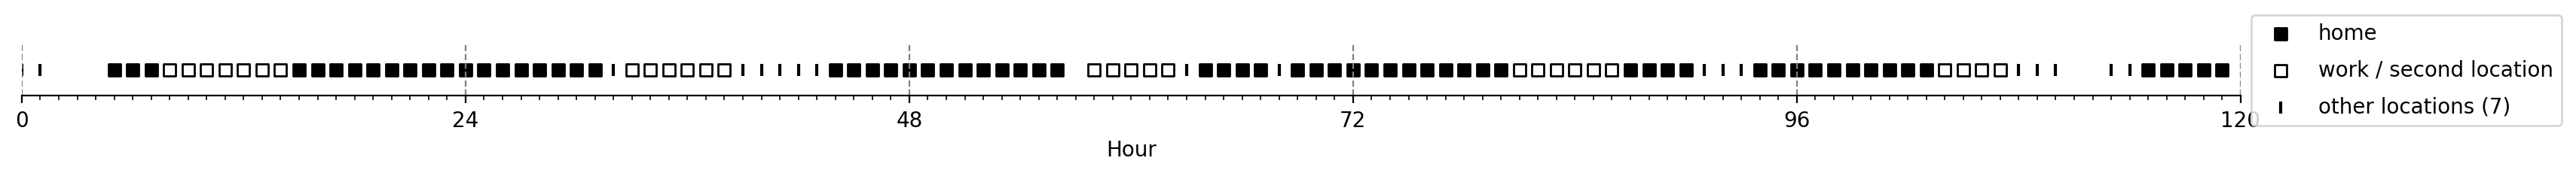

by frequency order:
[4 8 7 5 6 3]


/Users/aberke/projects/lbs-data/env/lib/python3.7/site-packages/ipykernel_launcher.py:73: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
/Users/aberke/projects/lbs-data/env/lib/python3.7/site-packages/ipykernel_launcher.py:82: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.


hour  place  place by frequency  place by frequency order
0     0     63                   2                         4
1     1     63                   2                         4
5     5     64                  68                         8
6     6     64                  68                         8
7     7     64                  68                         8

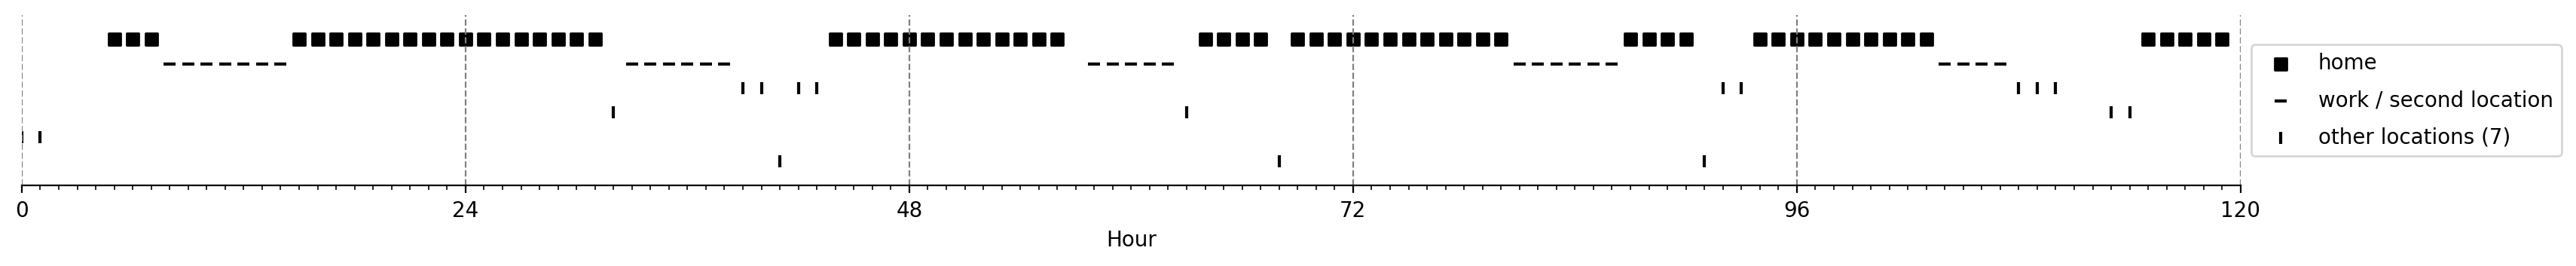

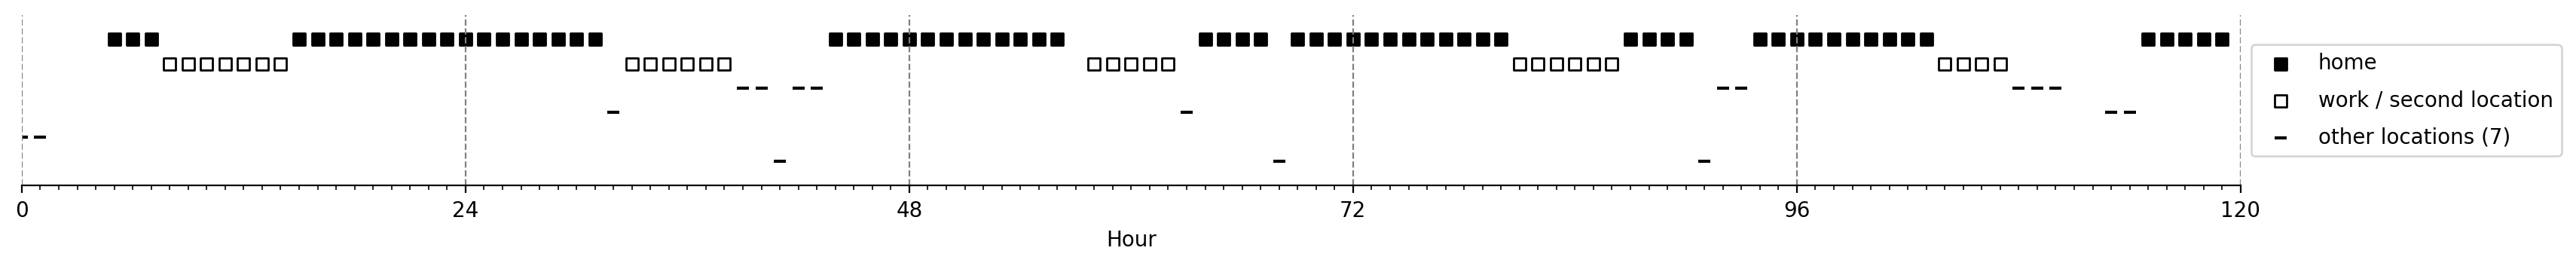

In [790]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

default_h_marker = 's'
default_w_marker = 's'
default_o_marker = '_'
HOUR = 'hour'
def plot_trajectory_markers(trajectory, by_frequency_order=False,
                            h_marker=default_h_marker, w_marker=default_w_marker, o_marker=default_o_marker,
                           ax=None, figsize=None, legend=True, dpi=100):
        
    [home_label, work_label], unprefixed_t = break_prefix(trajectory)
    
    other_labels_frequencies  = dict()
    for l in [li for li in unprefixed_t if not (li in [home_label, work_label])]:
        if l not in other_labels_frequencies:
            other_labels_frequencies[l] = 0
        other_labels_frequencies[l] += 1

    t_df = pd.DataFrame({
        HOUR:list(range(len(unprefixed_t))),
        PLACE_LABEL:unprefixed_t,
    })
    # drop the null  place
    t_df = t_df[t_df[PLACE_LABEL]!=0]
    
    labels_to_frequency = t_df[PLACE_LABEL].value_counts().to_dict()
    t_df[PLACE_LABEL_BY_FREQUENCY] = t_df[PLACE_LABEL].map(labels_to_frequency)
    sorted_frequencies = sorted(labels_to_frequency.values())
    frequency_to_frequency_order = {sorted_frequencies[f]: f+1 for f in range(len(sorted_frequencies))}
    t_df[PLACE_LABEL_BY_FREQUENCY_ORDER] = t_df[PLACE_LABEL_BY_FREQUENCY].map(frequency_to_frequency_order)
    h_df = t_df[t_df[PLACE_LABEL]==home_label]
    w_df = t_df[t_df[PLACE_LABEL]==work_label]
    o_df = t_df[t_df[PLACE_LABEL].isin(other_labels_frequencies)]
    
    if ax is None:
        if figsize is None:
            figsize=(19,0.45)
            if by_frequency_order:
                figsize=(19,1.5)
        fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    
    h_y=np.ones(len(h_df[HOUR]))
    w_y=np.ones(len(w_df[HOUR]))
    o_y=np.ones(len(o_df[HOUR]))
    if by_frequency_order:
        h_y = h_df[PLACE_LABEL_BY_FREQUENCY_ORDER]
        w_y = w_df[PLACE_LABEL_BY_FREQUENCY_ORDER]
        o_y = o_df[PLACE_LABEL_BY_FREQUENCY_ORDER]
       
    h_color = 'black'
    w_color = 'black' if w_marker in ['_','|','x'] else 'white'
    o_color = 'black' if o_marker in ['_','|','x'] else 'white'
    ax.scatter(
        h_df[HOUR], 
        h_y,
        c=h_color,
        marker=h_marker,
        edgecolor='black',
        label='home',
    )
    work_legend_label = 'work / second location'
    if work_label == home_label:
        work_legend_label = 'work (same as home)'
        w_marker = h_marker
        w_color = h_color
    ax.scatter(
        w_df[HOUR],
        w_y,
        c=w_color,
        edgecolor='black',
        marker=w_marker,
        label=work_legend_label,
    )
    ax.scatter(
        o_df[HOUR],
        o_y,
        c=o_color,
        edgecolor='black',
        marker=o_marker,
        label='other locations (%s)'%len(other_labels_frequencies),
        alpha=1,
    )
    # bad hack: adding one extra for padding
    ax.set_xlim([0, 24*DAYS]) # otherwise changes around axes to better fit data
    # ax.set_xlim([-1, 24*DAYS]) # otherwise changes around axes to better fit data
    ax.xaxis.set_major_locator(MultipleLocator(24))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    plt.grid(b=True,which='major',axis='x',color='gray',linestyle='--')
    ax.set_xlabel('Hour')
    #if by_frequency_order:
    #    ax.set_ylabel('Frequency')
    # make background white
    ax.get_figure().set_facecolor('w')
    box = ax.get_position()
    if legend:
        ax.legend(
            loc='center left',
            labelspacing=0.75,
            markerscale=1,
            # bbox (x, y, width, height)
            bbox_to_anchor=(1, 0.5)
        )
    ax.yaxis.set_ticks([])
    y_lim_bottom = min(list(frequency_to_frequency_order.values()))-1 if by_frequency_order else 0
    y_lim_top= max(list(frequency_to_frequency_order.values()))+1 if by_frequency_order else 2
    ax.set_ylim(bottom=y_lim_bottom,top=y_lim_top)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return t_df

# Shown as  flat line
df = plot_trajectory_markers(real_trajectories[13],
                   by_frequency_order=False,
                   w_marker='s',o_marker='|')
plt.show()
# Shown by frequency order
print('by frequency order:')
df = plot_trajectory_markers(real_tvs[13],
                   by_frequency_order=True,
                   h_marker='s',w_marker='_',o_marker='|')
df = plot_trajectory_markers(real_tvs[13],
                   by_frequency_order=True,
                   h_marker='s',w_marker='s',o_marker='_')
print(df['place by frequency order'].unique())
df.head()

Places visited more often plotted higher:

/Users/aberke/projects/lbs-data/env/lib/python3.7/site-packages/ipykernel_launcher.py:82: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.


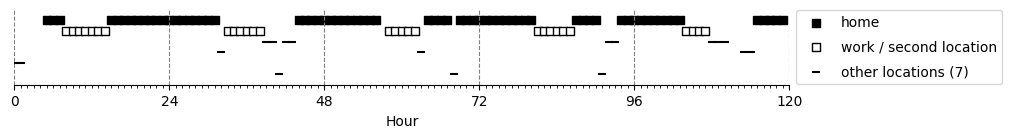

In [1298]:
df = plot_trajectory_markers(real_tvs[13],
                   by_frequency_order=True,
                   h_marker='s',w_marker='s',o_marker='_', figsize=(10,1), dpi=50)

## Show trajectories for real and generated samples

real sample


/Users/aberke/projects/lbs-data/env/lib/python3.7/site-packages/ipykernel_launcher.py:82: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
/Users/aberke/projects/lbs-data/env/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


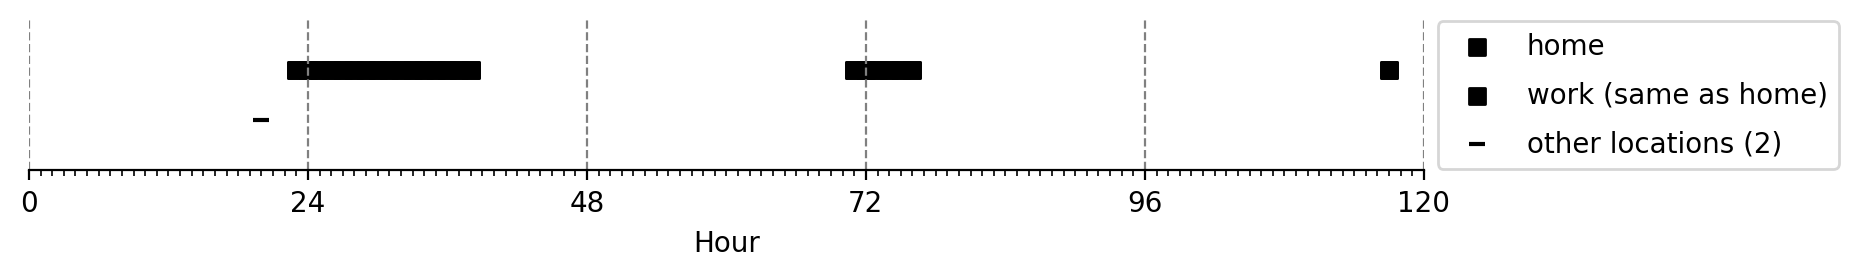

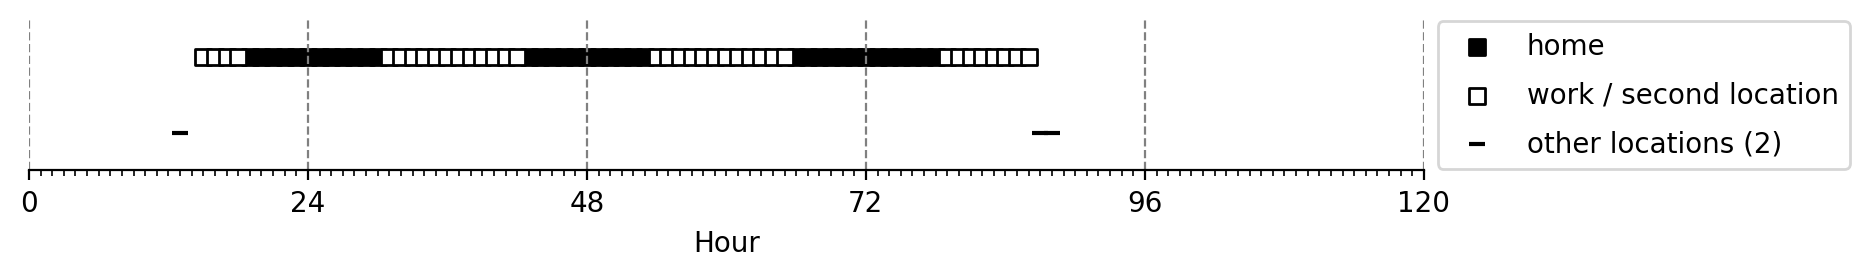

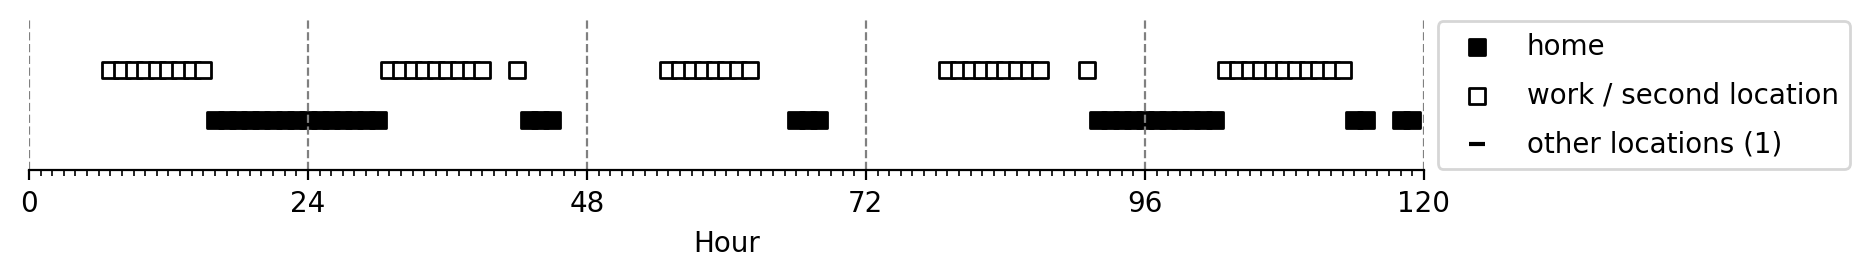

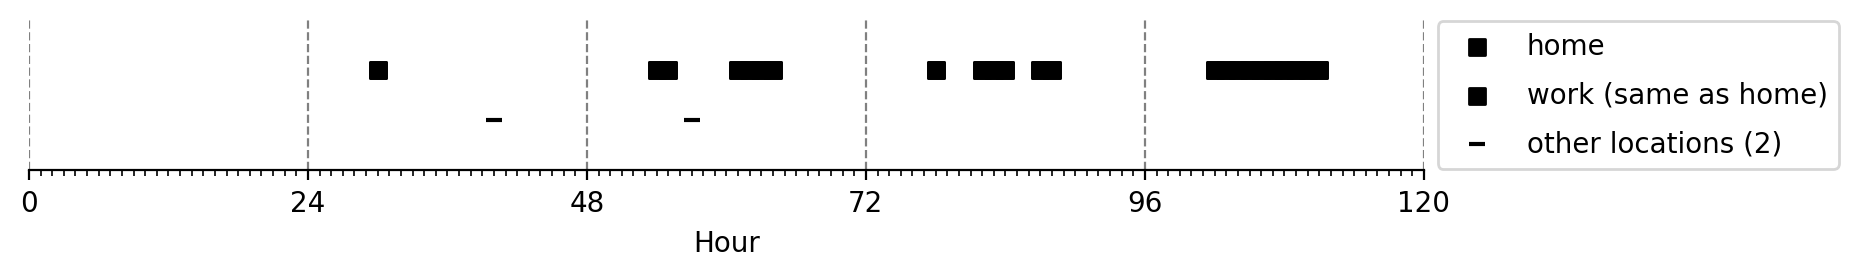

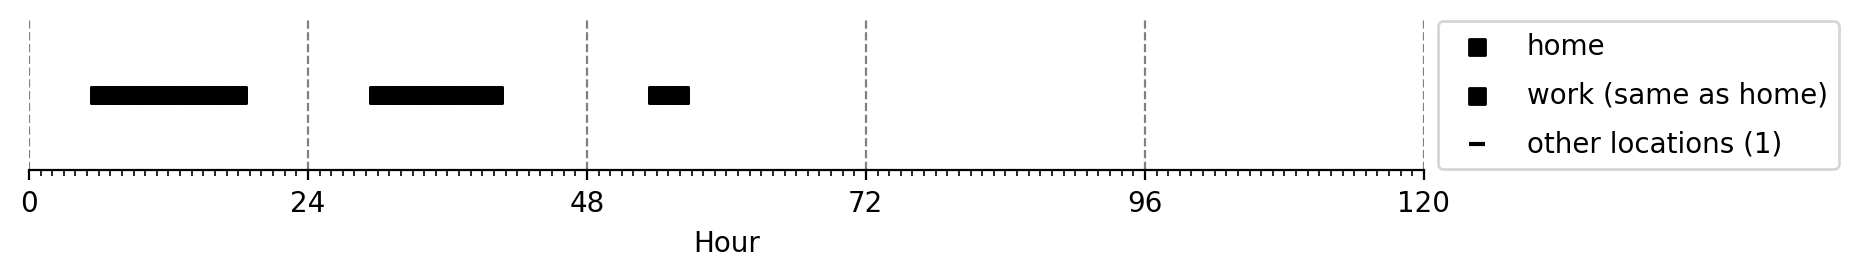

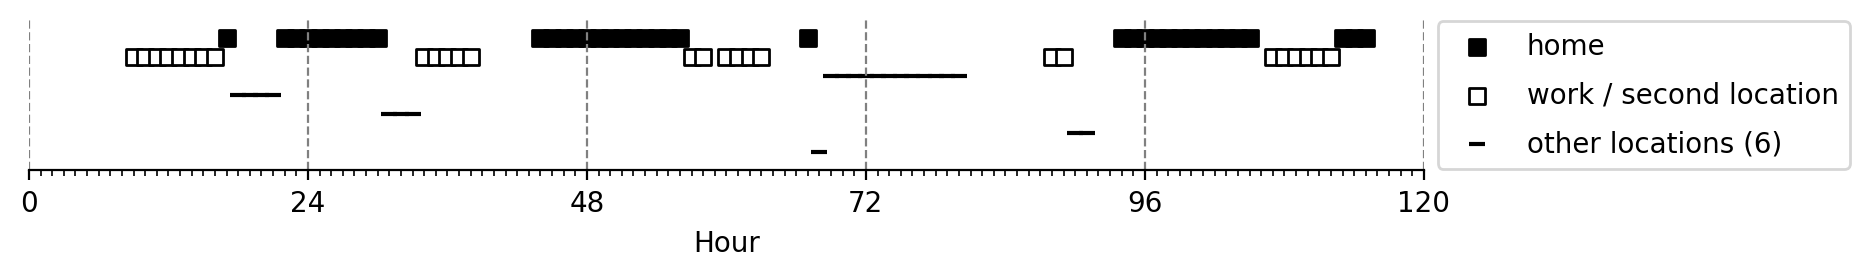

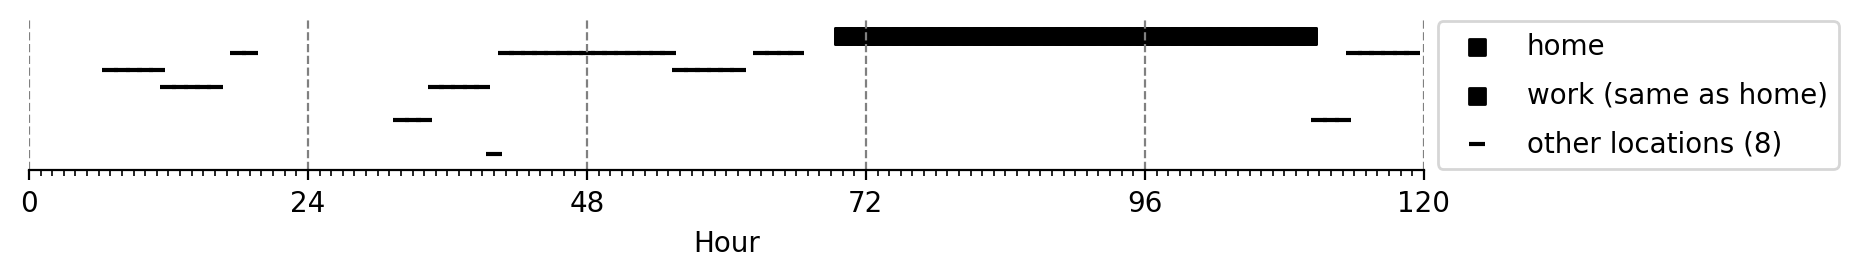

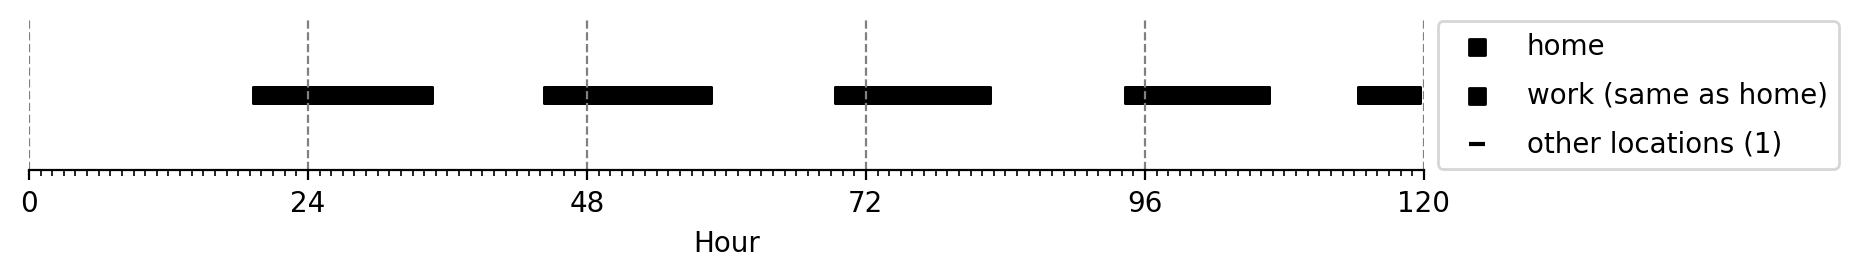

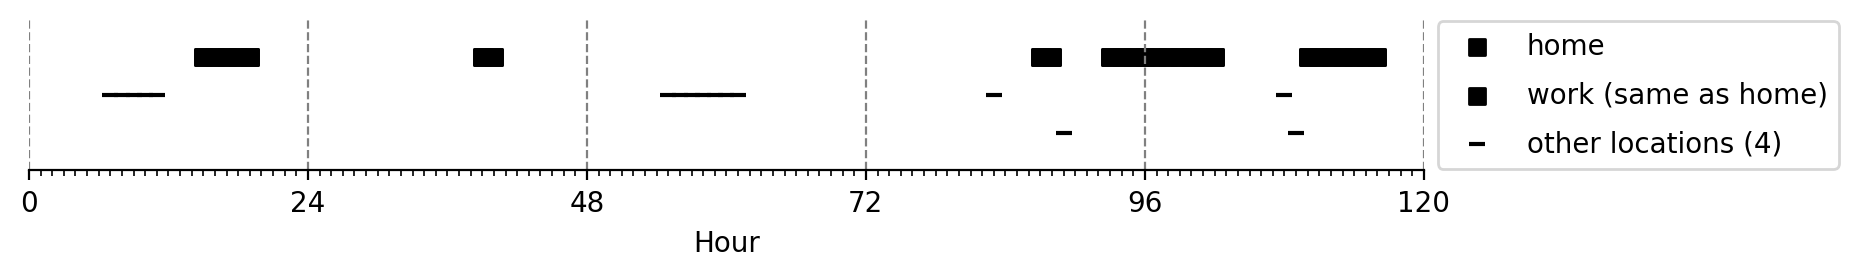

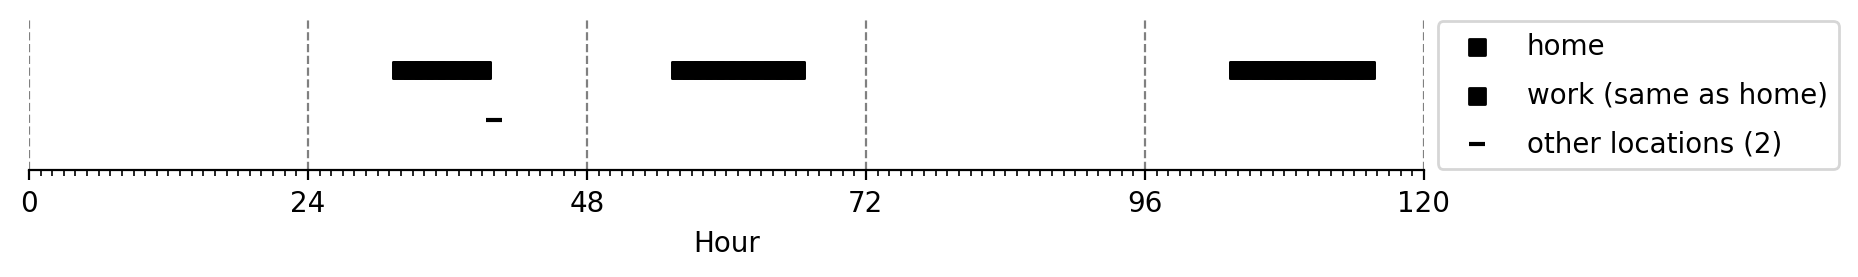

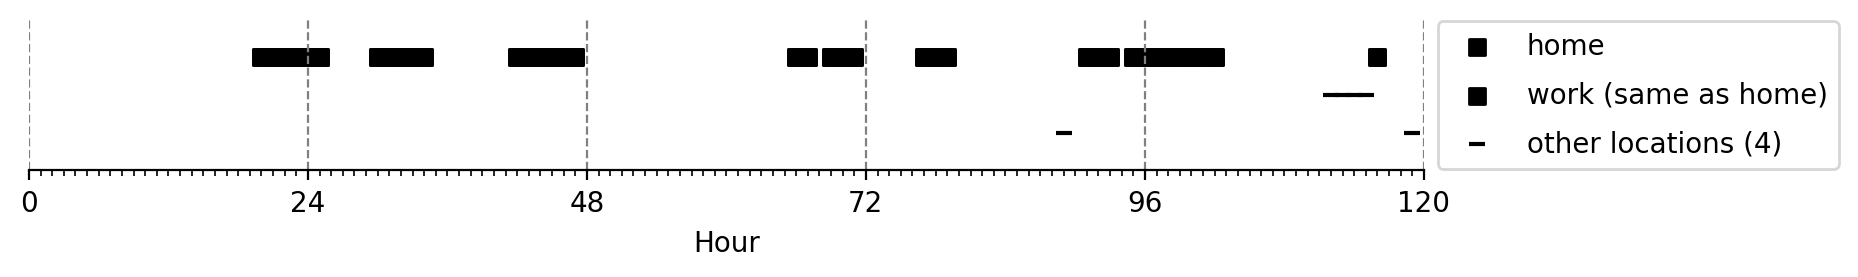

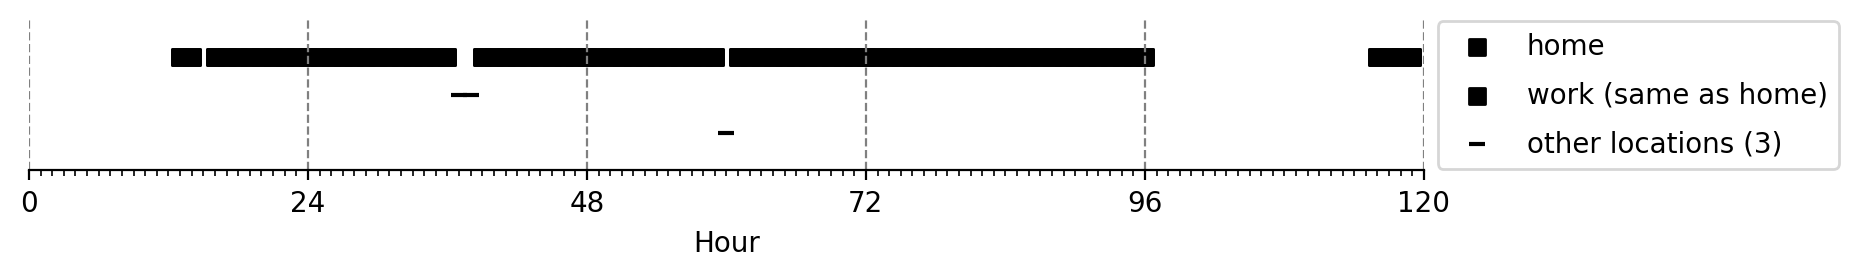

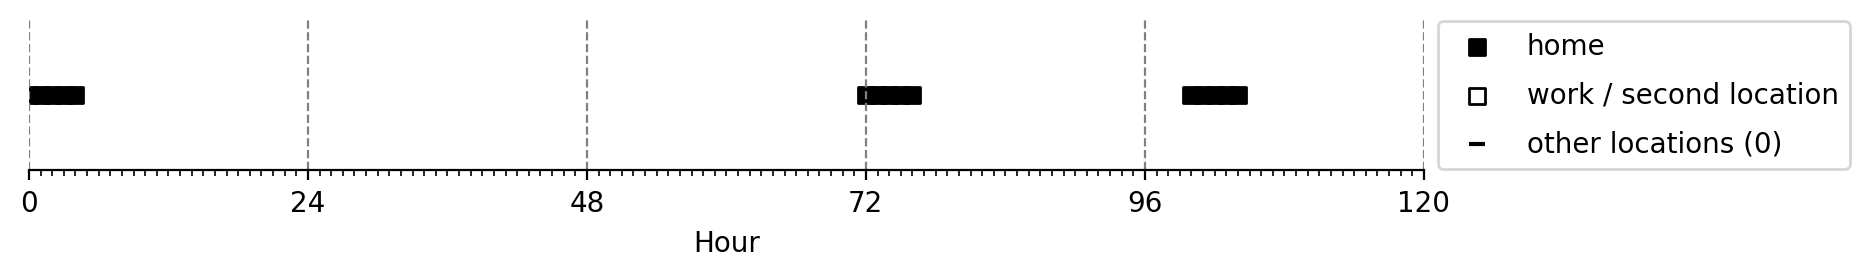

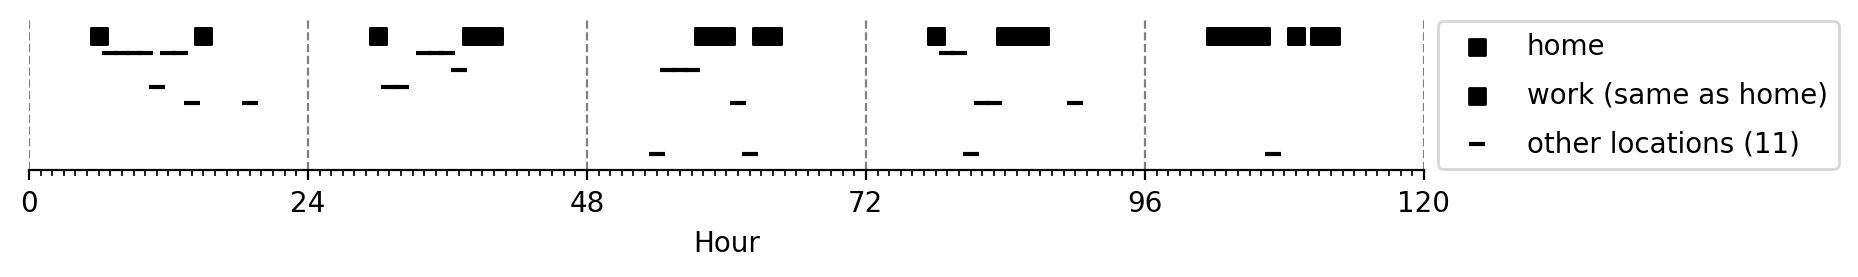

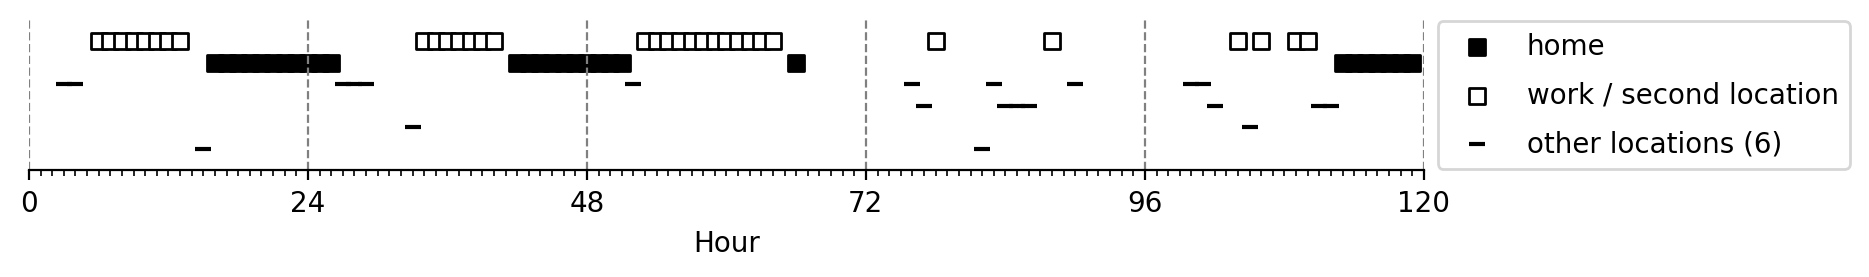

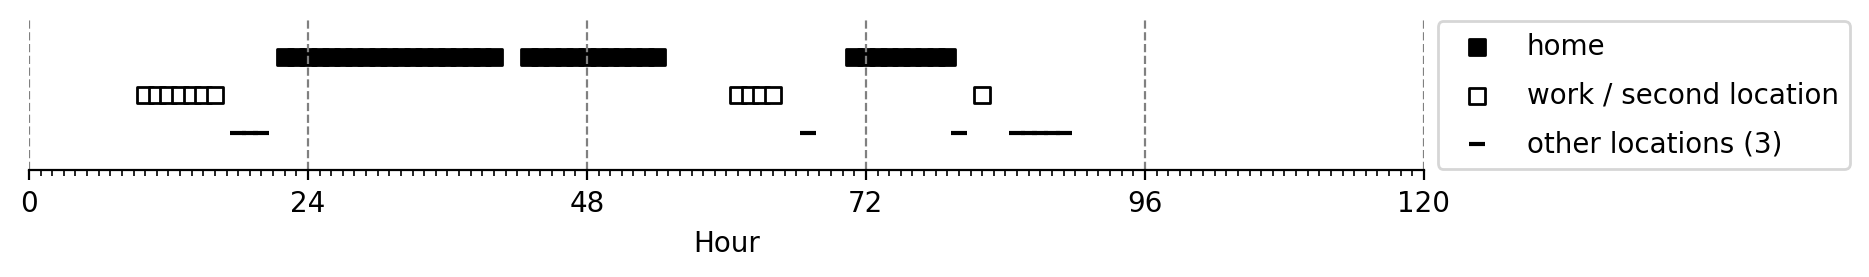

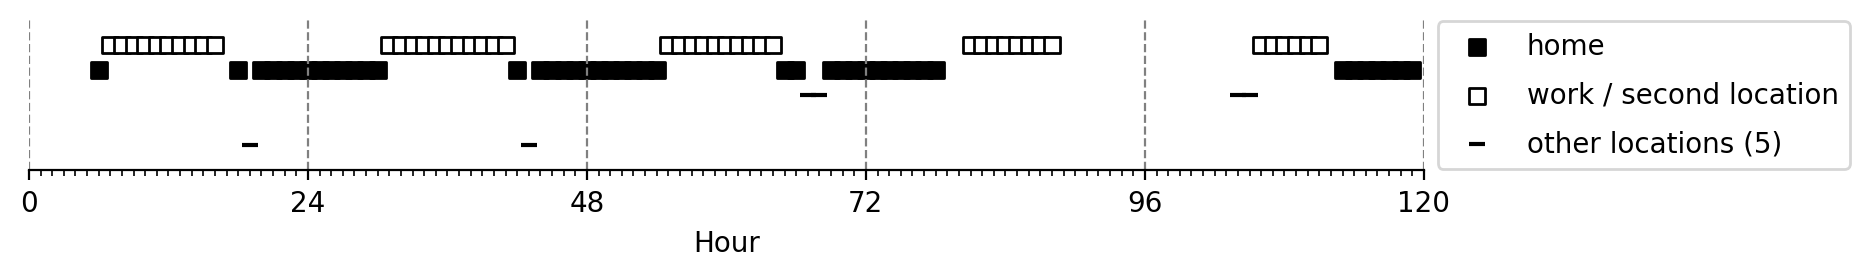

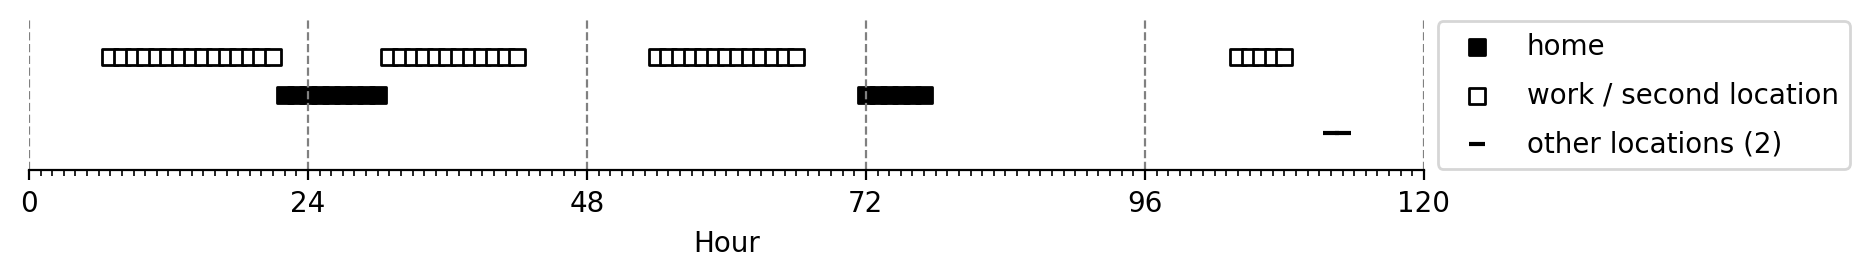

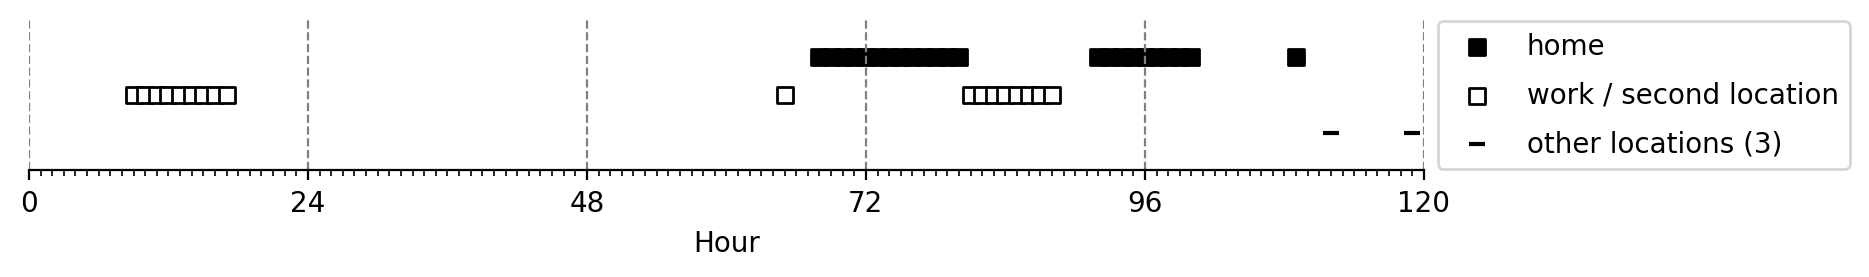

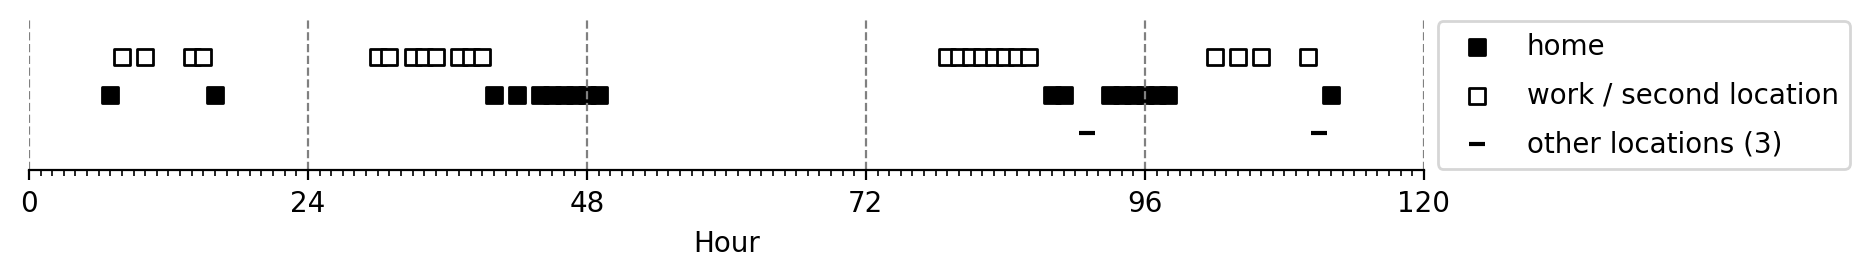

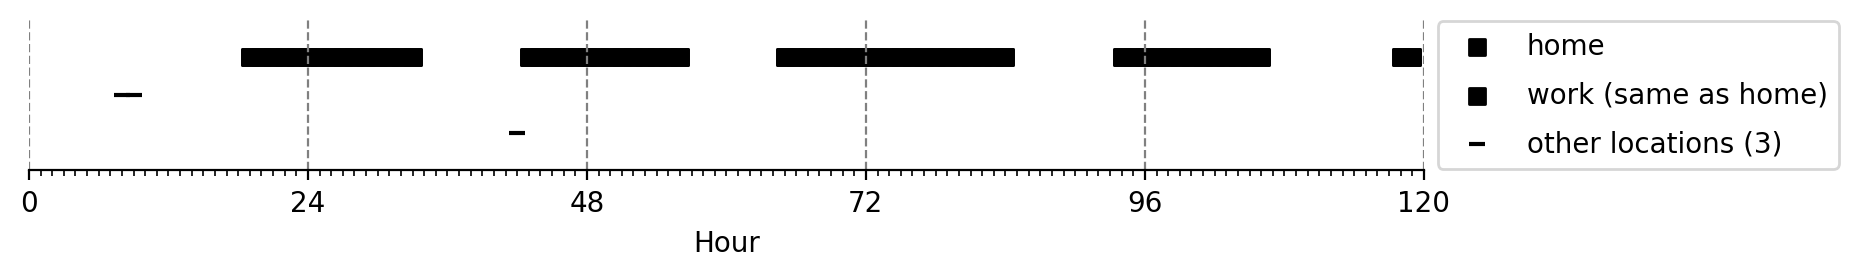

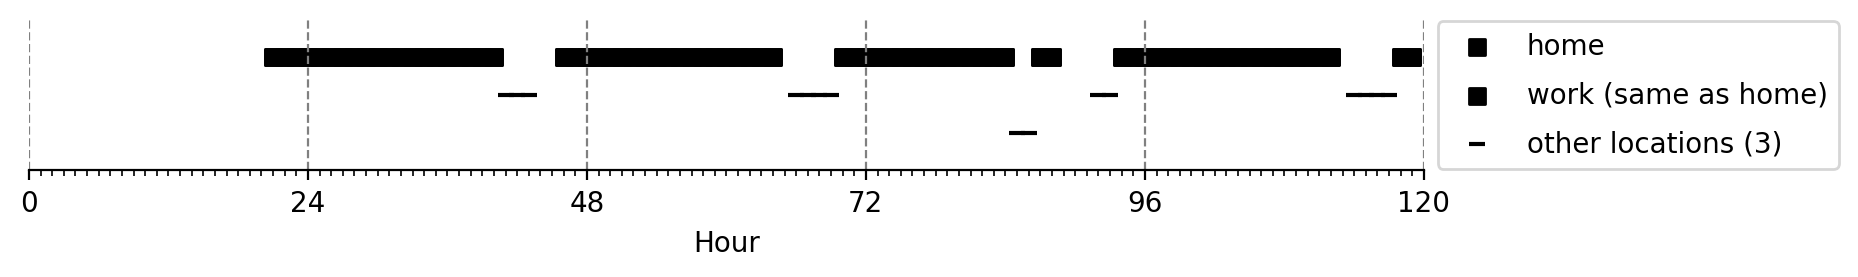

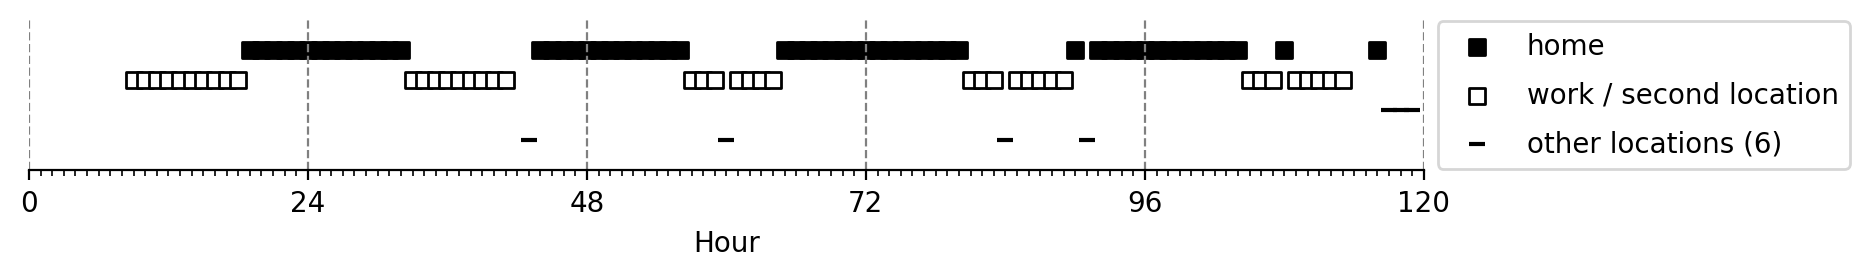

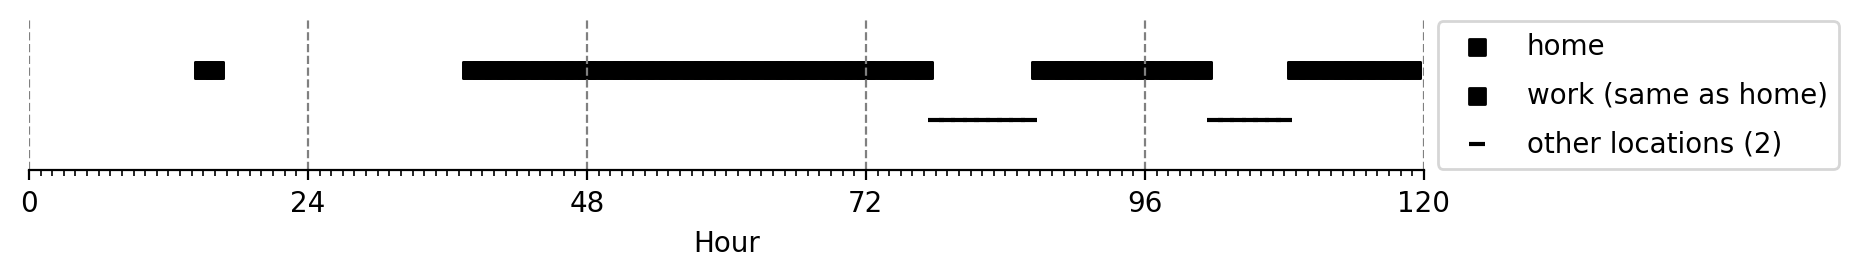

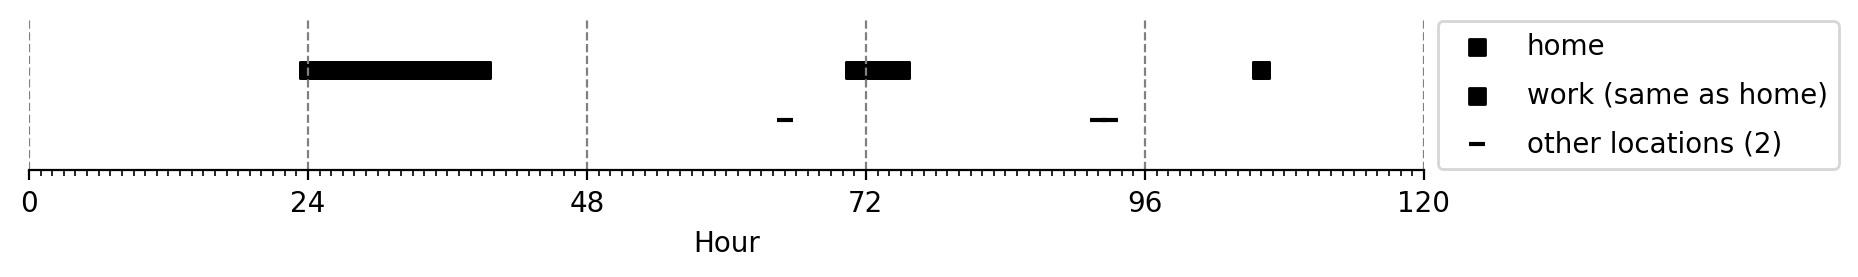

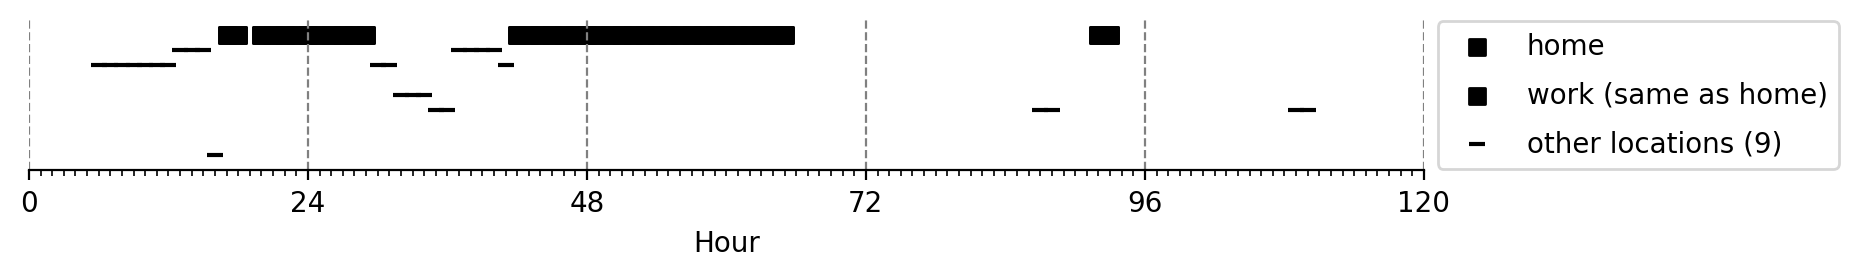

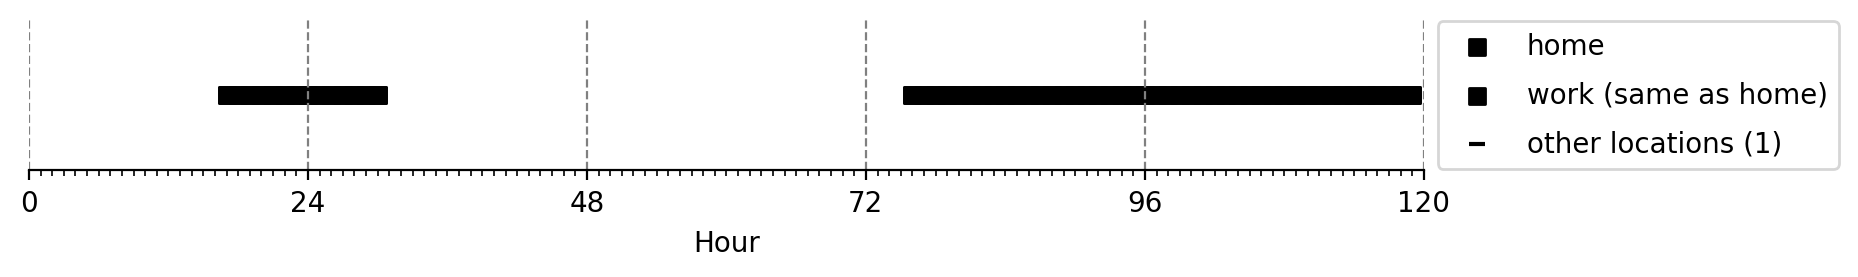

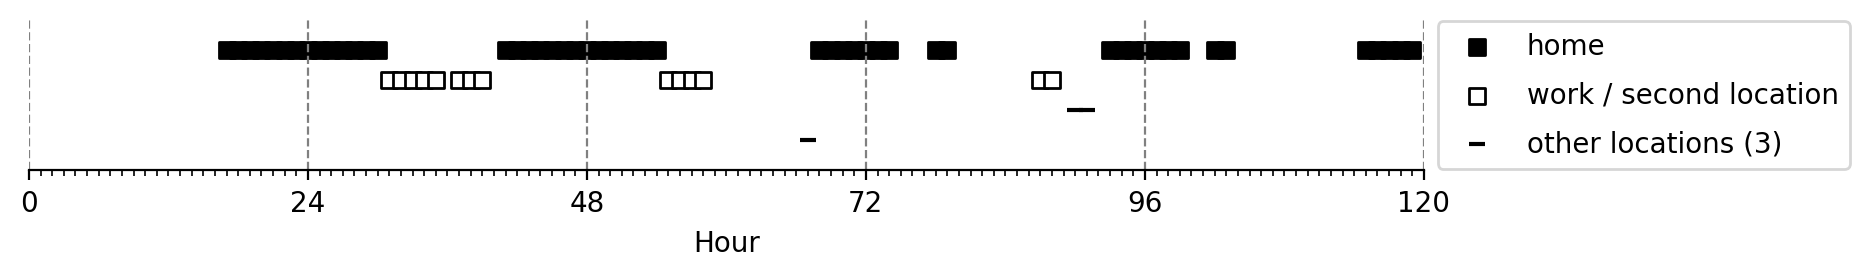

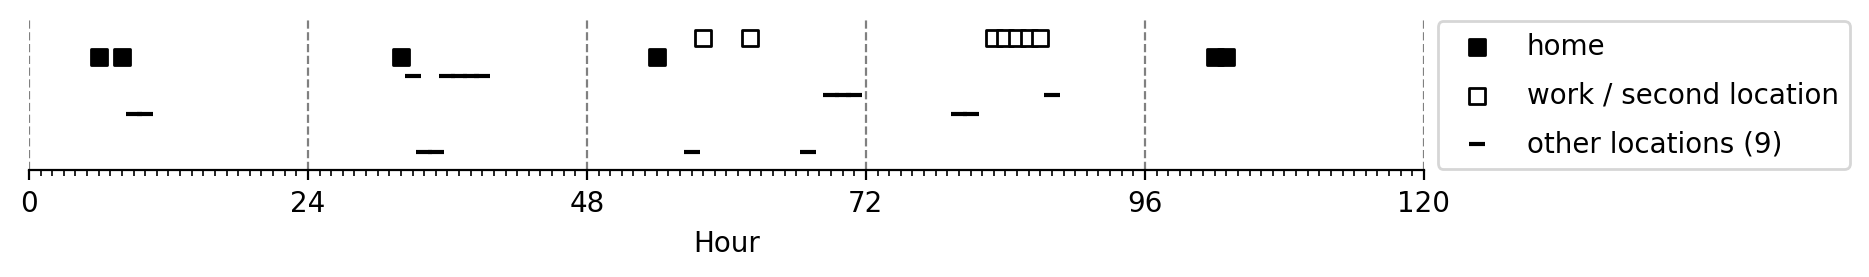

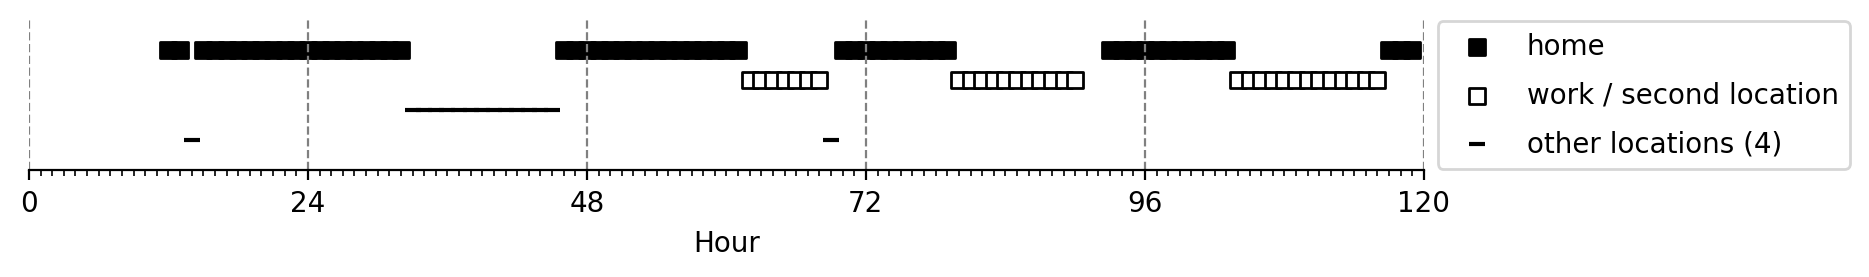

In [1338]:
print('real sample')
for _t, t in enumerate(real_tvs_sample[:30]):
    plot_trajectory_markers(t, by_frequency_order=True,
                            h_marker='s',w_marker='s',o_marker='_', figsize=(9,1), dpi=100)

generated sample


/Users/aberke/projects/lbs-data/env/lib/python3.7/site-packages/ipykernel_launcher.py:82: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
/Users/aberke/projects/lbs-data/env/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


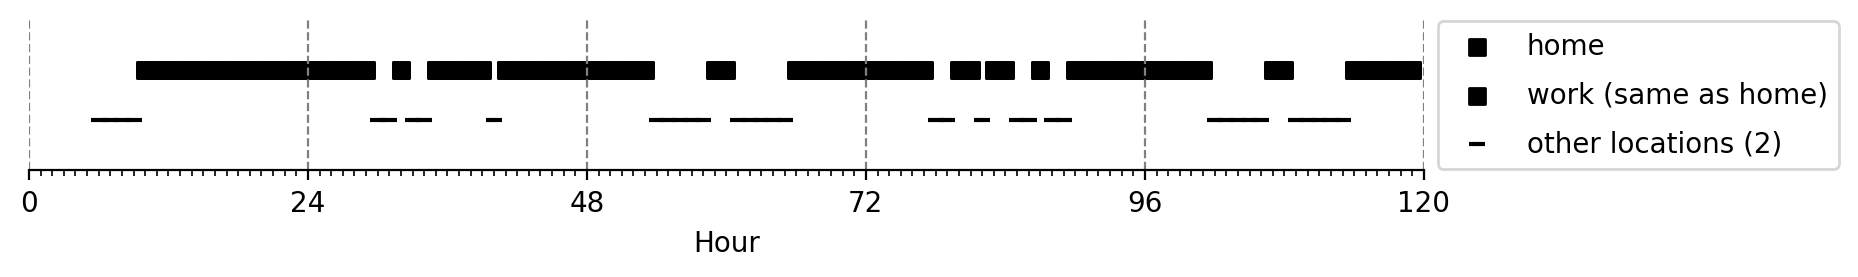

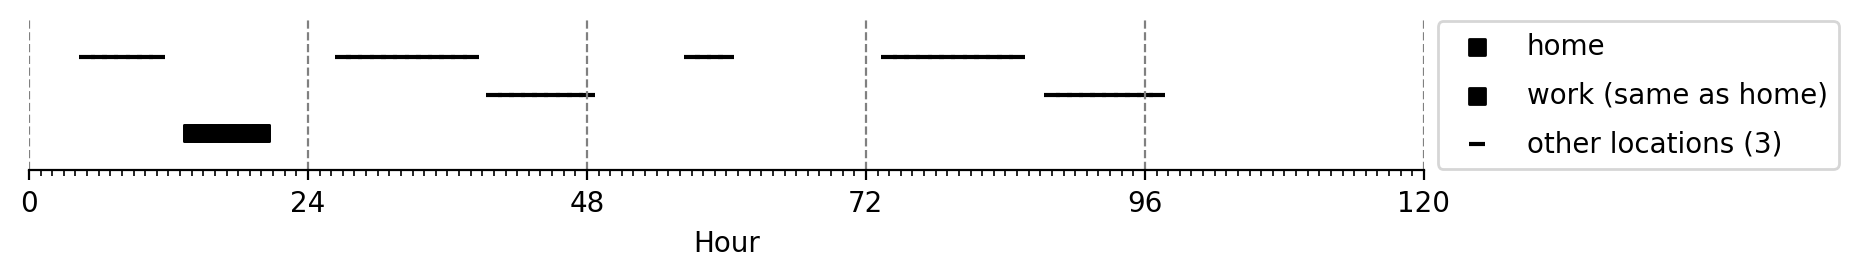

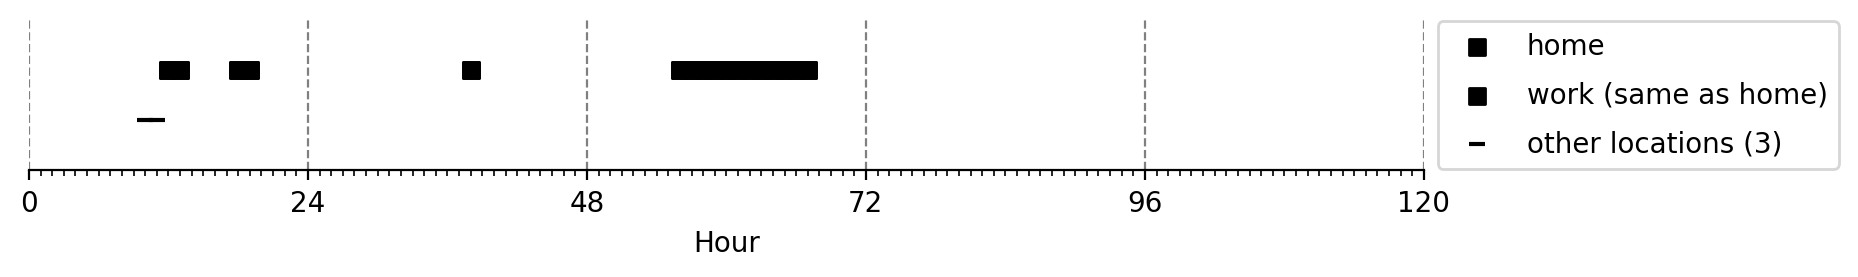

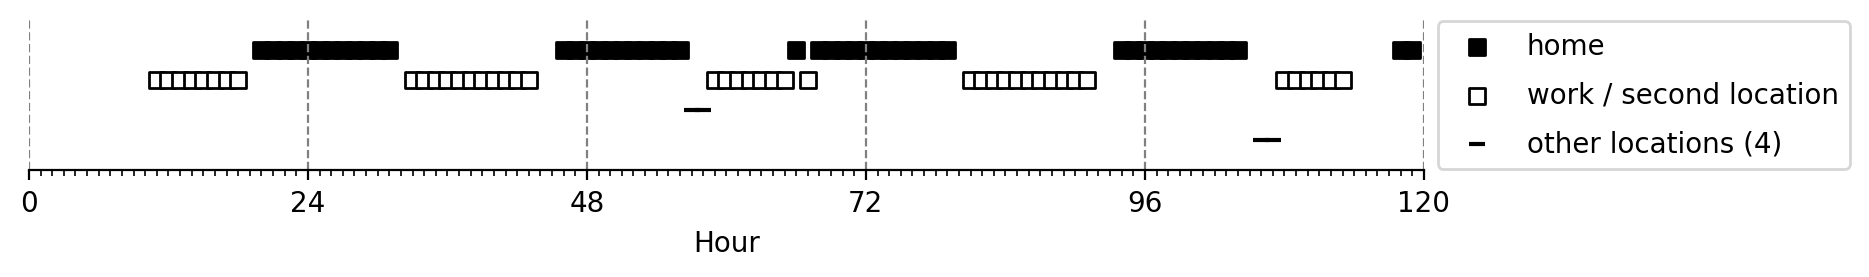

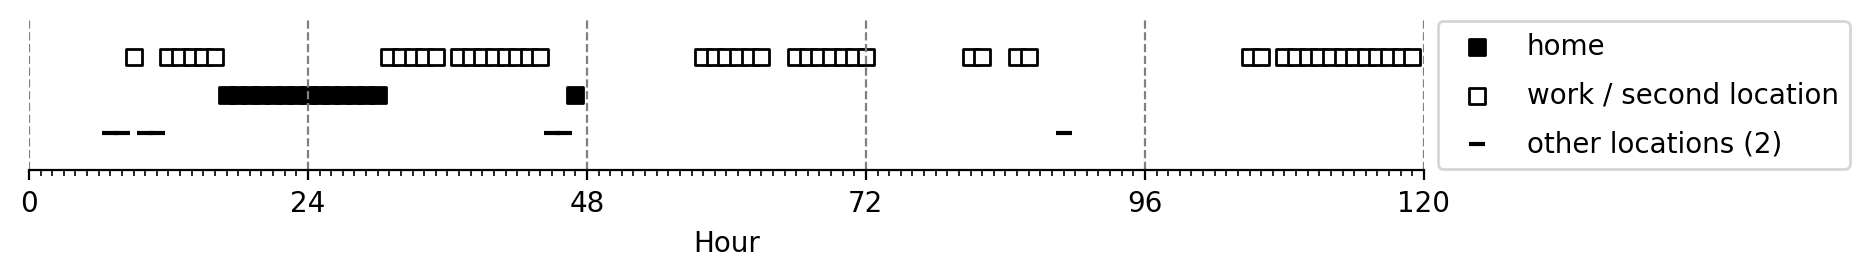

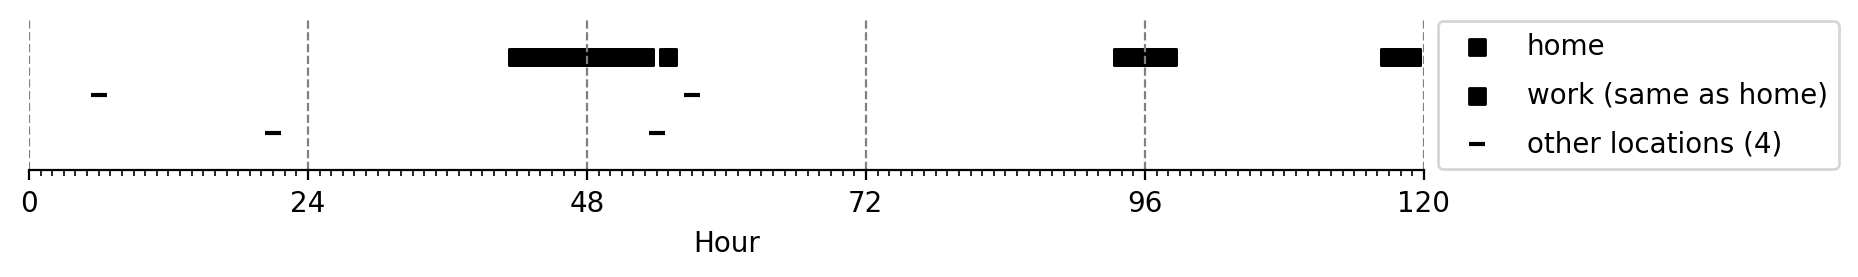

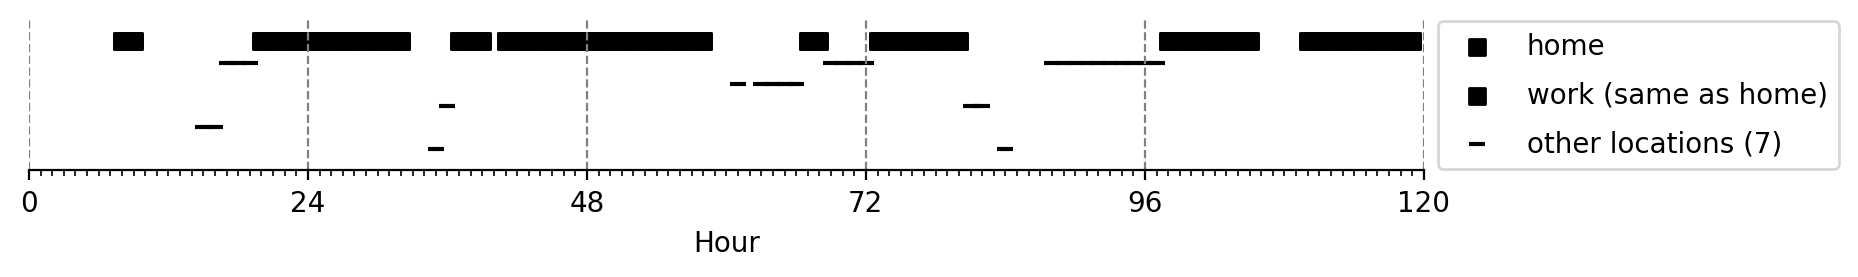

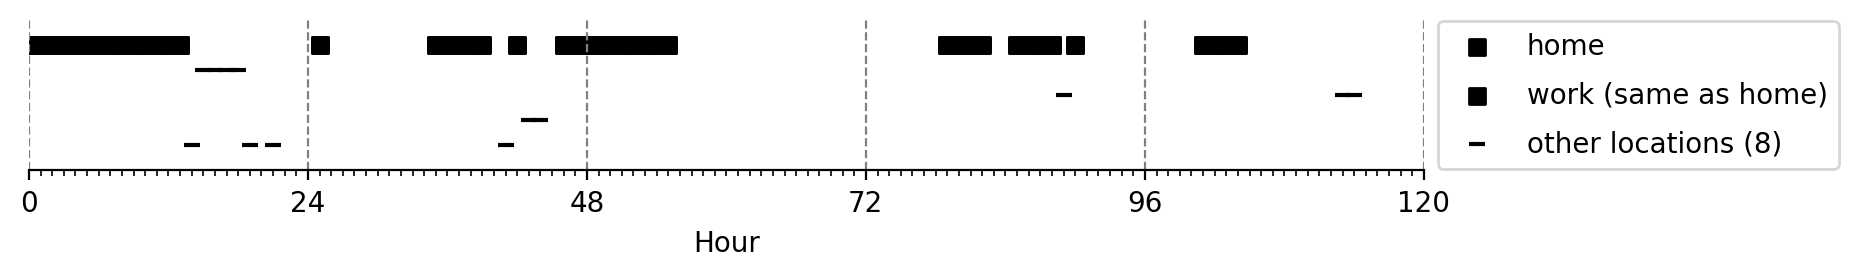

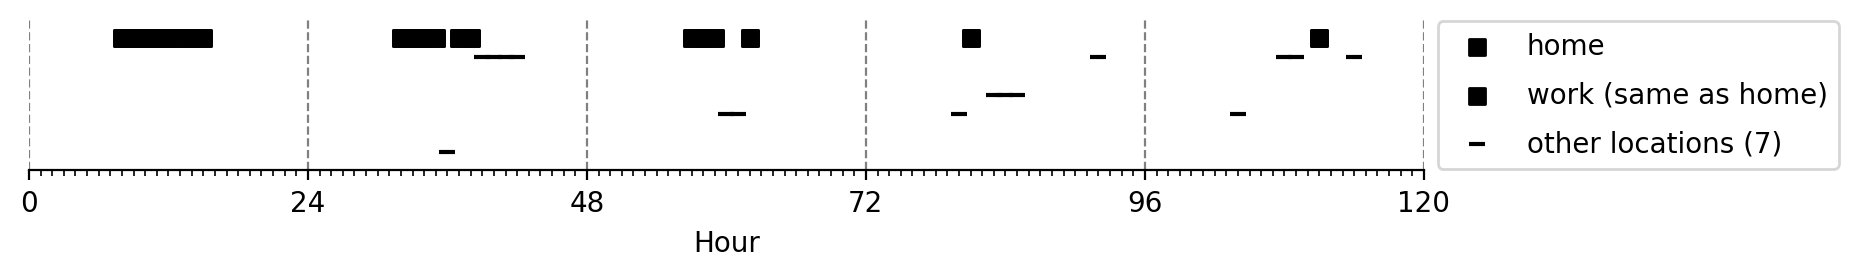

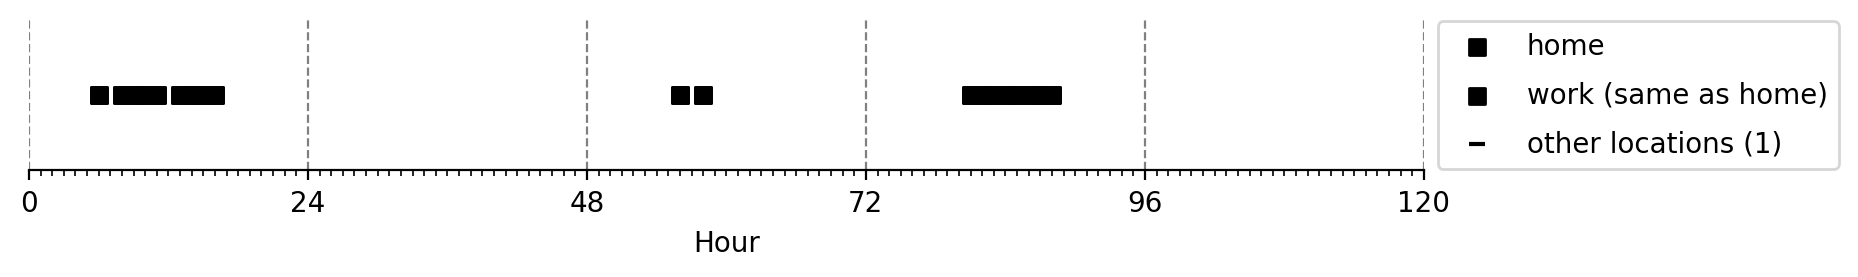

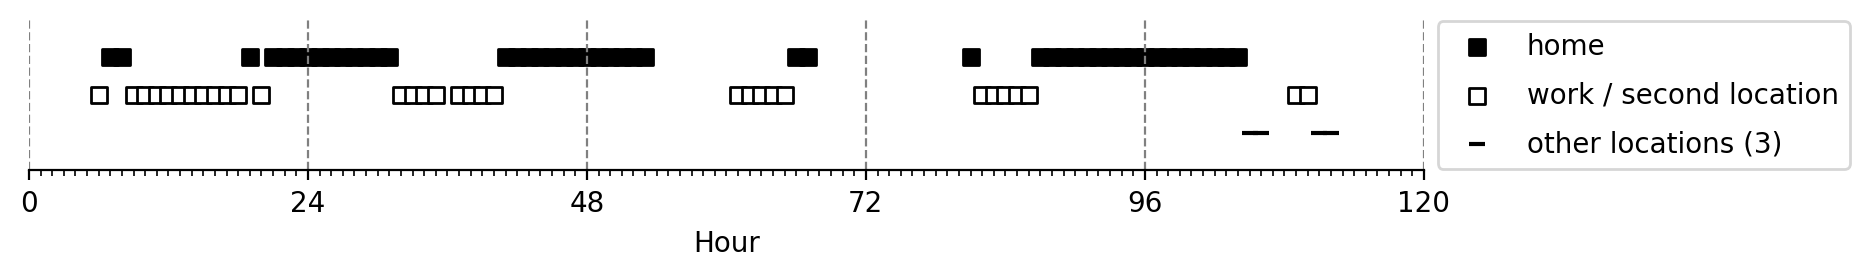

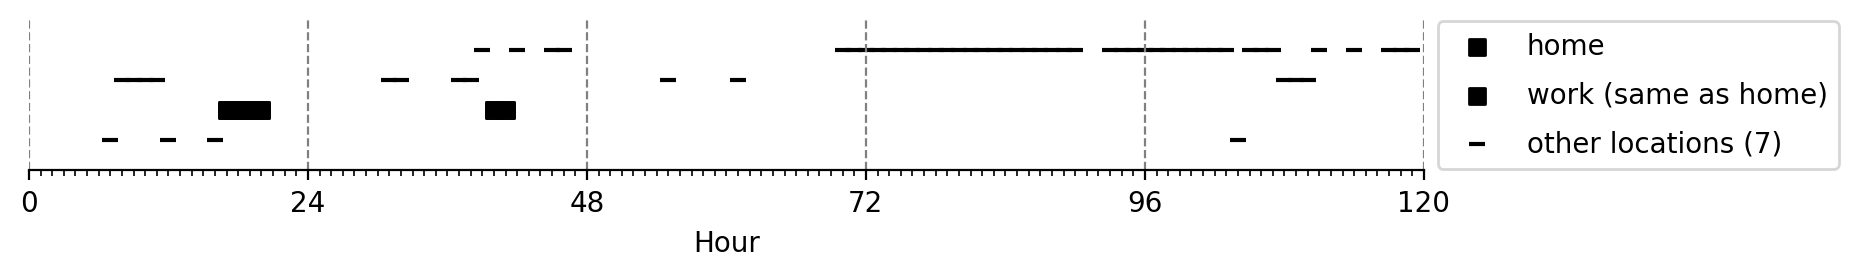

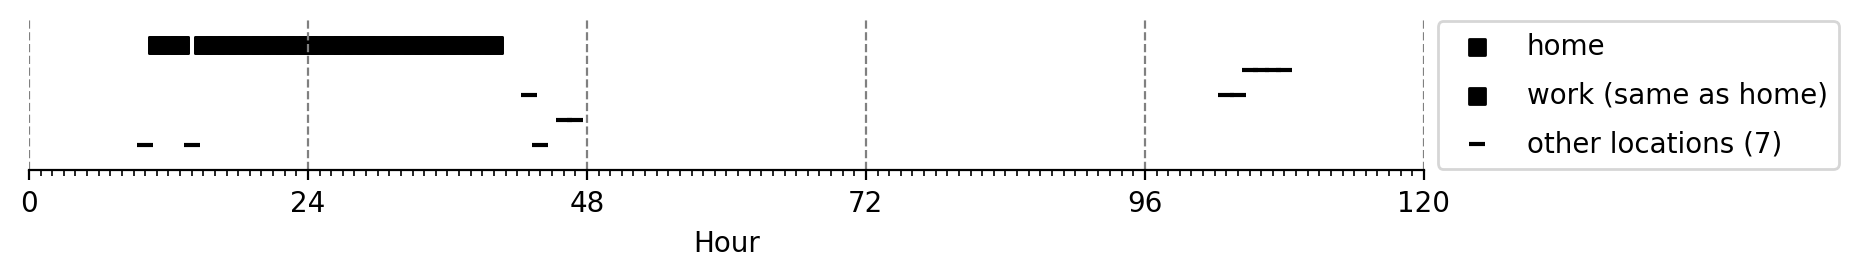

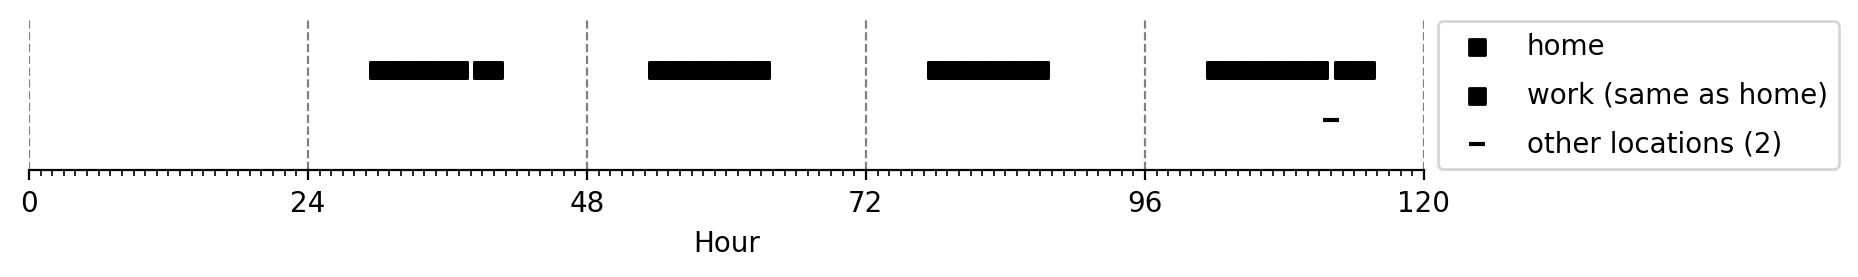

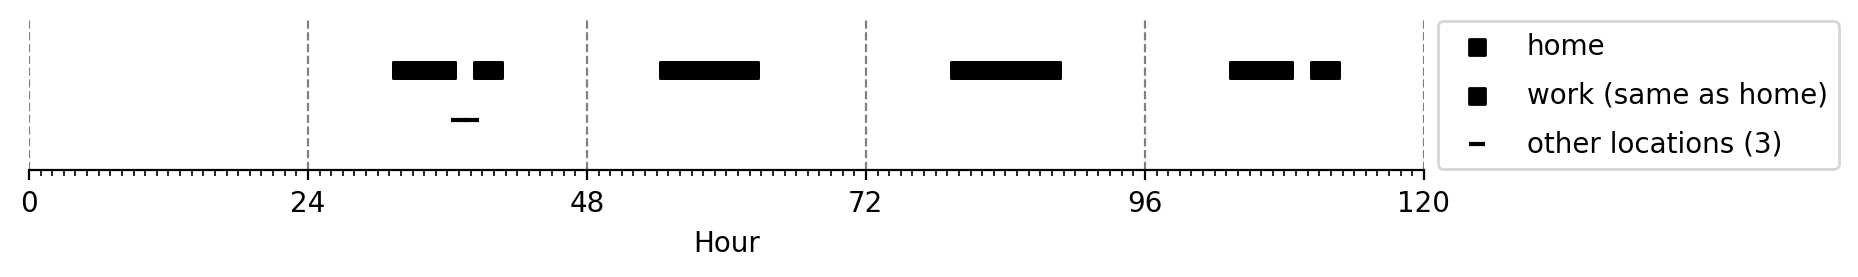

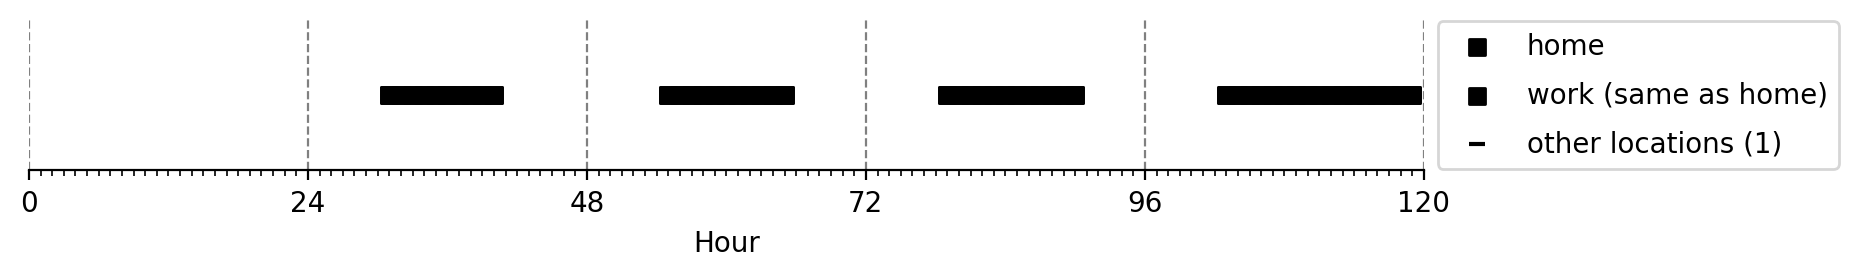

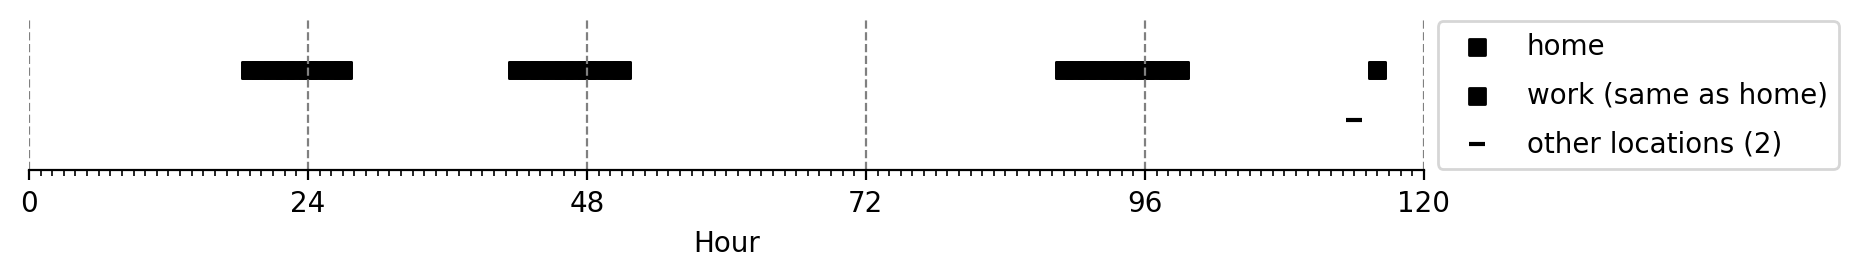

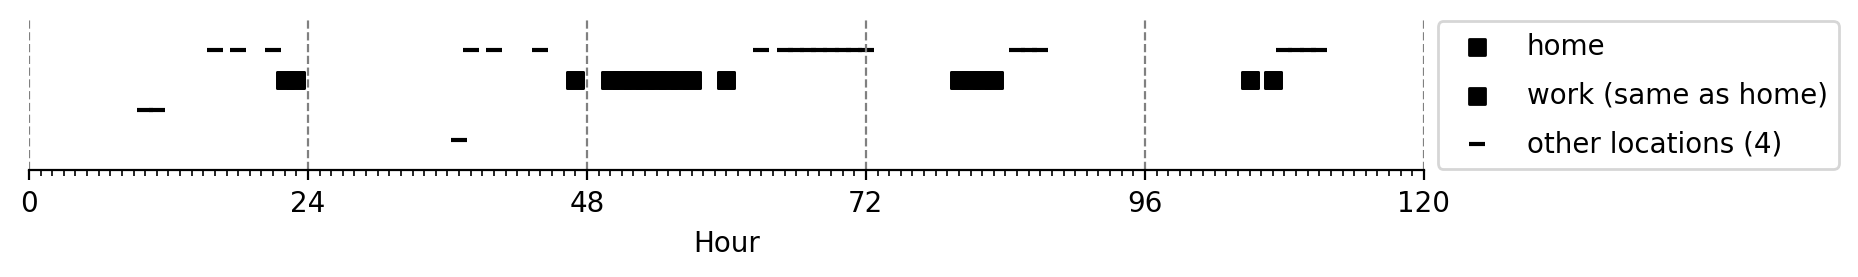

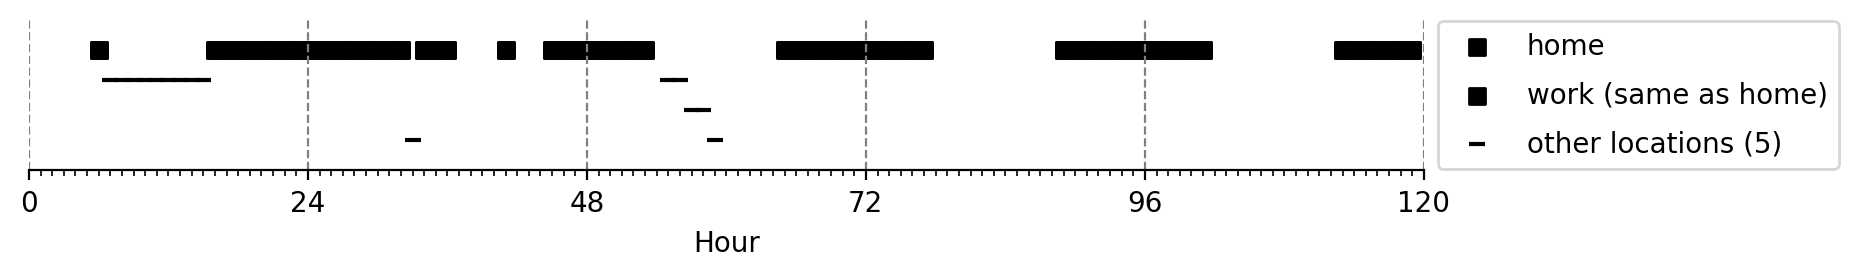

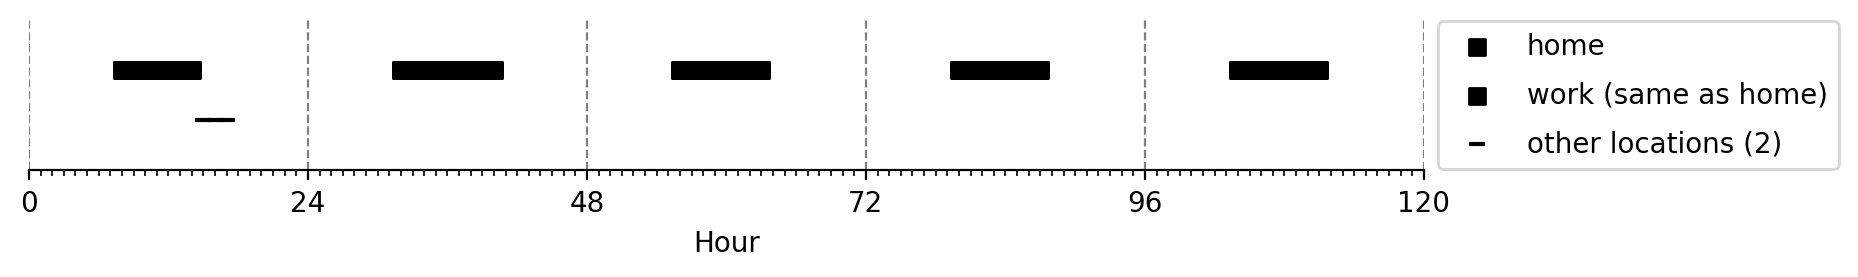

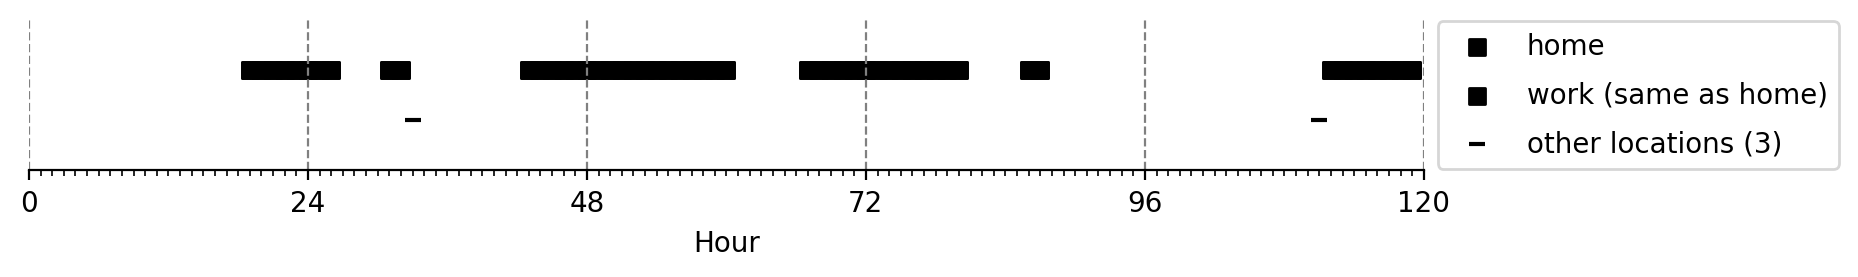

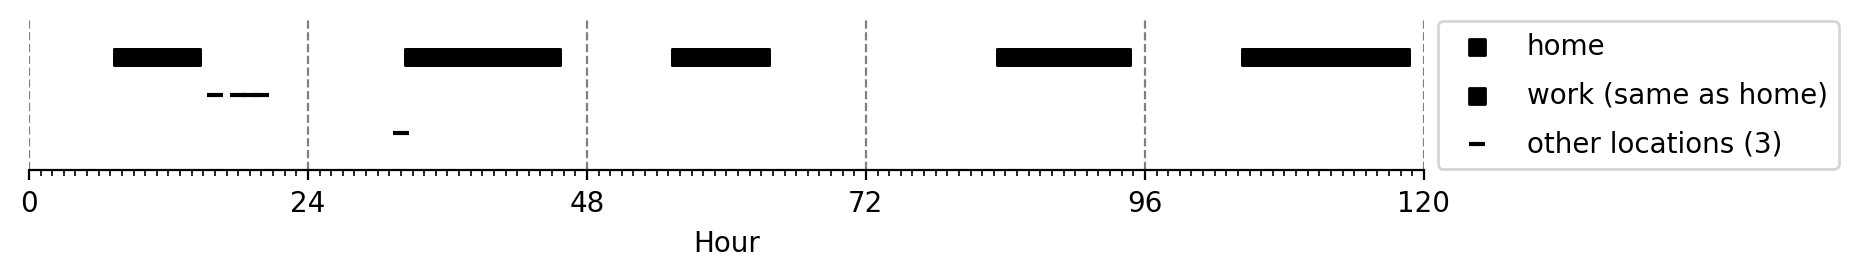

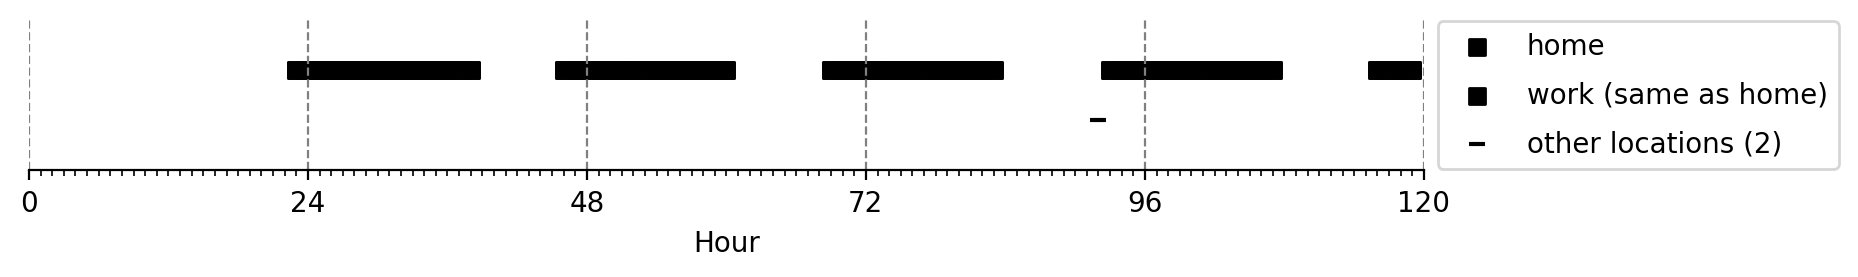

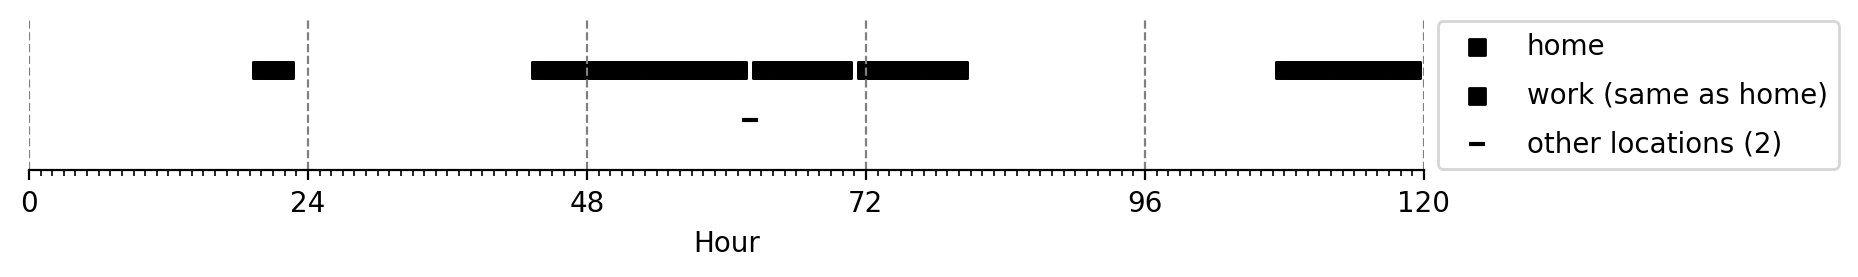

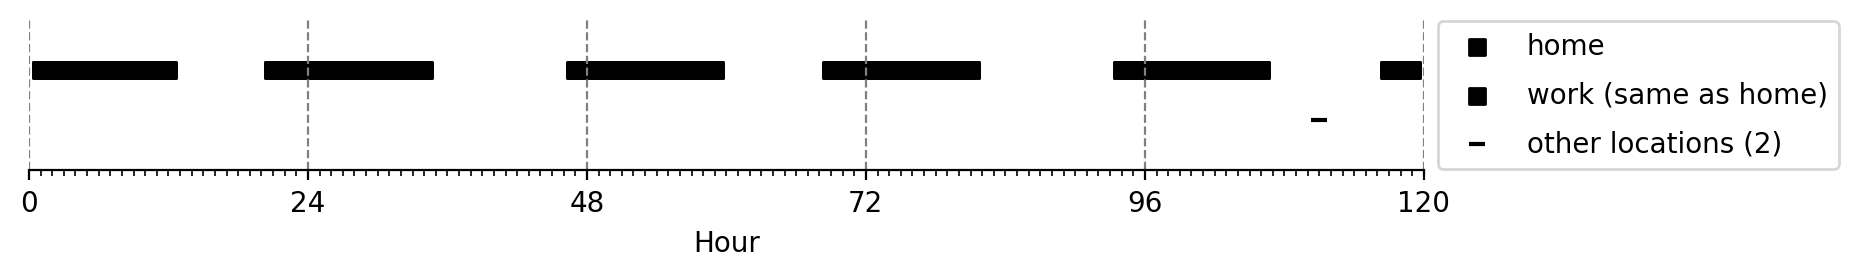

In [ ]:
print('generated sample')
for _t, t in enumerate(generated_tvs_sample[:30]):
    plot_trajectory_markers(t, by_frequency_order=True,
                            h_marker='s',w_marker='s',o_marker='_', figsize=(9,1), dpi=100)

## Privacy
Evaluate how much privacy was retained vs lost

We must evaluate that at the individual level, the real and and generated sets of trajectories are sufficiently different.  We do not want any of the generated synthetic data to leak private information about the real dataset.  As an extreme example, an over-trained model that did not generate synthetic data with sufficient randomness might generate synthetic trajectories that exactly matched real trajectories from the training set (in which case we could have simply  sampled from the real dataset)!


The primary metric we care  about is how  different the generated trajectories are from the real trajectories, compared to how different real  trajectories are  from  themselves.


### Primary Privacy evaluation: Privacy evaluation with a distance metric

We compare trajectories using edit distance as a  metric, where the edit distance is the Levenshtein edit distance between the two vectors represented as strings.

For any two trajectories, t_i and t_j, let $d(t_i, t_j)$ denote their distance.

We want this distance between generated and real trajectories to be sufficiently large.

For each generated set of trajectories, we compare each generated trajectory to each real trajectory in the training set to find the minimum edit distance between the generated  trajectory and  any real trajectory.  Call this $Min(d(t_i, t_j))$.

We transform each list of generated trajectories, T', into a list of minimum edit distances to the real trajectories.

Min(T') = [Min d(ti, t0), Min d(ti, t1), …, Min d(ti, ts)]

We evaluate models by the distribution of their Min(T').

To have a point  of comparison, we also compute the minimum edit distances for the sample of 2000 real trajectories, T, to the real trajectories. We transform the list of sampled real trajectories, Ts, into  a  list  of  minimum edit distances to other  real  trajectories.

Min(T) = [Min d(ti, t0), Min d(ti, t1), …, Min d(ti, ts)]

See https://github.com/aberke/lbs-data/blob/master/trajectory_synthesis/evaluation/evaluate_rnn.ipynb and `get_minimum_edit_distances.py` for the code that did the computation for this analysis.


In [265]:
def read_min_edit_distances_from_file(filename):
    min_edit_distances_list = []
    with open(filename, 'r') as f:
        min_edit_distances_list = [int(x) for x in f.read().strip().split()]
    return min_edit_distances_list

For the sake of comparison, note the minimum of the minimum and 10th percentile cutoff for edit distances between the real sample of vectors to any of the other real vectors (where each real vector ignores itself once).

In [326]:
# Get the minimum minimum edit distance for the real sample, as for comparison
print('real sample vs real dataset')
real_sample_min_edit_distances_filename = get_min_edit_distances_filename('real_sample_2000')
real_sample_min_edit_distances_list = read_min_edit_distances_from_file(real_sample_min_edit_distances_filename)
sample_series = pd.Series(real_sample_min_edit_distances_list)
for q in [0.1, 0.05, 0.01]:
    print('bottom %s percentile value: %s' % (int(100*q), sample_series.quantile(q)))
sample_series.describe().apply(lambda x: round(x, 2))

real sample vs real dataset
bottom 10 percentile value: 14.0
bottom 5 percentile value: 11.0
bottom 1 percentile value: 5.0


count    950.00
mean      31.40
std       13.18
min        0.00
25%       22.00
50%       32.00
75%       40.00
max       75.00
dtype: float64

In [347]:
print('synthetic sample vs real dataset')
generated_sample_min_edit_distances_filename = get_min_edit_distances_filename(generated_trajectories_sample_name)
generated_sample_min_edit_distances_list = read_min_edit_distances_from_file(generated_sample_min_edit_distances_filename)
sample_series = pd.Series(generated_sample_min_edit_distances_list)
for q in [0.1, 0.05, 0.01]:
    print('bottom %s percentile value: %s' % (int(100*q), sample_series.quantile(q)))
sample_series.describe().apply(lambda x: round(x, 2))

synthetic sample vs real dataset
bottom 10 percentile value: 14.0
bottom 5 percentile value: 10.0
bottom 1 percentile value: 5.0


count    950.00
mean      31.39
std       13.19
min        2.00
25%       22.00
50%       31.50
75%       41.00
max       88.00
dtype: float64

#### Comparing models to self

For the best models we regenerate another set of 2000 trajectories so that we have
- Tm' = original generated trajectory set
- Tm'' = regenerated trajectory set

We then compare the minimum edit distances between these two trajectory sets, and we allow all prefixes.


In [348]:
print('secondary synthetic sample vs synthetic sample')
generated_sample_min_edit_distances_vs_self_filename = get_min_edit_distances_filename(generated_trajectories_sample_name, to='self')
generated_sample_min_edit_distances_vs_self_list = read_min_edit_distances_from_file(generated_sample_min_edit_distances_vs_self_filename)
sample_series = pd.Series(generated_sample_min_edit_distances_vs_self_list)
for q in [0.1, 0.05, 0.01]:
    print('bottom %s percentile value: %s' % (int(100*q), sample_series.quantile(q)))
sample_series.describe().apply(lambda x: round(x, 2))

secondary synthetic sample vs synthetic sample
bottom 10 percentile value: 20.0
bottom 5 percentile value: 15.0
bottom 1 percentile value: 8.0


count    2000.00
mean       42.52
std        16.65
min         1.00
25%        30.00
50%        43.00
75%        54.00
max        96.00
dtype: float64

In [1303]:
def make_qq_plot(sample_x, sample_y, label_x, label_y,
                 dpi=50, figsize=(6,6),
                 title="Q-Q plot: distribution of\nminimum distances between samples", 
                 fontsize=12):
    """
    Draws a simple Q-Q plot for sample_x vs sample_y, where
    the two samples are assumed to be from the same length and
    the same distribution (plots values instead of computed quantiles).
    
    sample_x, sample_y: One-dimensional numeric arrays.
    """
    fig, ax = plt.subplots(1, figsize=figsize, dpi=dpi)
    ax.scatter(
        np.sort(sample_x), 
        np.sort(sample_y),
        s=10
    )
    ax.set_xlabel(label_x)
    ax.set_ylabel(label_y)
    ax.set_title(title, fontsize=fontsize)
    # Draw the rug plots
    rug_x_params = dict(ymin=0, ymax=0.05, c='gray', alpha=0.5)
    rug_y_params = dict(xmin=0, xmax=0.05, c='gray', alpha=0.5)
    for point in sample_x:
        ax.axvline(point, **rug_x_params)
    for point in sample_y:
        ax.axhline(point, **rug_y_params)
    # Add a 45-degree line for reference
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, x, c='gray')

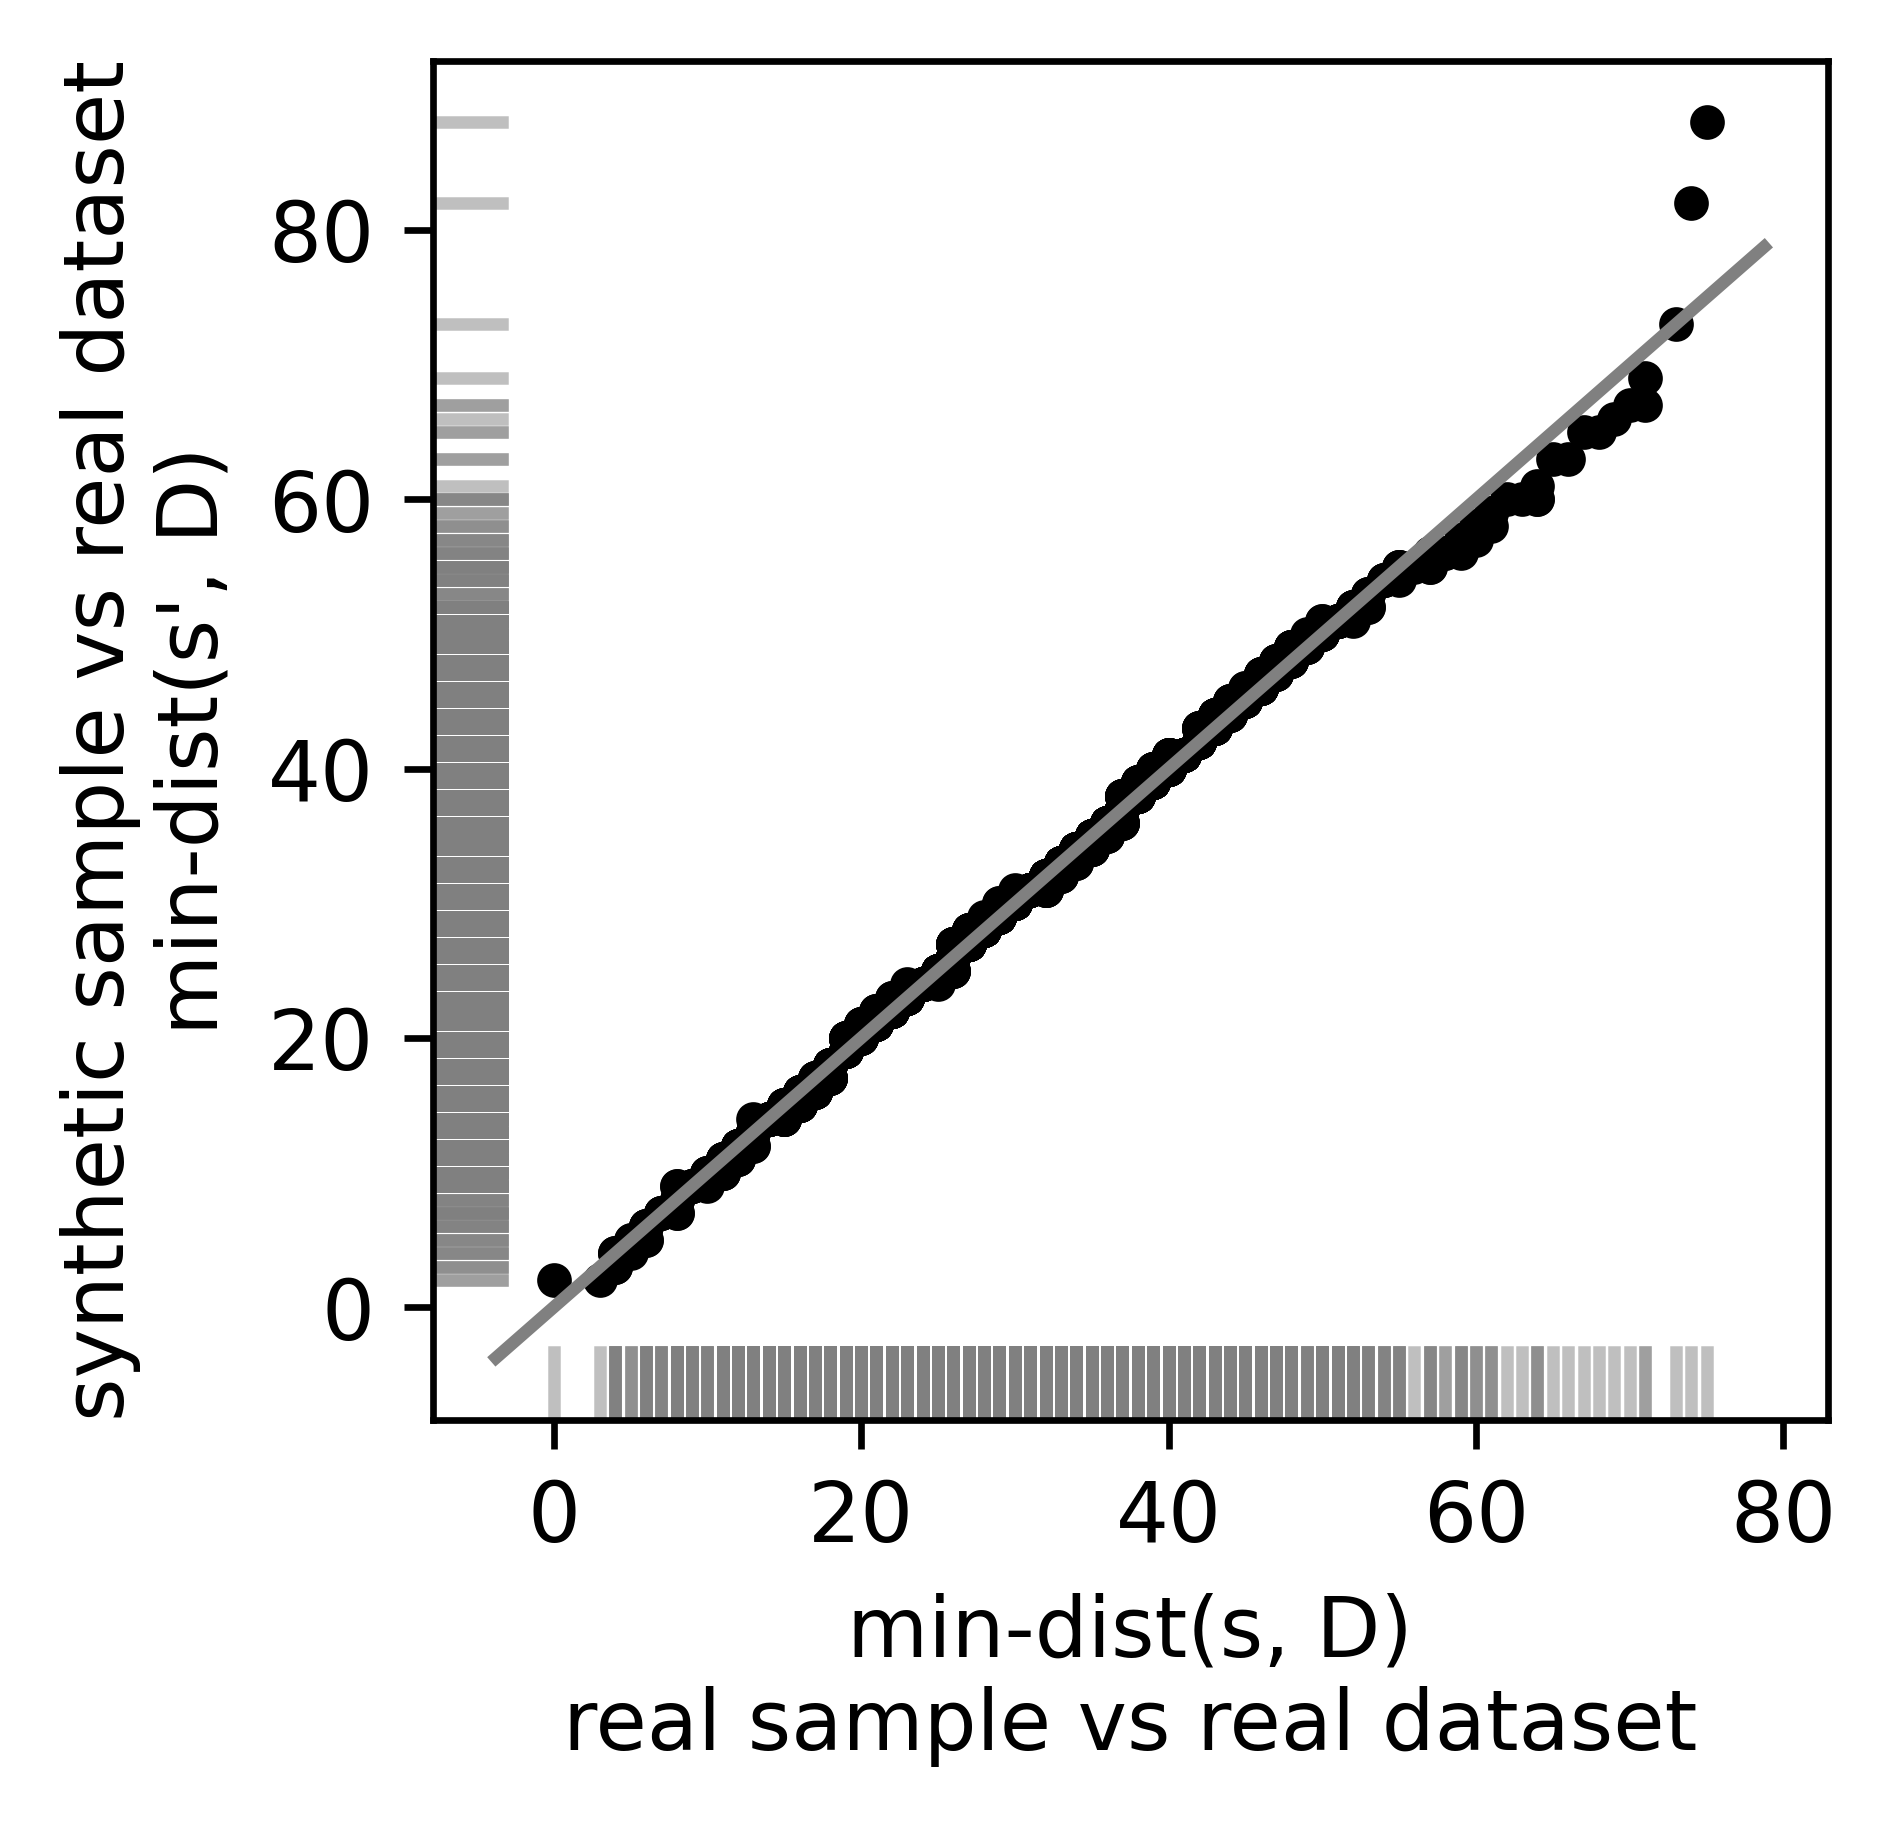

In [1320]:
make_qq_plot(
    real_sample_min_edit_distances_list,
    generated_sample_min_edit_distances_list,
    'min-dist(s, D)\nreal sample vs real dataset', "synthetic sample vs real dataset\nmin-dist(s', D)",
    figsize=(3,3), dpi=300, fontsize=10, title="",
)

We also make Q-Q plots to show the distribution of minimum edit distances between a model's two outputs to eachother compared to the minimum edit distances between the real sample and the real trajectories.

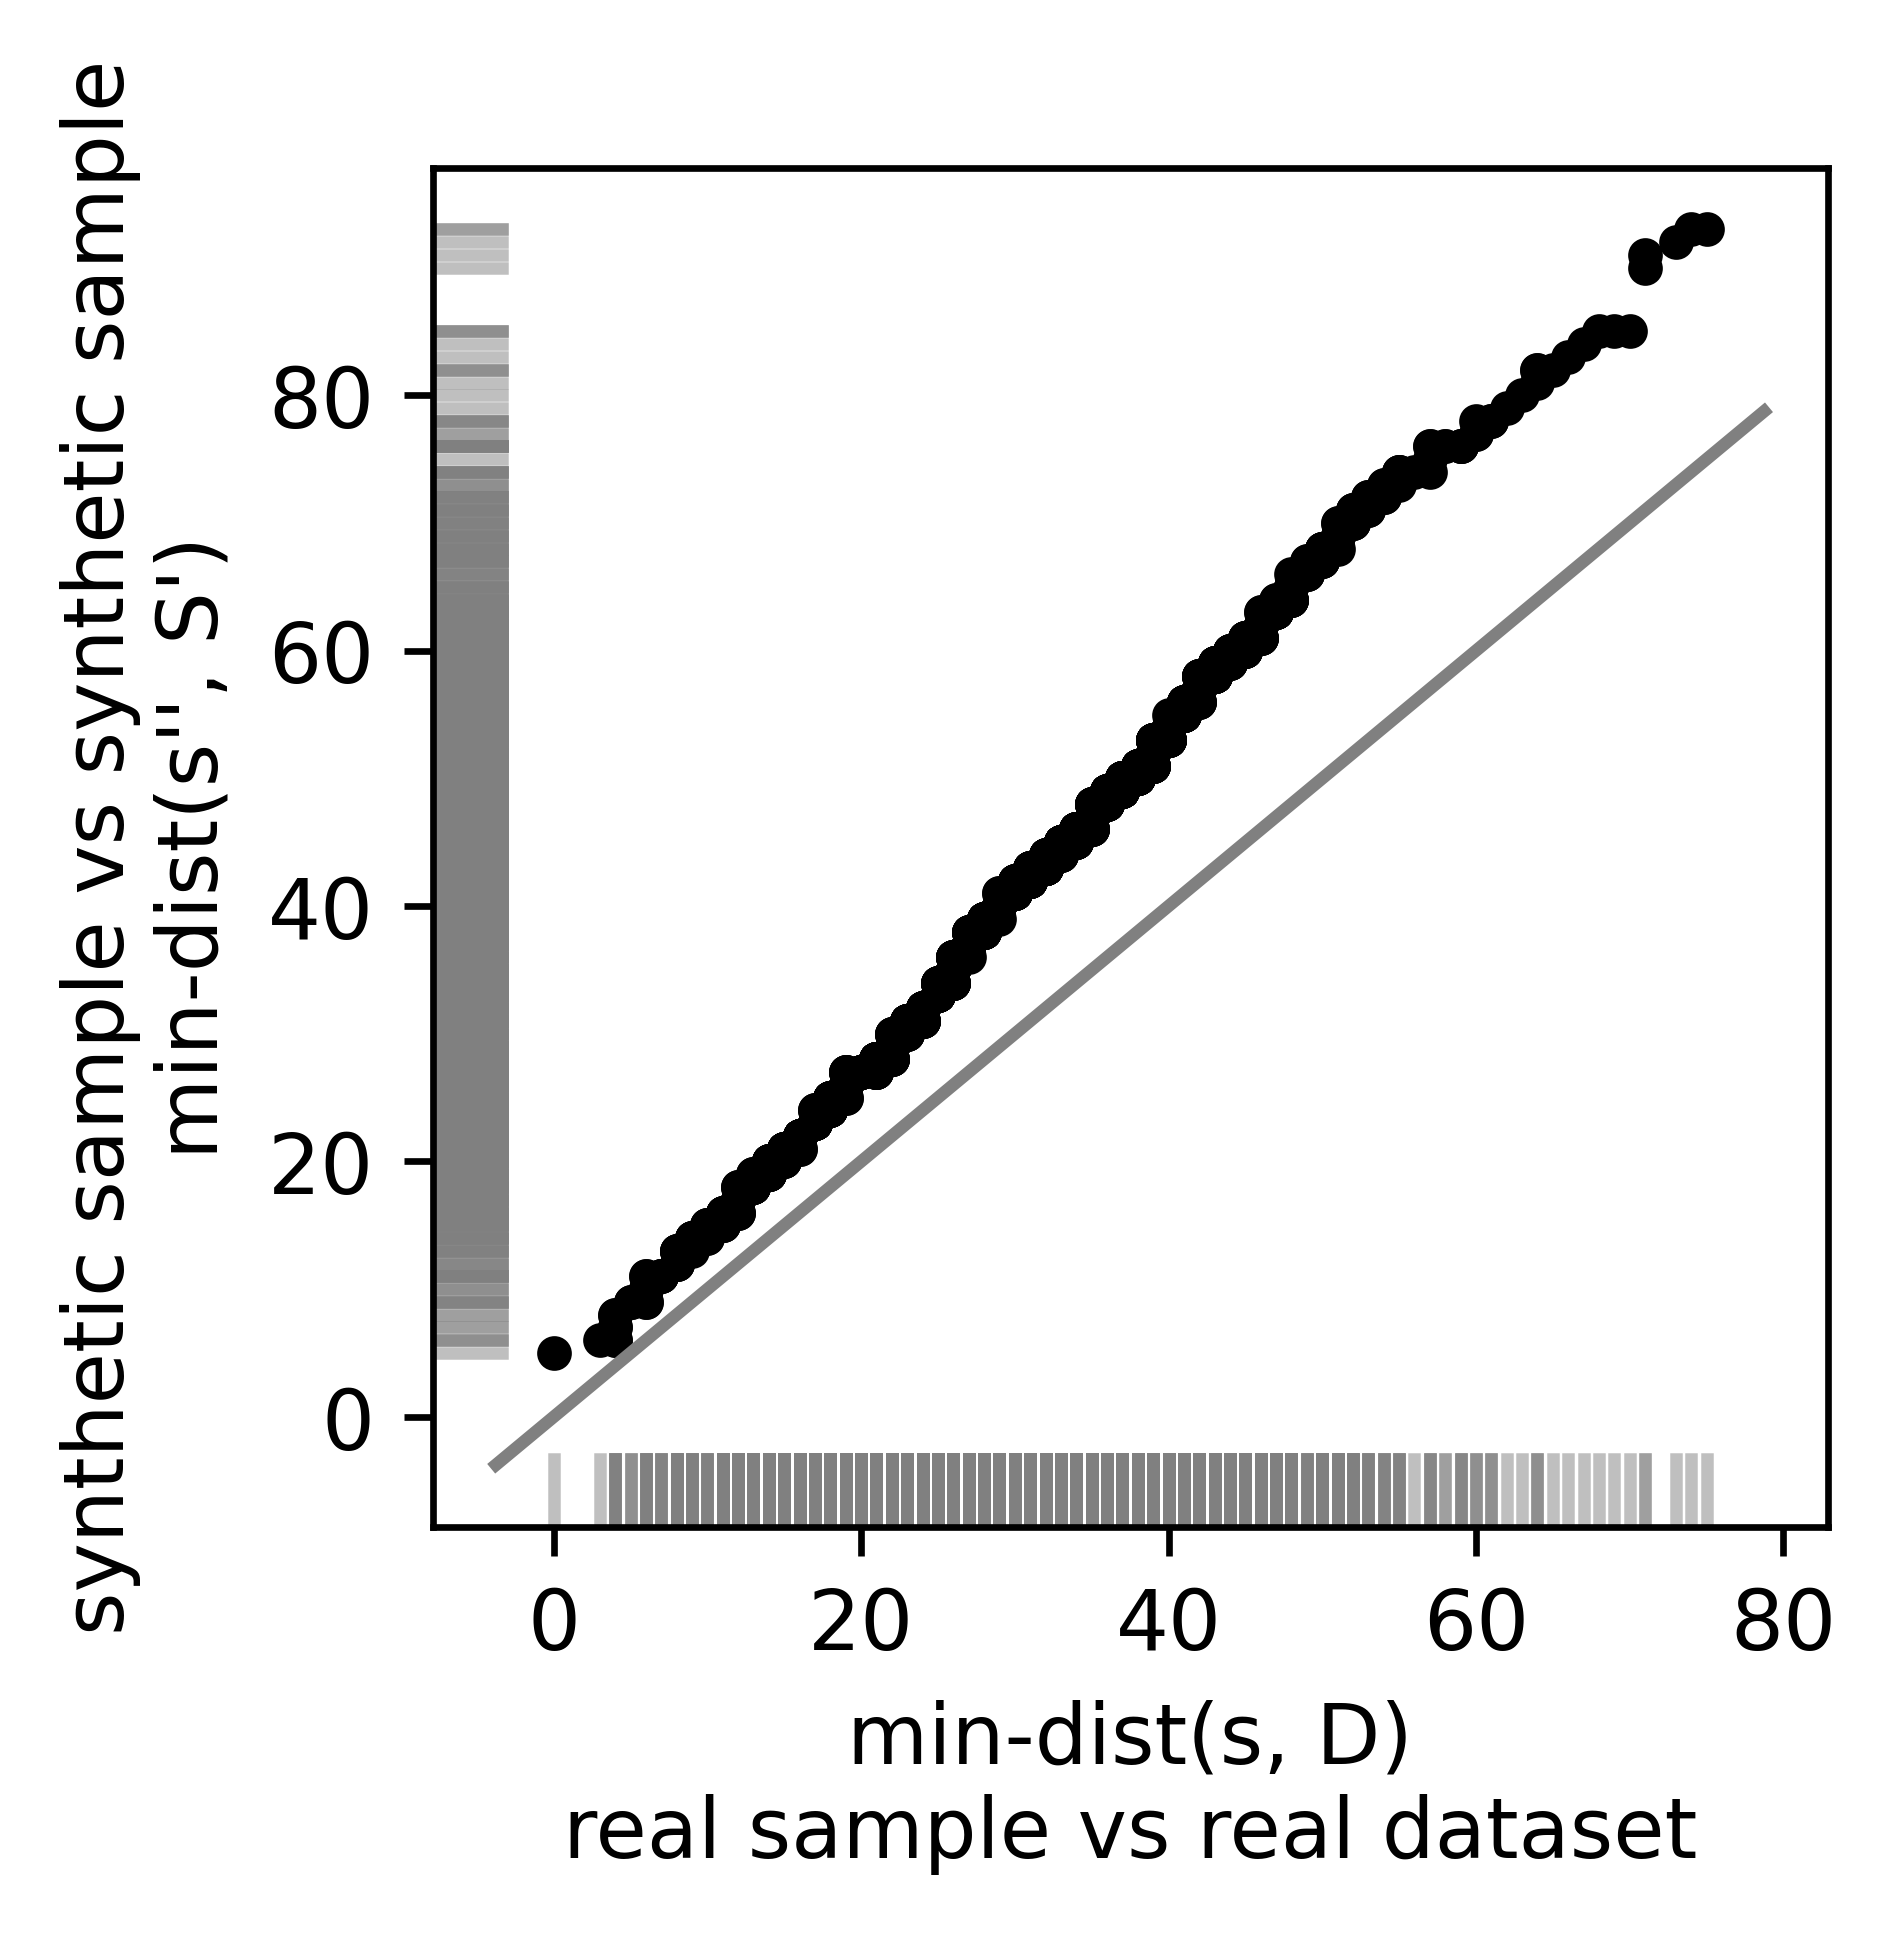

In [1322]:
L = len(real_sample_min_edit_distances_list)
make_qq_plot(
    real_sample_min_edit_distances_list,
    random.sample(generated_sample_min_edit_distances_vs_self_list, L),
            'min-dist(s, D)\nreal sample vs real dataset', "synthetic sample vs synthetic sample\nmin-dist(s'', S')",
             figsize=(3, 3), dpi=300, fontsize=10, title="")

## Utility metrics

In [795]:
# plots with consistent colors?
c_real_sample = 'black'
c_secondary_real_sample = 'gray'
c_syn_sample = 'blue'
c_random_sample = 'orange'

In [796]:
SYN_DATA_SAMPLE = 'synthetic data sample'
REAL_DATA_SAMPLE = 'secondary real data sample'
RANDOM_SAMPLE = 'random data sample'
eval_df = pd.DataFrame(columns={SYN_DATA_SAMPLE:[], REAL_DATA_SAMPLE: [], RANDOM_SAMPLE:[]})
eval_df

Empty DataFrame
Columns: [synthetic data sample, secondary real data sample, random data sample]
Index: []

### Check condition labels match output

The generated stay vectors are prefixed by home and work labels that act as conditions for generation.  For evaluation, we then check that we are able to infer the same home census area (using the same f_home, f_work function used in preprocessing) as the home prefix label we condition on. That is, if we condition on generating a synthetic stay vector for a person living in census area A, then by applying our f_home function on that generated vector, we should expect area A to be returned.

Measure:
- `home labels match portion`:  portion of vectors in generated set where the home label matches the vector data
- `work labels match portion`:  portion of vectors in generated set where the work label matches the vector data

alternative measure

- `home label error rate`:  portion of trajectories where the home label does not match the data
- `work label error rate`:  portion of trajectories where the home work does not match the data

In [797]:
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from trajectory_transformers import get_trajectory_home_label, get_trajectory_work_label

# Set up the evaluation row data that will be filled in
home_labels_match_portion = 'home labels match portion'
work_labels_match_portion = 'work labels match portion'
# define label error rate as the portion of trajectories where the data does not 
home_label_error_rate = 'home label error rate'
work_label_error_rate = 'work label error rate'

def get_vectors_with_matching_home_prefix(prefixed_vectors):
    vectors_with_matching_home_prefix = []
    for prefixed_v in prefixed_vectors:
        prefix, v = break_prefix(prefixed_v, days=TIME_PERIOD_DAYS, hours=HOURS_PER_DAY)
        home_label_prefix = prefix[0]
        inferred_home_label = get_trajectory_home_label(v)
        if inferred_home_label == home_label_prefix:
            vectors_with_matching_home_prefix.append(prefixed_v)
    return vectors_with_matching_home_prefix  

def get_vectors_with_matching_work_prefix(prefixed_vectors):
    vectors_with_matching_work_prefix = []
    for prefixed_v in prefixed_vectors:
        prefix, v = break_prefix(prefixed_v, days=TIME_PERIOD_DAYS, hours=HOURS_PER_DAY)
        work_label_prefix = prefix[1]
        inferred_work_label = get_trajectory_work_label(v)
        if inferred_work_label == work_label_prefix:
            vectors_with_matching_work_prefix.append(prefixed_v)
    return vectors_with_matching_work_prefix

# Small test of the functions:
real_vectors_with_matching_home_prefix = get_vectors_with_matching_home_prefix(real_tvs)
assert(len(real_vectors_with_matching_home_prefix) == len(real_tvs)) 
real_vectors_with_matching_work_prefix = get_vectors_with_matching_work_prefix(real_tvs)
assert(len(real_vectors_with_matching_work_prefix) == len(real_tvs))  

#### Check that home & work labels match generated vector data


- Note portion of users in that have sufficient data across 2 weeks: 14076/22673 = 0.6208265337626252

- Note how often inferred home labels change between weeks for users in real dataset:
    - portion (users with matching homes)/(total users) = (12860)/(14076) = 0.9136118215402103
- Note how often inferred work labels change between weeks for users in real dataset:
    - portion (users with matching work)/(total users) = (10676)/(14076) = 0.7584541062801933

In [798]:
N = len(generated_tvs_sample)
# eval_df.loc[home_labels_match_portion] = 0
# eval_df.loc[work_labels_match_portion] = 0
eval_df.loc[home_label_error_rate] = 0
eval_df.loc[work_label_error_rate] = 0

syn_tvs_matching_home_prefix = get_vectors_with_matching_home_prefix(generated_tvs_sample)
syn_tvs_matching_work_prefix = get_vectors_with_matching_work_prefix(generated_tvs_sample)
random_tvs_matching_home_prefix = get_vectors_with_matching_home_prefix(random_tvs_sample)
random_tvs_matching_work_prefix = get_vectors_with_matching_work_prefix(random_tvs_sample)

# eval_df.loc[home_labels_match_portion][SYN_DATA_SAMPLE] = len(syn_tvs_matching_home_prefix)/N
# eval_df.loc[work_labels_match_portion][SYN_DATA_SAMPLE] = len(syn_tvs_matching_work_prefix)/N
# eval_df.loc[home_labels_match_portion][REAL_DATA_SAMPLE] = 0.9136118215402103
# eval_df.loc[work_labels_match_portion][REAL_DATA_SAMPLE] = 0.7584541062801933
# eval_df.loc[home_labels_match_portion][RANDOM_SAMPLE] = len(random_tvs_matching_home_prefix)/N
# eval_df.loc[work_labels_match_portion][RANDOM_SAMPLE] = len(random_tvs_matching_work_prefix)/N

eval_df.loc[home_label_error_rate][SYN_DATA_SAMPLE] = 1 - len(syn_tvs_matching_home_prefix)/N
eval_df.loc[work_label_error_rate][SYN_DATA_SAMPLE] = 1 - len(syn_tvs_matching_work_prefix)/N
eval_df.loc[home_label_error_rate][REAL_DATA_SAMPLE] = 1 - 0.9136118215402103
eval_df.loc[work_label_error_rate][REAL_DATA_SAMPLE] = 1 - 0.7584541062801933
eval_df.loc[home_label_error_rate][RANDOM_SAMPLE] = 1 - len(random_tvs_matching_home_prefix)/N
eval_df.loc[work_label_error_rate][RANDOM_SAMPLE] = 1 - len(random_tvs_matching_work_prefix)/N
eval_df.astype(float).round(4)

synthetic data sample  secondary real data sample  \
home label error rate                 0.1375                      0.0864   
work label error rate                 0.2675                      0.2415   

                       random data sample  
home label error rate              0.9975  
work label error rate              0.9235

### Trip distances


We consider two consecutive stay locations in a stay trajectory sequence (i.e. bigram) as a trip.

#### Check the distribution of trip distances

We do this by looking at the geographic locations of the centroids of census areas.  We consider two consecutive stay locations in a stay vector sequence as a trip.


In [926]:
def _get_trips_for_trajectory_vector(tv):
    trips = []
    for i in range(1, len(tv)):
        if tv[i-1] != tv[i] and (tv[i-1] > 0) and (tv[i] > 0):
            trips += [(tuple((tv[i-1], tv[i])))]
    return trips

def _get_trips_for_trajectory_vectors(tvs):
    tvs_trips = []
    for t in tvs:
        tvs_trips += _get_trips_for_trajectory_vector(t)
    return tvs_trips

def get_trips_for_trajectory_vectors(tvs):
    return _get_trips_for_trajectory_vectors(get_unprefixed_vectors(tvs))

Make a mapping of {(origin, distination): distance}

Where origin, and destination are census geographical areas and distance is miles from the centroid of origin to the centroid of destination.

Include all O-D pairs.


In [773]:
import csv
import json

label_to_int_map_filename = '../data/relabeled_trajectories_1_workweek_label_to_int_map.json'


def get_int_to_census_area_label_map():
    label_to_int_map = None
    with open(label_to_int_map_filename) as json_file:
        label_to_int_map = json.load(json_file)

    label_to_int_map[None] = label_to_int_map['null']
    del label_to_int_map['null']

    int_to_label_map = {i:label for label, i in label_to_int_map.items()}
    assert(len(int_to_label_map) == len(label_to_int_map))
    return int_to_label_map

In [774]:
int_to_census_area_label_map = get_int_to_census_area_label_map()

shape of geoid 25017310300


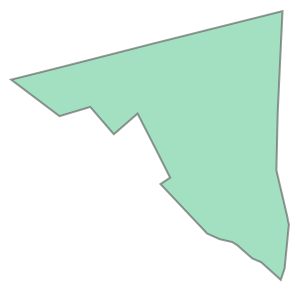

In [775]:
from shapely.geometry import shape

# create mapping from geoid to geometry
# the units in the map projection used are meters.  These are then mapped to miles.
tracts=json.load(open('./check_bigrams/ma_tracts.geojson'))
METERS_TO_MILES_MULT = 0.000621371

# create mapping from geoid to geometry
geoid_to_geometry={}
for f_ind,feature in enumerate(tracts['features']):
    geoid=feature['properties']['GEO_ID'].split('US')[1]
    geoid_to_geometry[geoid]=feature['geometry']

geoid = str(int_to_census_area_label_map[random.choice(list(vocab))])
print('shape of geoid %s' % geoid)
shape(geoid_to_geometry[geoid])

In [737]:
# Make a mapping of {(origin, distination): distance}
# Where origin, and destination are census geographical areas 
# and distance is miles from the centroid of origin to the centroid of destination.
O_D_distance_map = {}
for o_area in sorted(list(vocab)[1:]): # skip area 0
    for d_area in sorted(list(vocab)[1:]):
        if (d_area, o_area) in O_D_distance_map:
            O_D_distance_map[(o_area, d_area)] = O_D_distance_map[(d_area, o_area)]
            continue
        O_D_distance_map[(o_area, d_area)] = shape(
            geoid_to_geometry[str(int_to_census_area_label_map[o_area])]
        ).centroid.distance(shape(
            geoid_to_geometry[str(int_to_census_area_label_map[d_area])]
        ).centroid)*METERS_TO_MILES_MULT
        

What are the top distances between areas? What is the overall distribution?

In [738]:
pd.Series(list(O_D_distance_map.values())).describe()

count    423801.000000
mean         13.992408
std           9.026997
min           0.000000
25%           6.558603
50%          12.374176
75%          20.297241
max          59.661412
dtype: float64

In [927]:
def get_trips_distances(tvs):
    trips = get_trips_for_trajectory_vectors(tvs)
    trips_distances = [O_D_distance_map[trip] for trip in trips]
    return trips_distances

In [928]:
real_trips_distances = get_trips_distances(real_tvs)
generated_sample_trips_distances = get_trips_distances(generated_tvs_sample)

In [929]:
secondary_real_sample_trips_distances = get_trips_distances(secondary_real_tvs_sample)
random_sample_trips_distances = get_trips_distances(random_tvs_sample)

In [930]:
xlabel = "$d$: trip distance (miles)"
ylabel = "$P( d )$"

KL divergence

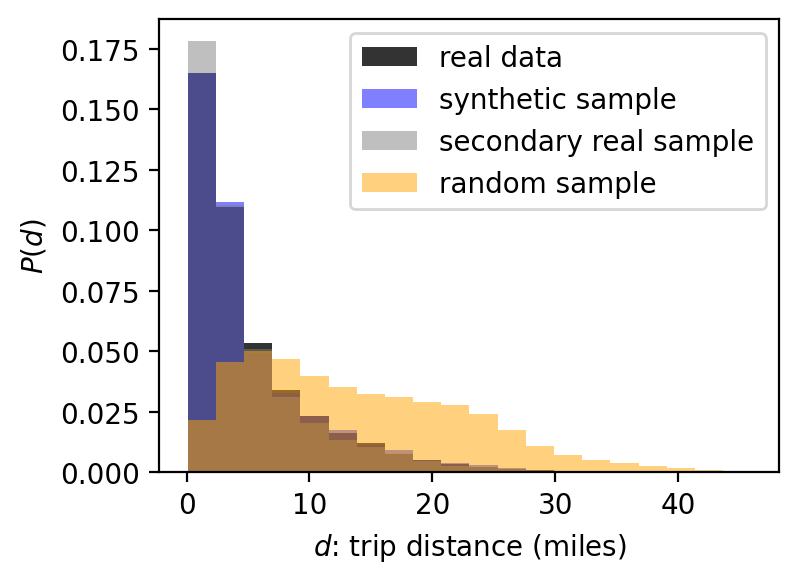

In [931]:
n_bins = 20
fig, ax = plt.subplots(figsize=(4,3), dpi=100)#200)
n_real_tvs, bins_real_tvs, _ = ax.hist(
    real_trajectories_trips_distances, label="real data",
    bins=n_bins, density=True, color=c_real_sample, alpha=0.8
)
n_generated_sample_tvs, bins_generated_sample_tvs, _ = ax.hist(
    generated_trajectories_sample_trips_distances, label="synthetic sample",
    bins=bins_real_tvs, density=True, color=c_syn_sample, alpha=0.5
)
n_secondary_real_sample_tvs, bins_secondary_real_sample_tvs, _ = ax.hist(
    secondary_real_sample_trips_distances, label="secondary real sample",
    bins=bins_real_tvs, density=True, color=c_secondary_real_sample, alpha=0.5
)
n_random_sample_tvs, bins_random_sample_tvs, _ = ax.hist(
    random_sample_trips_distances, label="random sample",
    bins=bins_real_tvs, density=True, color=c_random_sample, alpha=0.5
)
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
_ = ax.legend()

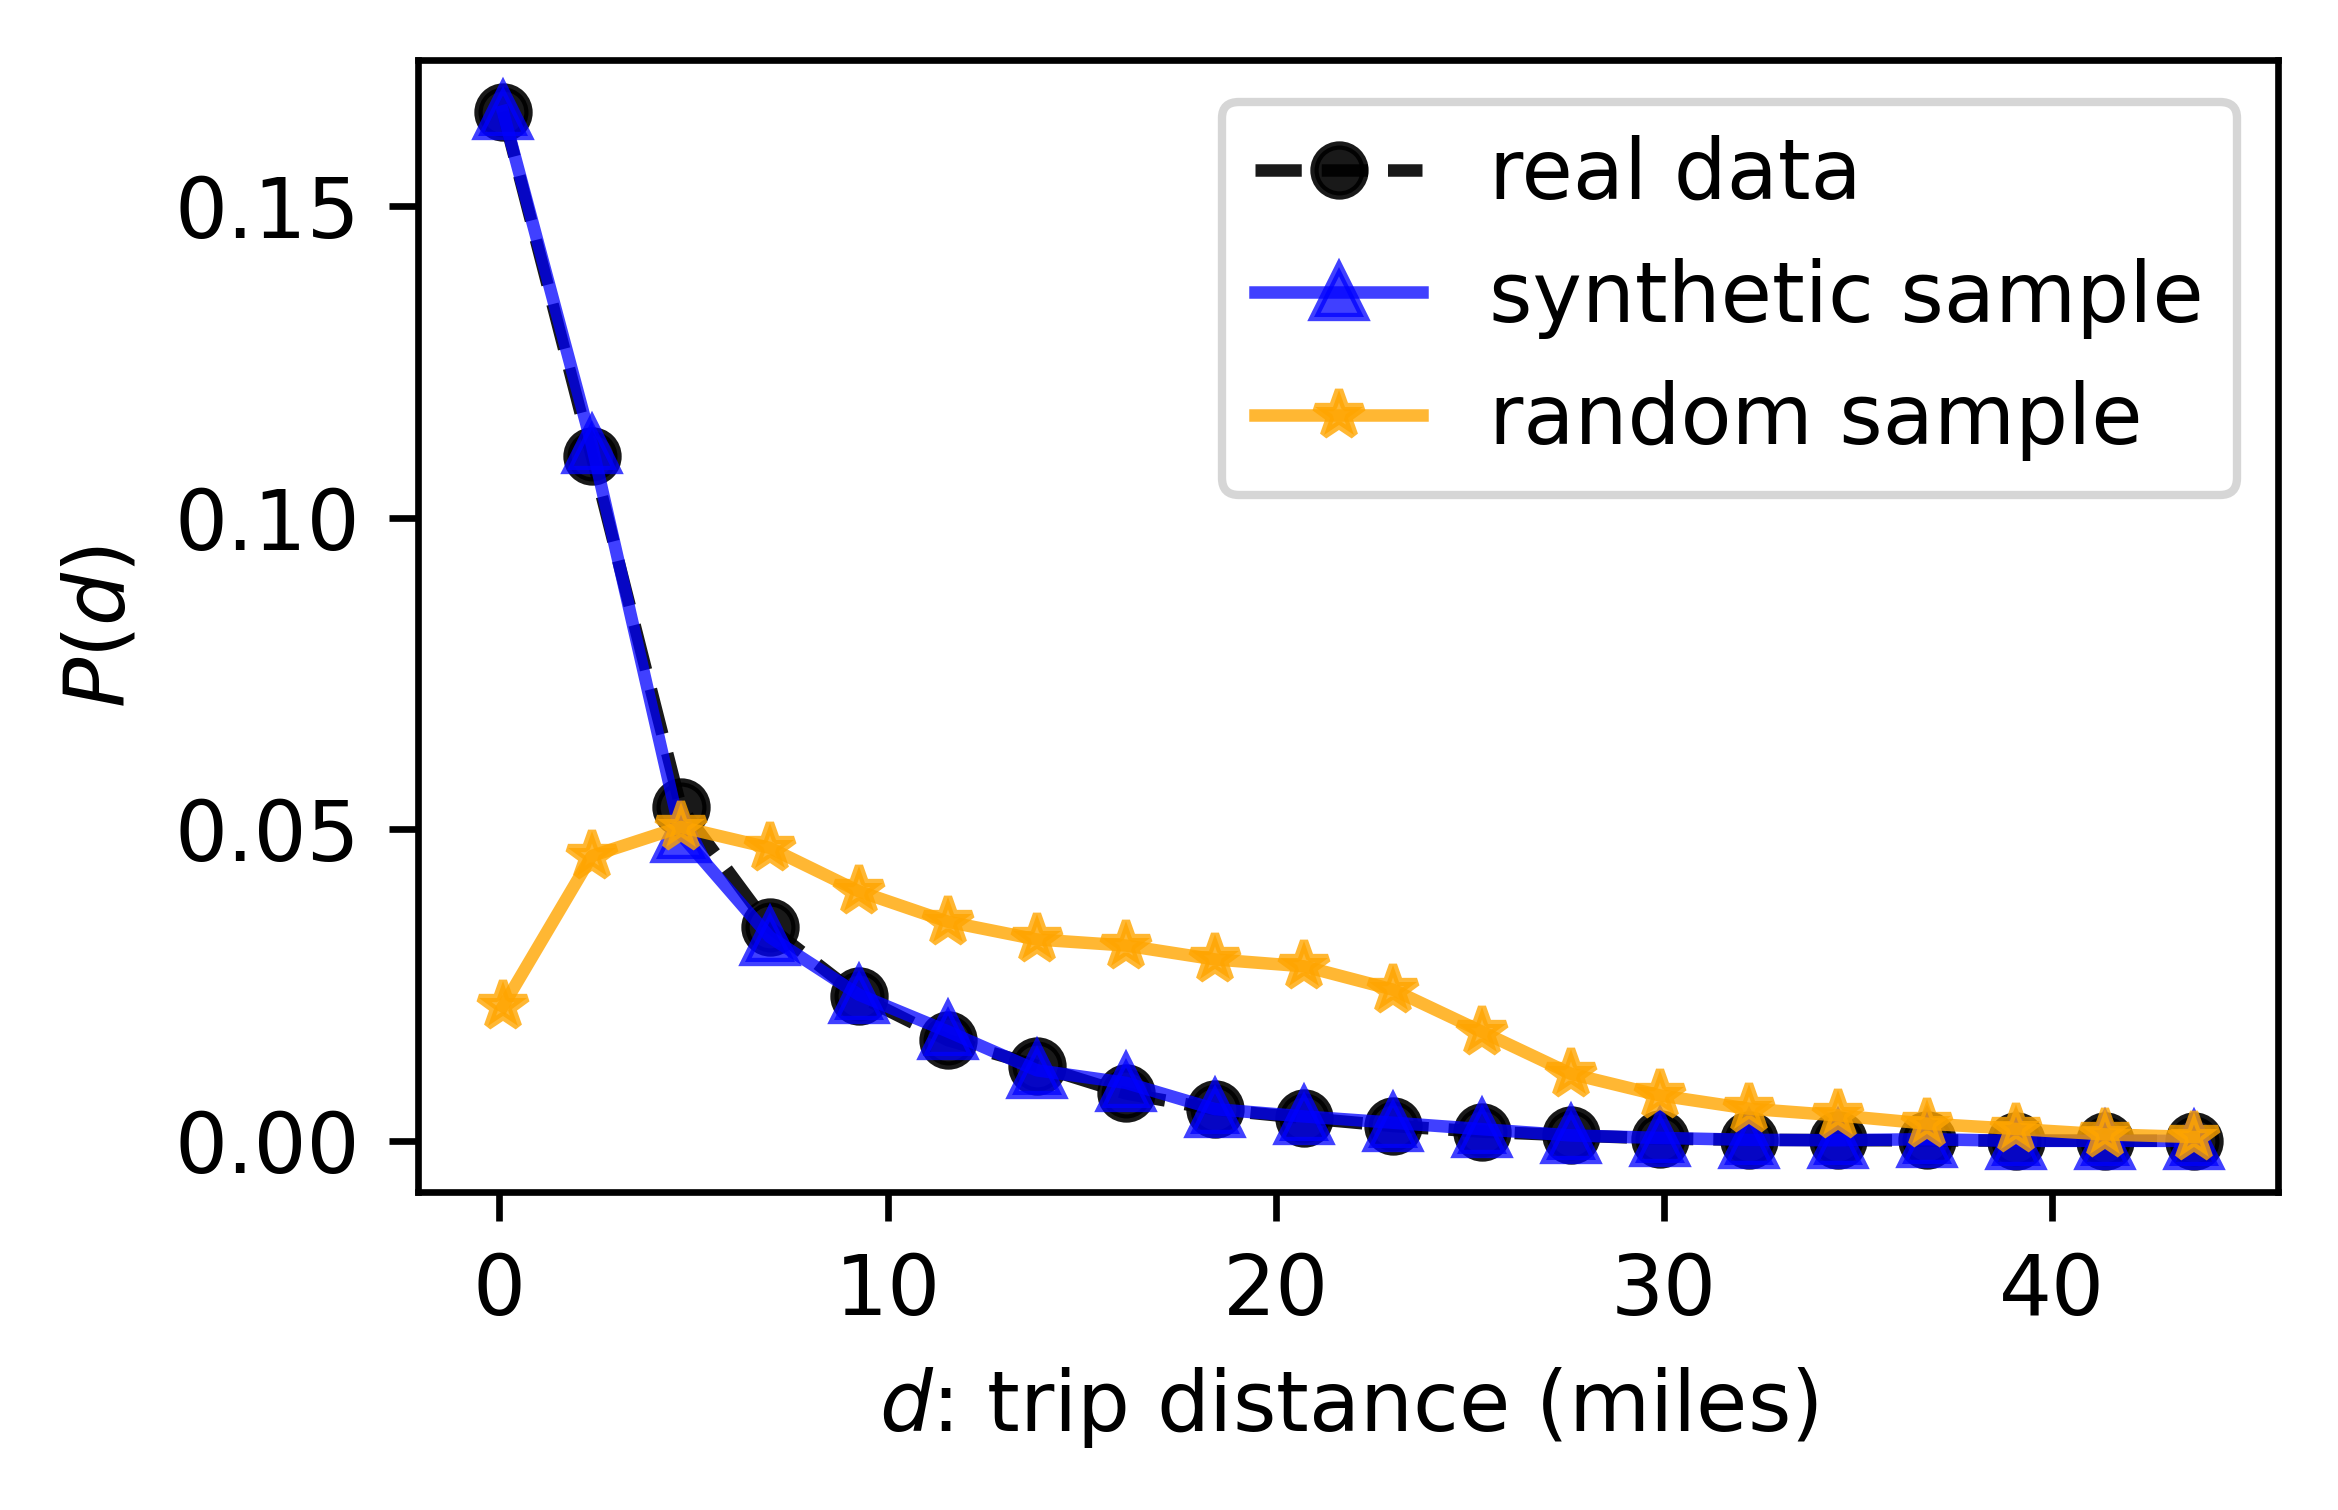

In [1325]:
fig, ax = plt.subplots(figsize=(4, 2.5), dpi=300)
ax.plot(bins_real_tvs[:-1], n_real_tvs, "--", label="real data",
        color=c_real_sample, marker="o", alpha=0.9)
ax.plot(bins_generated_sample_tvs[:-1], n_generated_sample_tvs, label="synthetic sample",
        marker="^", color=c_syn_sample, alpha=0.75)
# ax.plot(bins_secondary_real_sample_tvs[:-1], n_secondary_real_sample_tvs,
#         label="secondary real sample",
#         marker="s", color=c_secondary_real_sample, alpha=0.6)
ax.plot(bins_random_sample_tvs[:-1], n_random_sample_tvs, label="random sample",
        marker="*", color=c_random_sample, alpha=0.8)
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
_ = ax.legend()

Calculate RMSE and KL-divergence between real data and generated sample.

For reference, Pappalardo et al make the same RMSE and KL-divergence calculation for a variety of the models they test. Their range of results are shown below for their tests with *GPS* data (they do similar experiments with CDRS).
- RMSE = 0.0031 to .0258
- KL = .0420 to 1.6628

Pappalardo, L. and Simini, F., 2018. Data-driven generation of spatio-temporal routines in human mobility. Data Mining and Knowledge Discovery, 32(3), pp.787-829.
https://doi.org/10.1007/s10618-017-0548-4

In [934]:
def compute_D_KL(P, Q):
    return (-1)*sum([p*np.log(q) for p,q in zip(P,Q) if (p != 0 and q != 0)]) \
        + sum([p*np.log(p) for p in P if (p!=0)])

# test with example from wikipedia LOL
# https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence#Basic_example
P = [9/25,12/25,4/25]
Q = [1/3,1/3,1/3]
assert(round(compute_D_KL(P,Q), 4) == 0.0853)

In [936]:
print('trip distance KL-divergence with discrete probability distribution generated by  %s bins' % n_bins)
trip_dist_D_KL = 'Trip distance (KL-divergence)'
eval_df.loc[trip_dist_D_KL] = ''
eval_df.loc[trip_dist_D_KL][SYN_DATA_SAMPLE] = compute_D_KL(n_generated_sample_tvs, n_real_tvs)
eval_df.loc[trip_dist_D_KL][REAL_DATA_SAMPLE] = compute_D_KL(n_secondary_real_sample_tvs, n_real_tvs)
eval_df.loc[trip_dist_D_KL][RANDOM_SAMPLE] = compute_D_KL(n_random_sample_tvs, n_real_tvs)
eval_df.astype(float).round(4)

trip distance KL-divergence with discrete probability distribution generated by  20 bins


synthetic data sample  \
home label error rate                         0.1375   
work label error rate                         0.2675   
Trip distance (KL-divergence)                 0.0008   

                               secondary real data sample  random data sample  
home label error rate                              0.0864              0.9975  
work label error rate                              0.2415              0.9235  
Trip distance (KL-divergence)                      0.0015              0.3655

In [937]:
print('n=%s'%n_bins)
RMSE = np.sqrt(sum([(n_generated_sample_tvs[i] - n_real_tvs[i])**2 for i in range(n_bins)])/n_bins)
RMSE

n=20


0.0012542686305657739

### Frequent pattern (FP) mining


$FP  AvRE = \frac{\sum_P{\frac{|sup(S,P) - sup(S',P)|}{supp(S, P)}}}{k}$

In [938]:
"""
make a table:
pattern, real sample, synthetic sample, secondary sample, random sample

where 
- a pattern is a trip: (L1,L2)
- column values are the frequencies of the pattern the the corresponding sample

sort by real sample and select top k

compute FP average relative error (FP avRE)
"""
k=100

real_sample_trips = get_trips_for_trajectory_vectors(real_tvs_sample)
generated_sample_trips = get_trips_for_trajectory_vectors(generated_tvs_sample)
secondary_real_sample_trips = get_trips_for_trajectory_vectors(secondary_real_tvs_sample)
random_sample_trips = get_trips_for_trajectory_vectors(random_tvs_sample)

FP = pd.Series(real_sample_trips).value_counts().rename('real data').to_frame()
FP[SYN_DATA_SAMPLE] = FP.index.map(pd.Series(generated_sample_trips).value_counts().to_dict())
FP[REAL_DATA_SAMPLE] = FP.index.map(pd.Series(secondary_real_sample_trips).value_counts().to_dict())
FP[RANDOM_SAMPLE] = FP.index.map(pd.Series(random_sample_trips).value_counts().to_dict()) 
FP = FP.sort_values('real data', ascending=False).head(k).fillna(0)
FP.sort_values('real data', ascending=False).head()

real data  synthetic data sample  secondary real data sample  \
(8, 21)            16                   21.0                        23.0   
(281, 434)         15                    6.0                        10.0   
(22, 21)           14                    6.0                        10.0   
(21, 8)            14                   23.0                        25.0   
(21, 22)           13                    9.0                         8.0   

            random data sample  
(8, 21)                    0.0  
(281, 434)                 1.0  
(22, 21)                   0.0  
(21, 8)                    1.0  
(21, 22)                   0.0

In [939]:
FP.describe()

real data  synthetic data sample  secondary real data sample  \
count  100.000000             100.000000                  100.000000   
mean     7.520000               5.280000                    5.780000   
std      2.139008               7.105383                    4.210569   
min      6.000000               0.000000                    0.000000   
25%      6.000000               2.000000                    3.000000   
50%      7.000000               4.000000                    6.000000   
75%      8.000000               6.000000                    7.000000   
max     16.000000              48.000000                   25.000000   

       random data sample  
count          100.000000  
mean             0.430000  
std              0.623691  
min              0.000000  
25%              0.000000  
50%              0.000000  
75%              1.000000  
max              2.000000

In [940]:
sample_names = [SYN_DATA_SAMPLE, REAL_DATA_SAMPLE, RANDOM_SAMPLE]
for sample in sample_names:
    FP['FP RE: ' + sample] = np.abs(FP['real data'] - FP[sample])/FP['real data']
FP.head()

real data  synthetic data sample  secondary real data sample  \
(8, 21)            16                   21.0                        23.0   
(281, 434)         15                    6.0                        10.0   
(22, 21)           14                    6.0                        10.0   
(21, 8)            14                   23.0                        25.0   
(21, 22)           13                    9.0                         8.0   

            random data sample  FP RE: synthetic data sample  \
(8, 21)                    0.0                      0.312500   
(281, 434)                 1.0                      0.600000   
(22, 21)                   0.0                      0.571429   
(21, 8)                    1.0                      0.642857   
(21, 22)                   0.0                      0.307692   

            FP RE: secondary real data sample  FP RE: random data sample  
(8, 21)                              0.437500                   1.000000  
(281, 434)                           0.333333                   0.933333  
(22, 21)                             0.285714                   1.000000  
(21, 8)                              0.785714                   0.928571  
(21, 22)                             0.384615                   1.000000

In [1012]:
# FP AvRE
eval_df.loc['FP AvRE'] = FP[
    ['FP RE: ' + sample for sample in sample_names]
].mean().values
eval_df

synthetic data sample  \
home label error rate                        0.1375   
work label error rate                        0.2675   
Trip distance (KL-divergence)              0.000847   
FP AvRE                                     0.55871   

                              secondary real data sample random data sample  
home label error rate                           0.086388             0.9975  
work label error rate                           0.241546             0.9235  
Trip distance (KL-divergence)                   0.001505           0.365503  
FP AvRE                                         0.357381           0.941059

Related works plot the FP AvRE by query size (grouped)

In [942]:
query_size_bins = [6,8,10,12,14,16]
FP['query size bin'] = FP['real data'].apply(lambda q: q if q%2==0 else q+1)
avREs = FP.groupby('query size bin').mean()[['FP RE: ' + sample for sample in sample_names]]
avREs

FP RE: synthetic data sample  \
query size bin                                 
6                                   0.440171   
8                                   0.567308   
10                                  0.545299   
12                                  1.454545   
14                                  1.053571   
16                                  0.456250   

                FP RE: secondary real data sample  FP RE: random data sample  
query size bin                                                                
6                                        0.341880                   0.940171  
8                                        0.409799                   0.945055  
10                                       0.216239                   0.908547  
12                                       0.333333                   0.969697  
14                                       0.460165                   0.982143  
16                                       0.385417                   0.966667

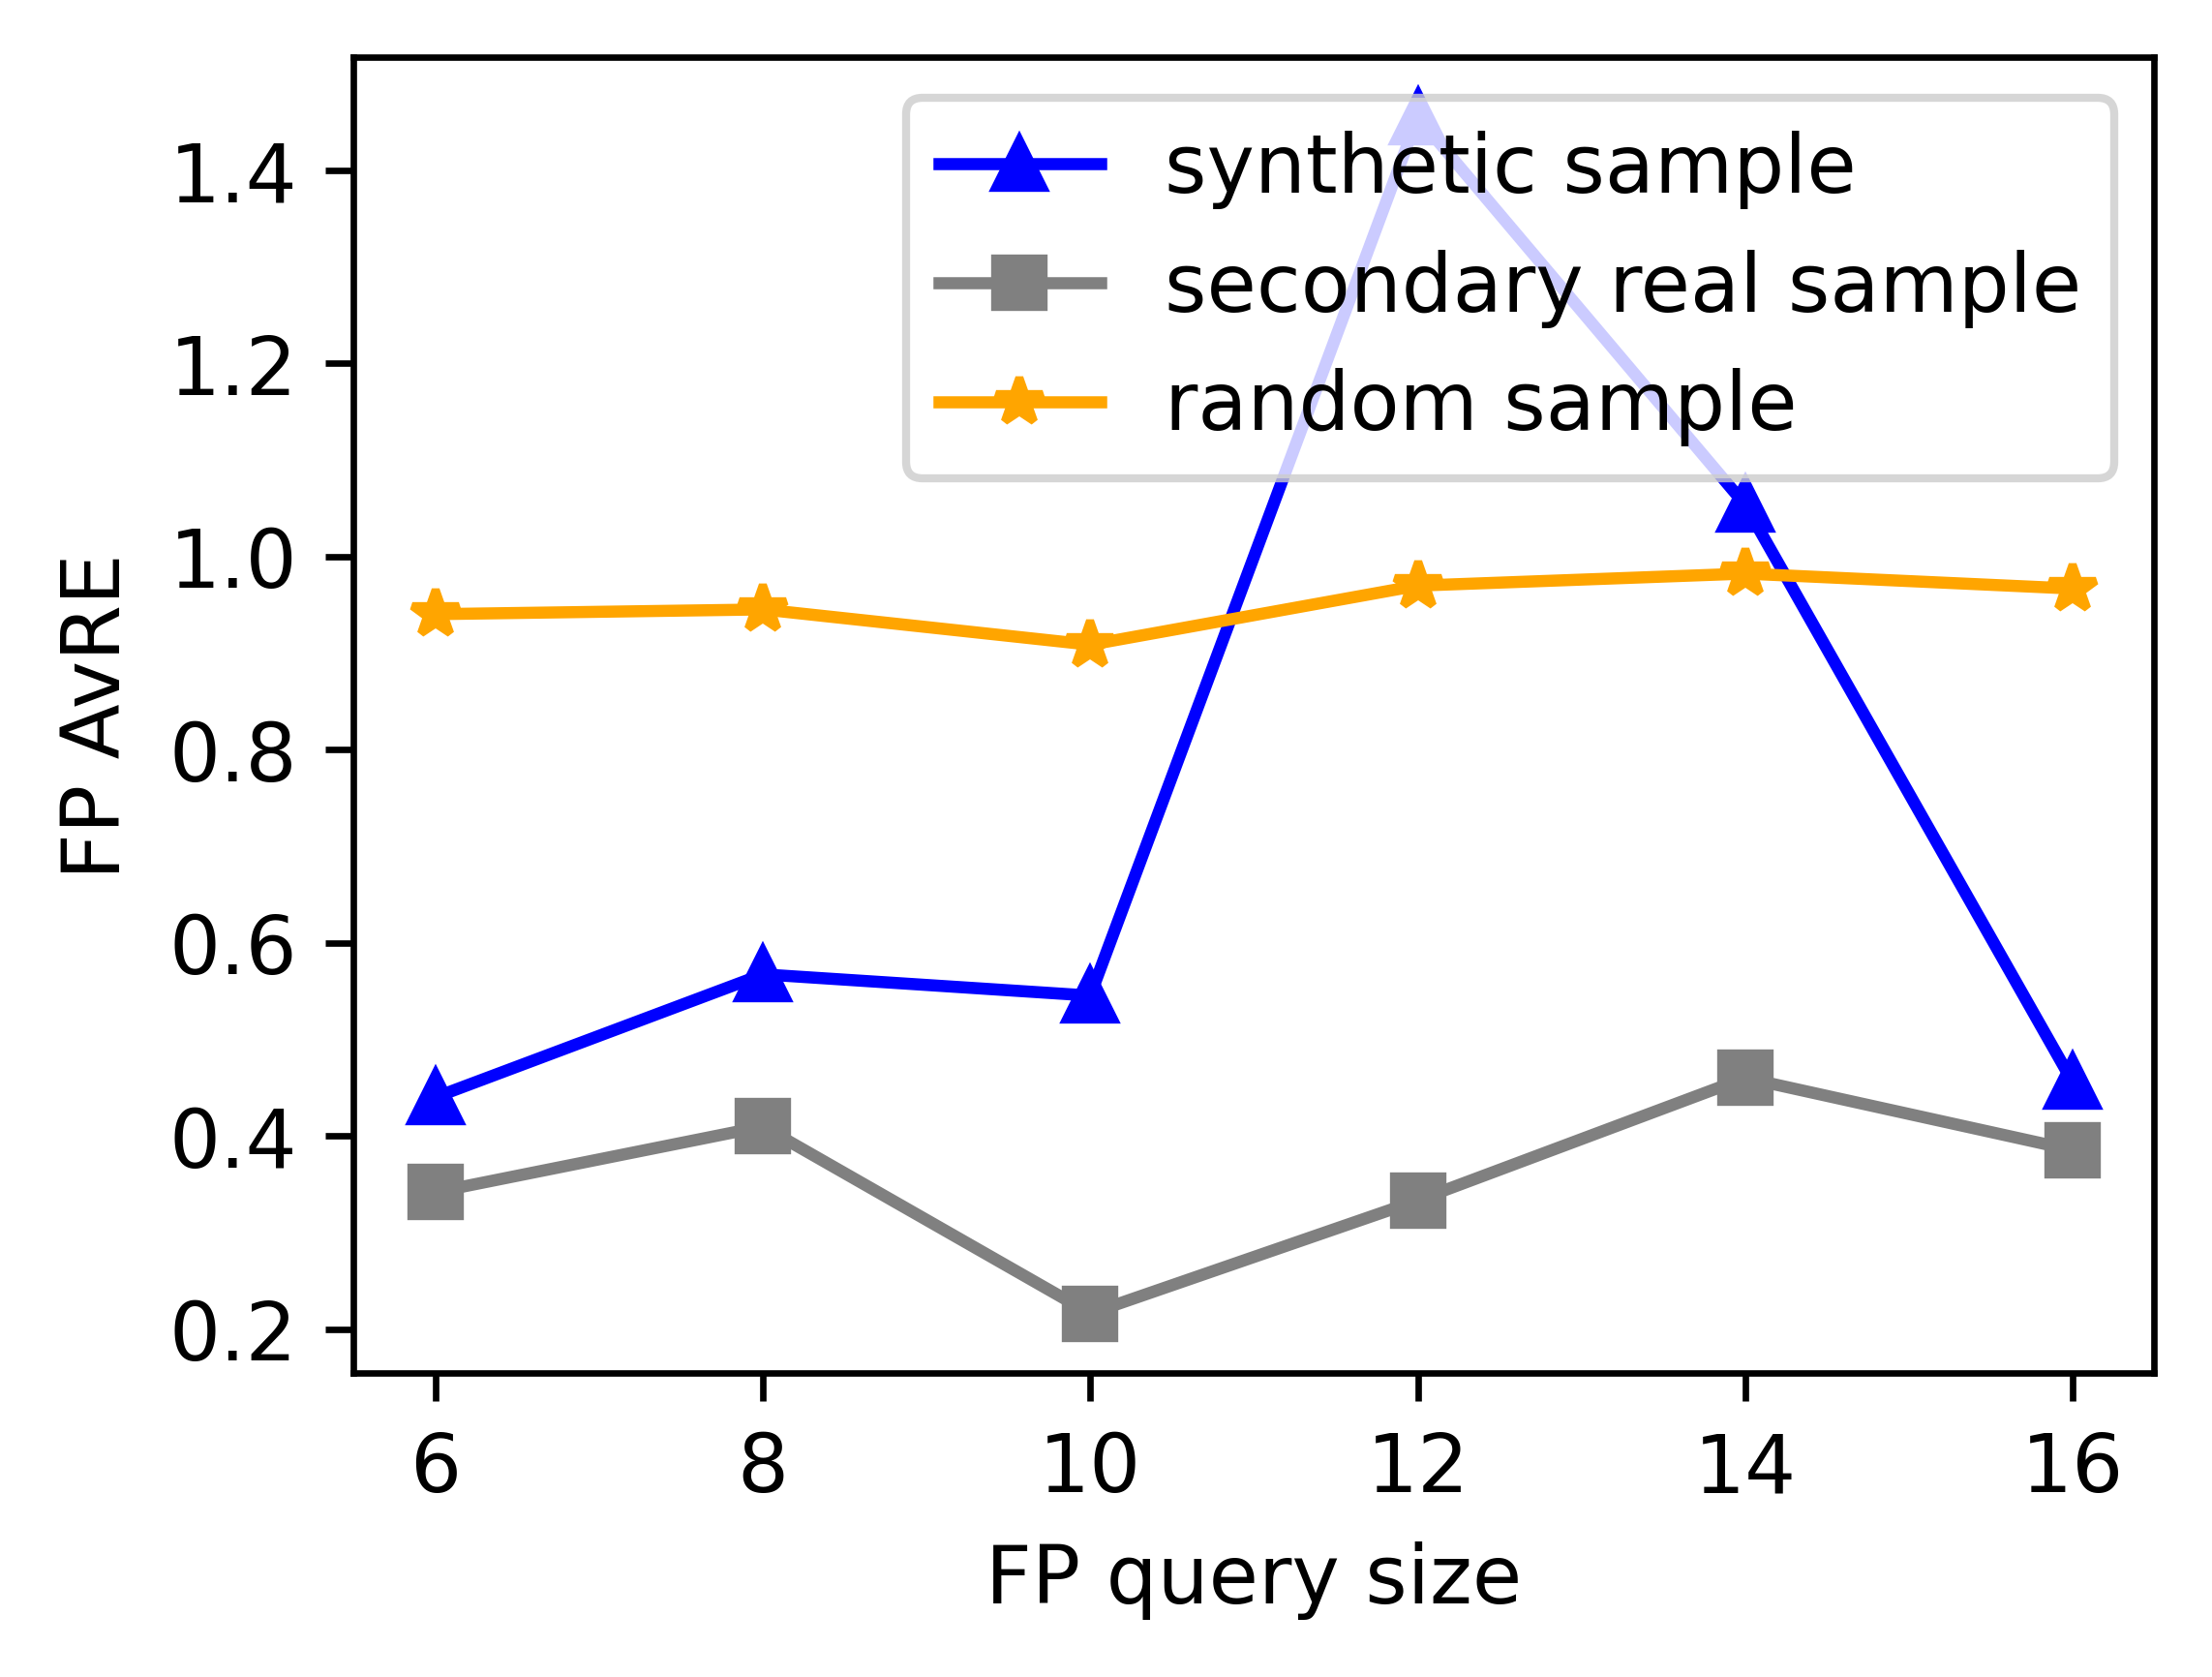

In [944]:
fig, ax = plt.subplots(1,1,figsize=(4,3),dpi=300)
ax.plot(query_size_bins, avREs['FP RE: ' + SYN_DATA_SAMPLE],
       label='synthetic sample',
        marker="^", color=c_syn_sample, alpha=1)
ax.plot(query_size_bins, avREs['FP RE: ' + REAL_DATA_SAMPLE],
       label='secondary real sample',
        marker="s", color=c_secondary_real_sample, alpha=1)
ax.plot(query_size_bins, avREs['FP RE: ' + RANDOM_SAMPLE],
       label='random sample',
        marker="*", color=c_random_sample, alpha=1)

ax.set_ylabel('FP AvRE')
ax.set_xlabel('FP query size')
_ = ax.legend()

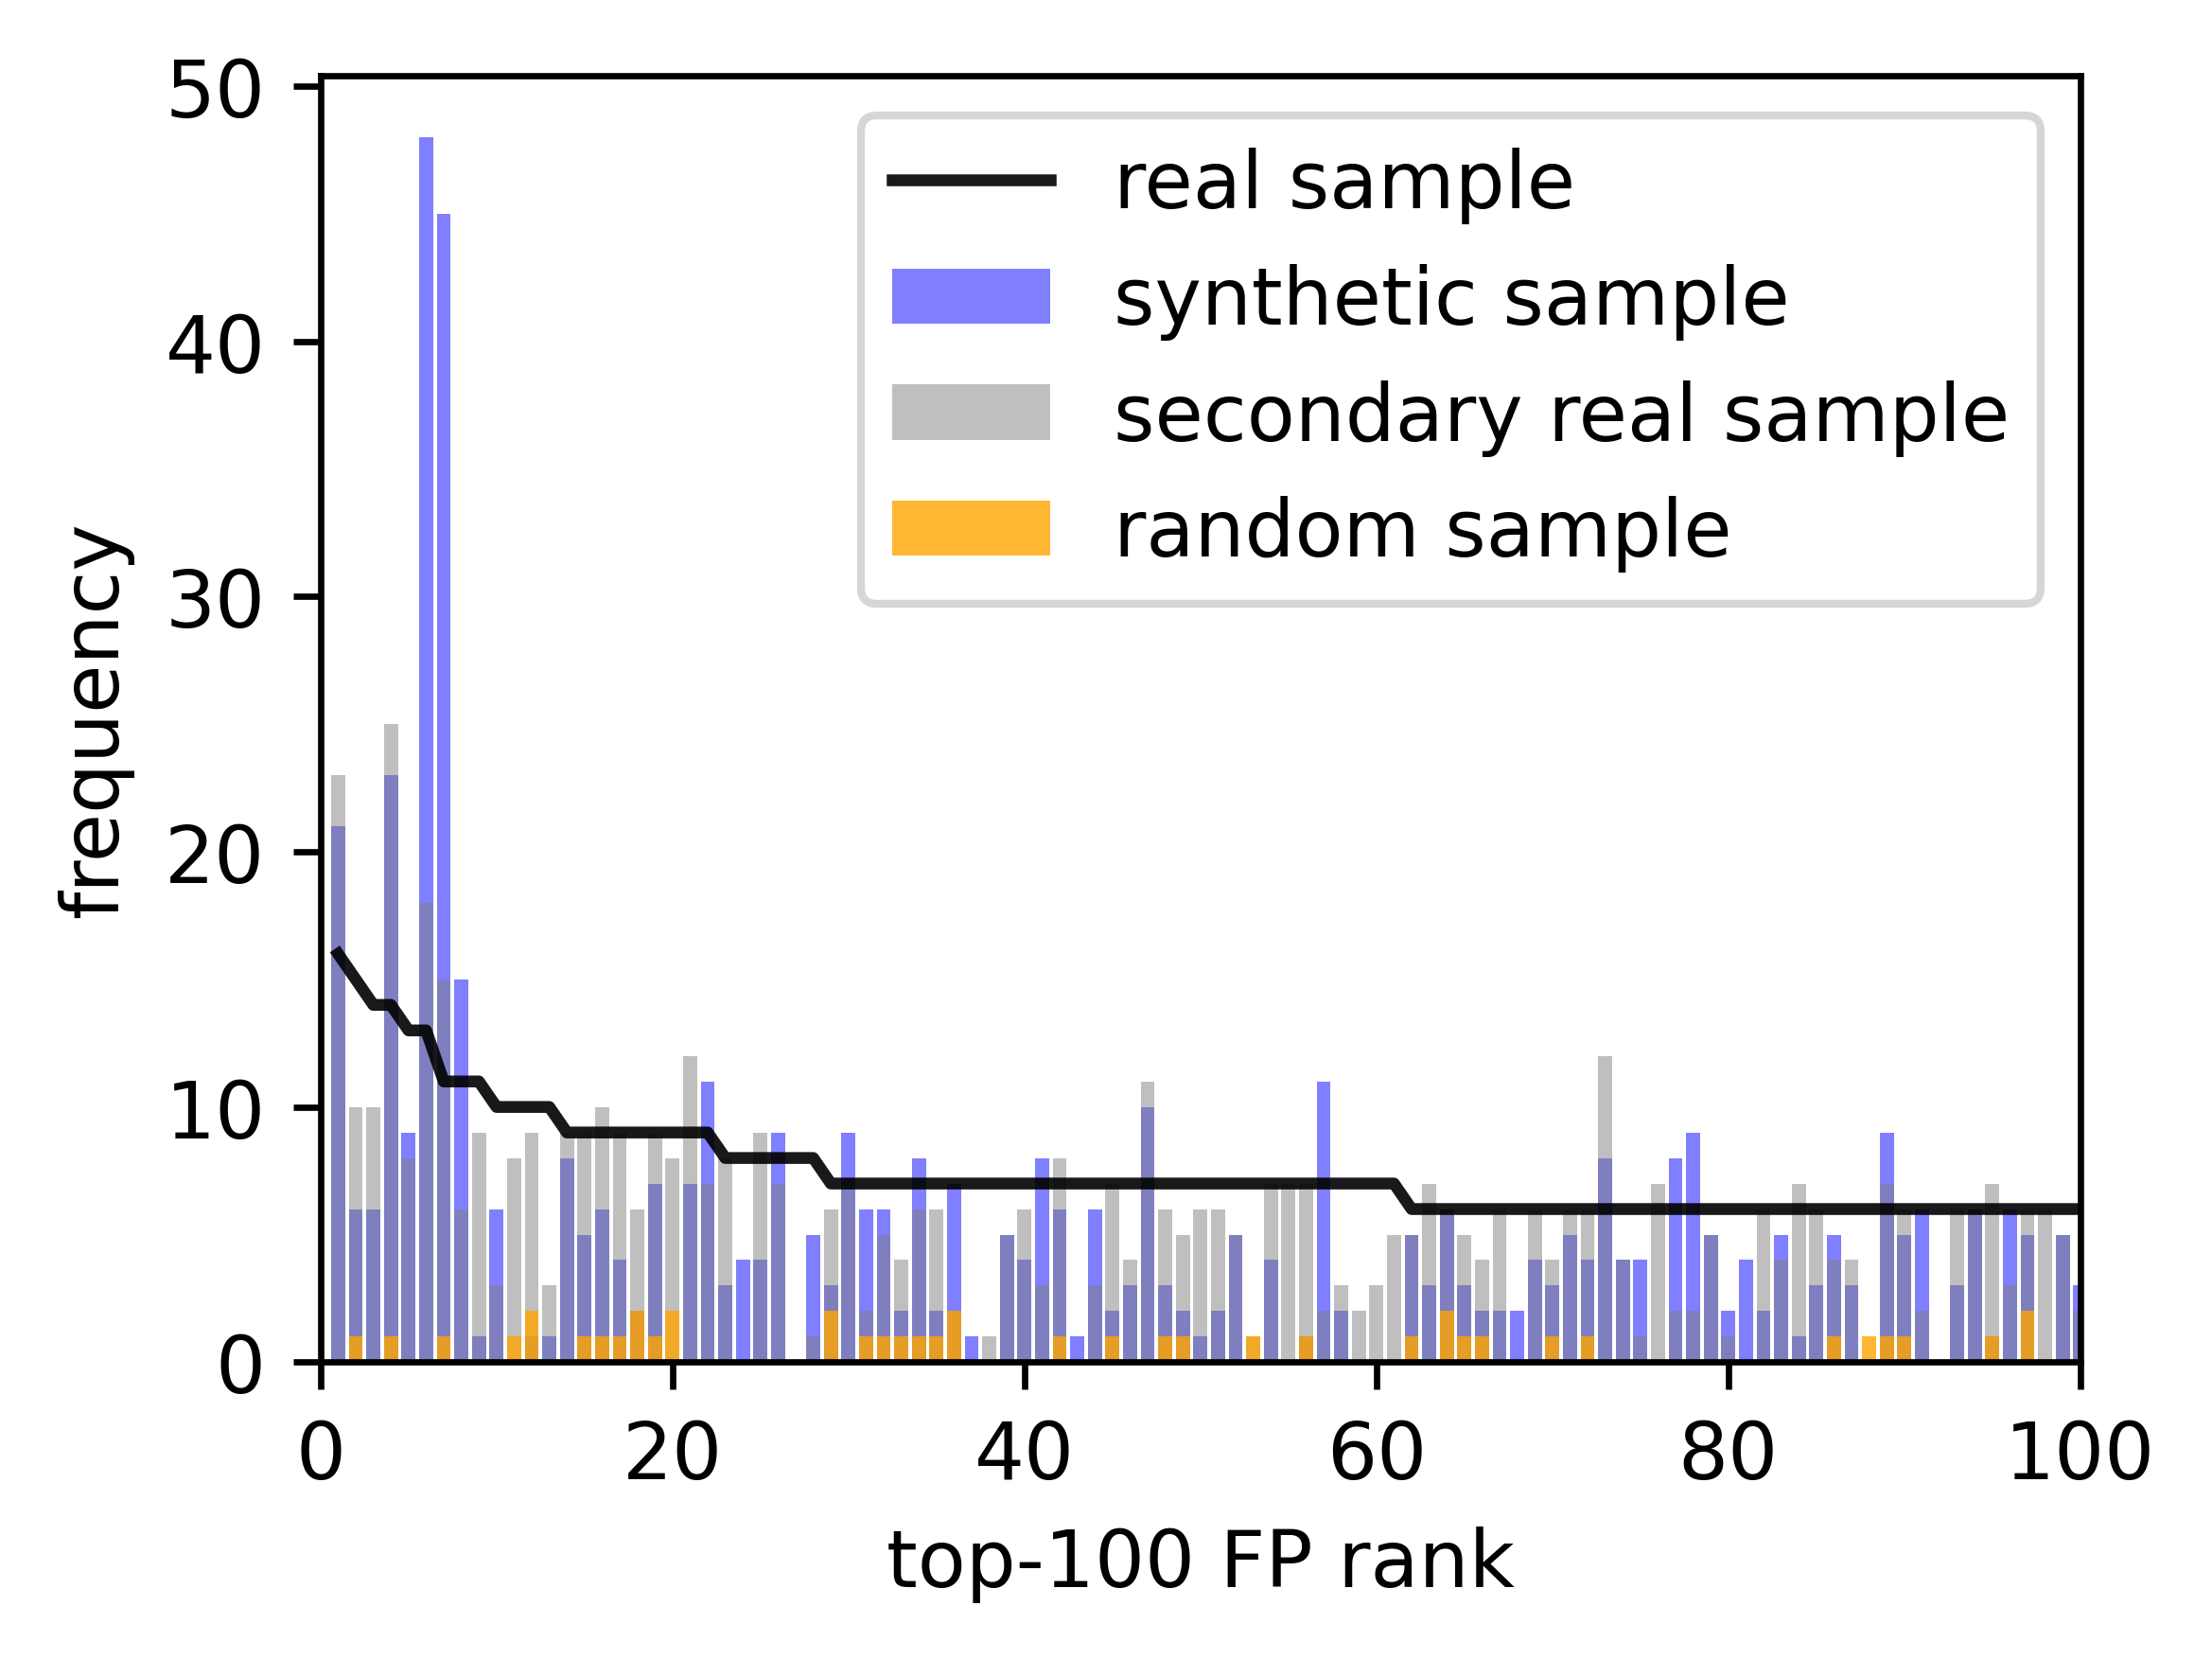

In [1309]:
fig,ax = plt.subplots(1,1, figsize=(4,3), dpi=300)
x = list(range(1,101))
ax.plot(x, FP['real data'], color=c_real_sample, alpha=0.9, label='real sample')
ax.bar(x, FP[SYN_DATA_SAMPLE], color=c_syn_sample, alpha=0.5, label='synthetic sample')
ax.bar(x, FP[REAL_DATA_SAMPLE], color=c_secondary_real_sample, alpha=0.5, label='secondary real sample')
ax.bar(x, FP[RANDOM_SAMPLE], color=c_random_sample, alpha=0.8, label='random sample')
ax.set_xlim(0, 100)
ax.set_xlabel('top-100 FP rank')
ax.set_ylabel('frequency')
_ = ax.legend()

### Check that distribution of where people spend their time is consistent

We evaluate that in aggregate, the distribution of where users spend their time is consistent between the real data and synthetic data.
We look at the correlation between real and synthetic data, in terms of aggregate time spent in each area.

Note: Where people spend time is biased to where they work and live.
So when doing this comparison, we compare generated synthetic trajectories to the random sample of 2000 real trajectories whose home,work label pairs were used to generate the synthetic data.

In [1001]:
from scipy.stats import pearsonr, spearmanr

In [1033]:
def get_area_to_time_spent_dict(vectors):
    """
    Returns a dictionary mapping place to the portion of time spend in that place, 
    for all of the vectors in the vector set.

    i.e. {area: portion of time spent in area for each area seen in the vectors}
    
    """
    vectors = get_unprefixed_vectors(vectors)
    area_to_total_time_dict = {}  #{area: total time in area}
    for v in vectors:
        for area in v:
            if area not in area_to_total_time_dict:
                area_to_total_time_dict[area] = 0
            area_to_total_time_dict[area] += 1
    # delete the null valued area
    area_to_total_time_dict.pop(0)
    return area_to_total_time_dict

In [1069]:
denominator = HOURS_PER_DAY * DAYS * 2000

real_sample_area_to_time_dict = get_area_to_time_spent_dict(real_trajectories_sample)
generated_sample_area_to_time_dict = get_area_to_time_spent_dict(generated_trajectories_sample)
secondary_real_sample_area_to_time_dict = get_area_to_time_spent_dict(secondary_real_sample)
random_sample_area_to_time_dict = get_area_to_time_spent_dict(random_sample)

area_time_df = pd.DataFrame(
    real_sample_area_to_time_dict.items(), columns=['area','real sample']
).set_index("area").join(pd.DataFrame(
        generated_sample_area_to_time_dict.items(), columns=['area', SYN_DATA_SAMPLE]
).set_index("area"), how="outer").join(
    pd.DataFrame(
        secondary_real_sample_area_to_time_dict.items(), columns=['area', REAL_DATA_SAMPLE]
).set_index("area"), how="outer").join(
    pd.DataFrame(
        random_sample_area_to_time_dict.items(), columns=['area', RANDOM_SAMPLE]
).set_index("area"), how="outer").fillna(0) / denominator

print(len(area_time_df))
area_time_df.head()

651


real sample  synthetic data sample  secondary real data sample  \
area                                                                   
1        0.001121               0.001429                    0.000983   
2        0.002512               0.003533                    0.002304   
3        0.000333               0.000283                    0.000225   
4        0.003571               0.004233                    0.003200   
5        0.000558               0.000683                    0.000479   

      random data sample  
area                      
1               0.001642  
2               0.001475  
3               0.001554  
4               0.001583  
5               0.001458

In [1070]:
k=100
plot_area_time_df = area_time_df.sort_values("real sample", ascending=False).head(k)
plot_area_time_df.head()

real sample  synthetic data sample  secondary real data sample  \
area                                                                   
21       0.009608               0.010337                    0.008871   
22       0.004433               0.004567                    0.004158   
8        0.004146               0.005392                    0.004533   
44       0.003842               0.004163                    0.003983   
4        0.003571               0.004233                    0.003200   

      random data sample  
area                      
21              0.001563  
22              0.001521  
8               0.001587  
44              0.001638  
4               0.001583

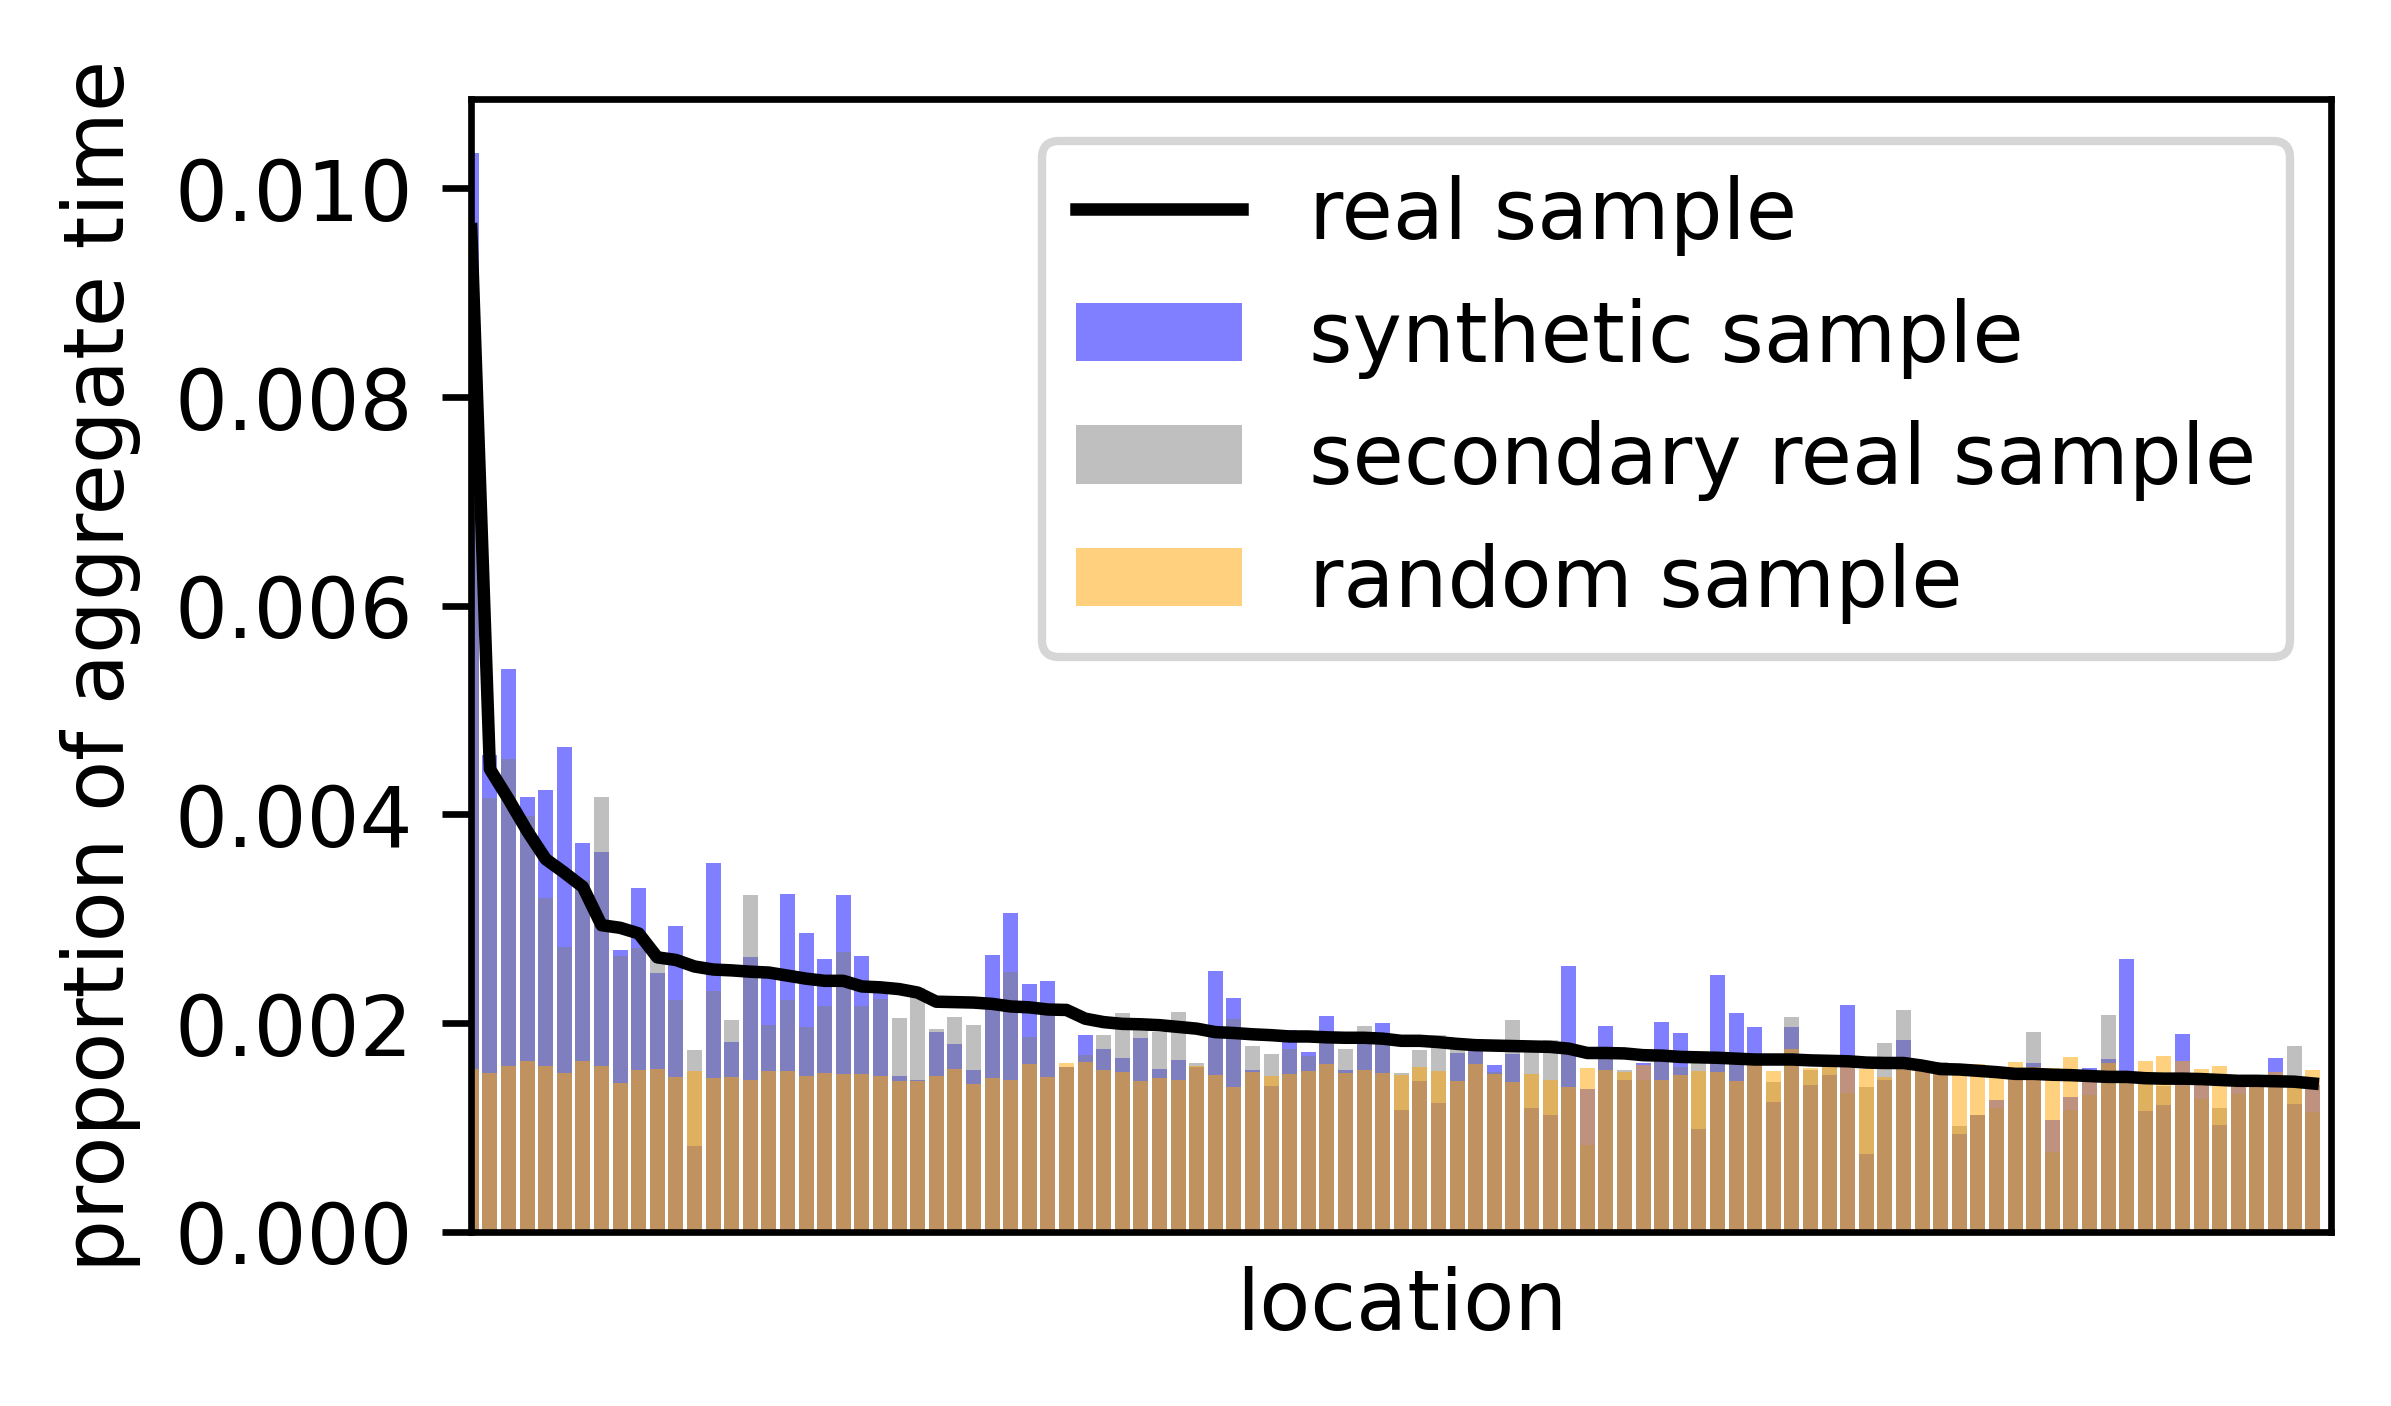

In [1326]:
fig, ax = plt.subplots(1,1,figsize=(4,2.5),dpi=300)
x = range(0,k)
ax.set_xticks([])
ax.set_xlabel("location")
ax.set_xlim(0,k)
ax.set_ylabel("proportion of aggregate time")
ax.plot(x, plot_area_time_df["real sample"],
        label="real sample", color=c_real_sample, alpha=1)
ax.bar(x, plot_area_time_df[SYN_DATA_SAMPLE], 
       label="synthetic sample", color=c_syn_sample, alpha=0.5)
ax.bar(x, plot_area_time_df[REAL_DATA_SAMPLE], 
       label="secondary real sample", color=c_secondary_real_sample, alpha=0.5)
ax.bar(x, plot_area_time_df[RANDOM_SAMPLE], 
       label="random sample", color=c_random_sample, alpha=0.5)
_ = ax.legend()

Compute KL divergence between real sample and other samples.

In [1081]:
time_D_KL = 'Proportion of aggregate time spent in locations (KL-divergence)'
eval_df.loc[time_D_KL] = ''
eval_df.loc[time_D_KL][SYN_DATA_SAMPLE] = compute_D_KL(area_time_df[SYN_DATA_SAMPLE], area_time_df["real sample"])
eval_df.loc[time_D_KL][REAL_DATA_SAMPLE] = compute_D_KL(area_time_df[REAL_DATA_SAMPLE], area_time_df["real sample"])
eval_df.loc[time_D_KL][RANDOM_SAMPLE] = compute_D_KL(area_time_df[RANDOM_SAMPLE], area_time_df["real sample"])
eval_df.astype(float).round(4)

synthetic data sample  \
home label error rate                                              0.1375   
work label error rate                                              0.2675   
Trip distance (KL-divergence)                                      0.0008   
FP AvRE                                                            0.5587   
Proportion of aggregate time spent in locations...                 0.0366   

                                                    secondary real data sample  \
home label error rate                                                   0.0864   
work label error rate                                                   0.2415   
Trip distance (KL-divergence)                                           0.0015   
FP AvRE                                                                 0.3574   
Proportion of aggregate time spent in locations...                      0.0085   

                                                    random data sample  
home label error rate                                           0.9975  
work label error rate                                           0.9235  
Trip distance (KL-divergence)                                   0.3655  
FP AvRE                                                         0.9411  
Proportion of aggregate time spent in locations...              0.9608

Compute correlations

In [1072]:
print("Proportion of time spent in each area: Pearson-r correlation between samples")
for sample in [SYN_DATA_SAMPLE, REAL_DATA_SAMPLE, RANDOM_SAMPLE]:
    print("real sample vs %s:" % sample)
    print("%0.4f (p=%0.4f)" % pearsonr(area_time_df["real sample"], area_time_df[sample]))

Proportion of time spent in each area: Pearson-r correlation between samples
real sample vs synthetic data sample:
0.9366 (p=0.0000)
real sample vs secondary real data sample:
0.9652 (p=0.0000)
real sample vs random data sample:
-0.0280 (p=0.4755)


In [1073]:
print("Proportion of time spent in each area: Spearman correlation between samples")
for sample in [SYN_DATA_SAMPLE, REAL_DATA_SAMPLE, RANDOM_SAMPLE]:
    print("real sample vs %s:" % sample)
    print("%0.4f (p=%0.4f)" % spearmanr(area_time_df["real sample"], area_time_df[sample]))

Proportion of time spent in each area: Spearman correlation between samples
real sample vs synthetic data sample:
0.9052 (p=0.0000)
real sample vs secondary real data sample:
0.9516 (p=0.0000)
real sample vs random data sample:
-0.0526 (p=0.1799)


In [1083]:
time_pearsonr = 'Proportion of aggregate time spent in locations (Pearson r)'
eval_df.loc[time_pearsonr] = ''
for sample in [SYN_DATA_SAMPLE, REAL_DATA_SAMPLE, RANDOM_SAMPLE]:
    eval_df.loc[time_pearsonr][sample] = pearsonr(
        area_time_df["real sample"], area_time_df[sample]
    )[0]
eval_df.astype(float).round(4)

synthetic data sample  \
home label error rate                                              0.1375   
work label error rate                                              0.2675   
Trip distance (KL-divergence)                                      0.0008   
FP AvRE                                                            0.5587   
Proportion of aggregate time spent in locations...                 0.0366   
Proportion of aggregate time spent in locations...                 0.9366   

                                                    secondary real data sample  \
home label error rate                                                   0.0864   
work label error rate                                                   0.2415   
Trip distance (KL-divergence)                                           0.0015   
FP AvRE                                                                 0.3574   
Proportion of aggregate time spent in locations...                      0.0085   
Proportion of aggregate time spent in locations...                      0.9652   

                                                    random data sample  
home label error rate                                           0.9975  
work label error rate                                           0.9235  
Trip distance (KL-divergence)                                   0.3655  
FP AvRE                                                         0.9411  
Proportion of aggregate time spent in locations...              0.9608  
Proportion of aggregate time spent in locations...             -0.0280

### Locations per user

This metric evaluates whether the distribution of the number of distinct locations individuals visit within a time period is consistent between the real and synthetic data.

Some users only go 2 or 3 distinct places during their week... while others visit 10-30 different places...

For locations per user, $L$, compute the distribution of locations per user as a proportion, $P(L)$.

To evaluation whether this distribution is maintained in the synthetic data we use two tests:

1. KL divergence

2. Pearson's chi-squared test for homogeneity


In [1328]:
def get_locations_per_user(tvs):
    """
    Get the distribution of number of distinct places visited by each user.
    
    Returns a Series of length matching number of user data vectors, 
    where each element corresponds to the number of distinct places visited by that user.
    """
    return pd.Series([len(set(tv)) for tv in tvs])

In [1329]:
real_locations_per_user = get_locations_per_user(real_trajectories)
real_sample_locations_per_user = get_locations_per_user(real_trajectories_sample)
generated_sample_locations_per_user = get_locations_per_user(generated_trajectories_sample)
random_sample_locations_per_user = get_locations_per_user(random_sample)

Does the distributino of locations per user look similar?

And can we simply use for L the locations per user from real trajectories?

YES!

In [1330]:
real_locations_per_user.describe()

count    22704.000000
mean         5.683492
std          3.191654
min          1.000000
25%          4.000000
50%          5.000000
75%          7.000000
max         43.000000
dtype: float64

In [1331]:
generated_sample_locations_per_user.describe()

count    2000.000000
mean        5.878000
std         3.460362
min         1.000000
25%         4.000000
50%         5.000000
75%         7.000000
max        43.000000
dtype: float64

In [1332]:
L = list(range(min(real_locations_per_user.min(), random_sample_locations_per_user.min()),
               max(real_locations_per_user.max(), random_sample_locations_per_user.max())))

Make $P(L)$

In [1333]:
def get_locations_per_user_dist(tvs, L=L):
    locations_per_user = get_locations_per_user(tvs)
    return locations_per_user.value_counts().reindex(L).fillna(0)

def get_locations_per_user_dist_p(tvs, L=L):
    return get_locations_per_user_dist(tvs) / len(tvs)

real_locations_per_user_dist = get_locations_per_user_dist_p(real_trajectories)

real_sample_locations_per_user_dist = get_locations_per_user_dist_p(real_trajectories_sample)
generated_sample_locations_per_user_dist = get_locations_per_user_dist_p(generated_trajectories_sample)
random_sample_locations_per_user_dist = get_locations_per_user_dist_p(random_sample)

In [1334]:
len(L)

118

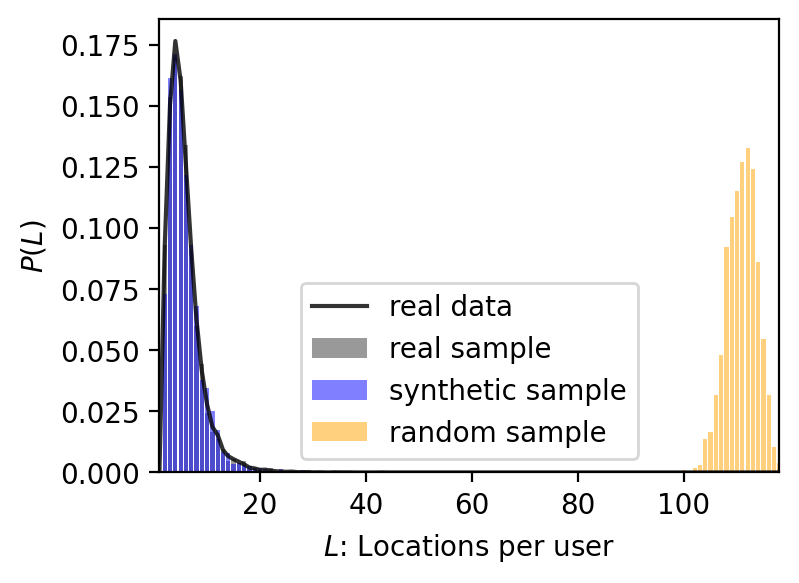

In [1335]:
fig,ax = plt.subplots(1, 1, figsize=(4,3), dpi=100)

ax.plot(L, real_locations_per_user_dist, 
       label="real data", color="black", alpha=0.8)
ax.bar(L, real_sample_locations_per_user_dist, 
       label="real sample", color=c_secondary_real_sample, alpha=0.8)
ax.bar(L, generated_sample_locations_per_user_dist, 
       label="synthetic sample", color=c_syn_sample, alpha=0.5)
ax.bar(L, random_sample_locations_per_user_dist, 
       label="random sample", color=c_random_sample, alpha=0.5)

ax.set_xlim(L[0], L[-1])
ax.set_xlabel("$L$: Locations per user")
ax.set_ylabel("$P(L)$")
_ = ax.legend()

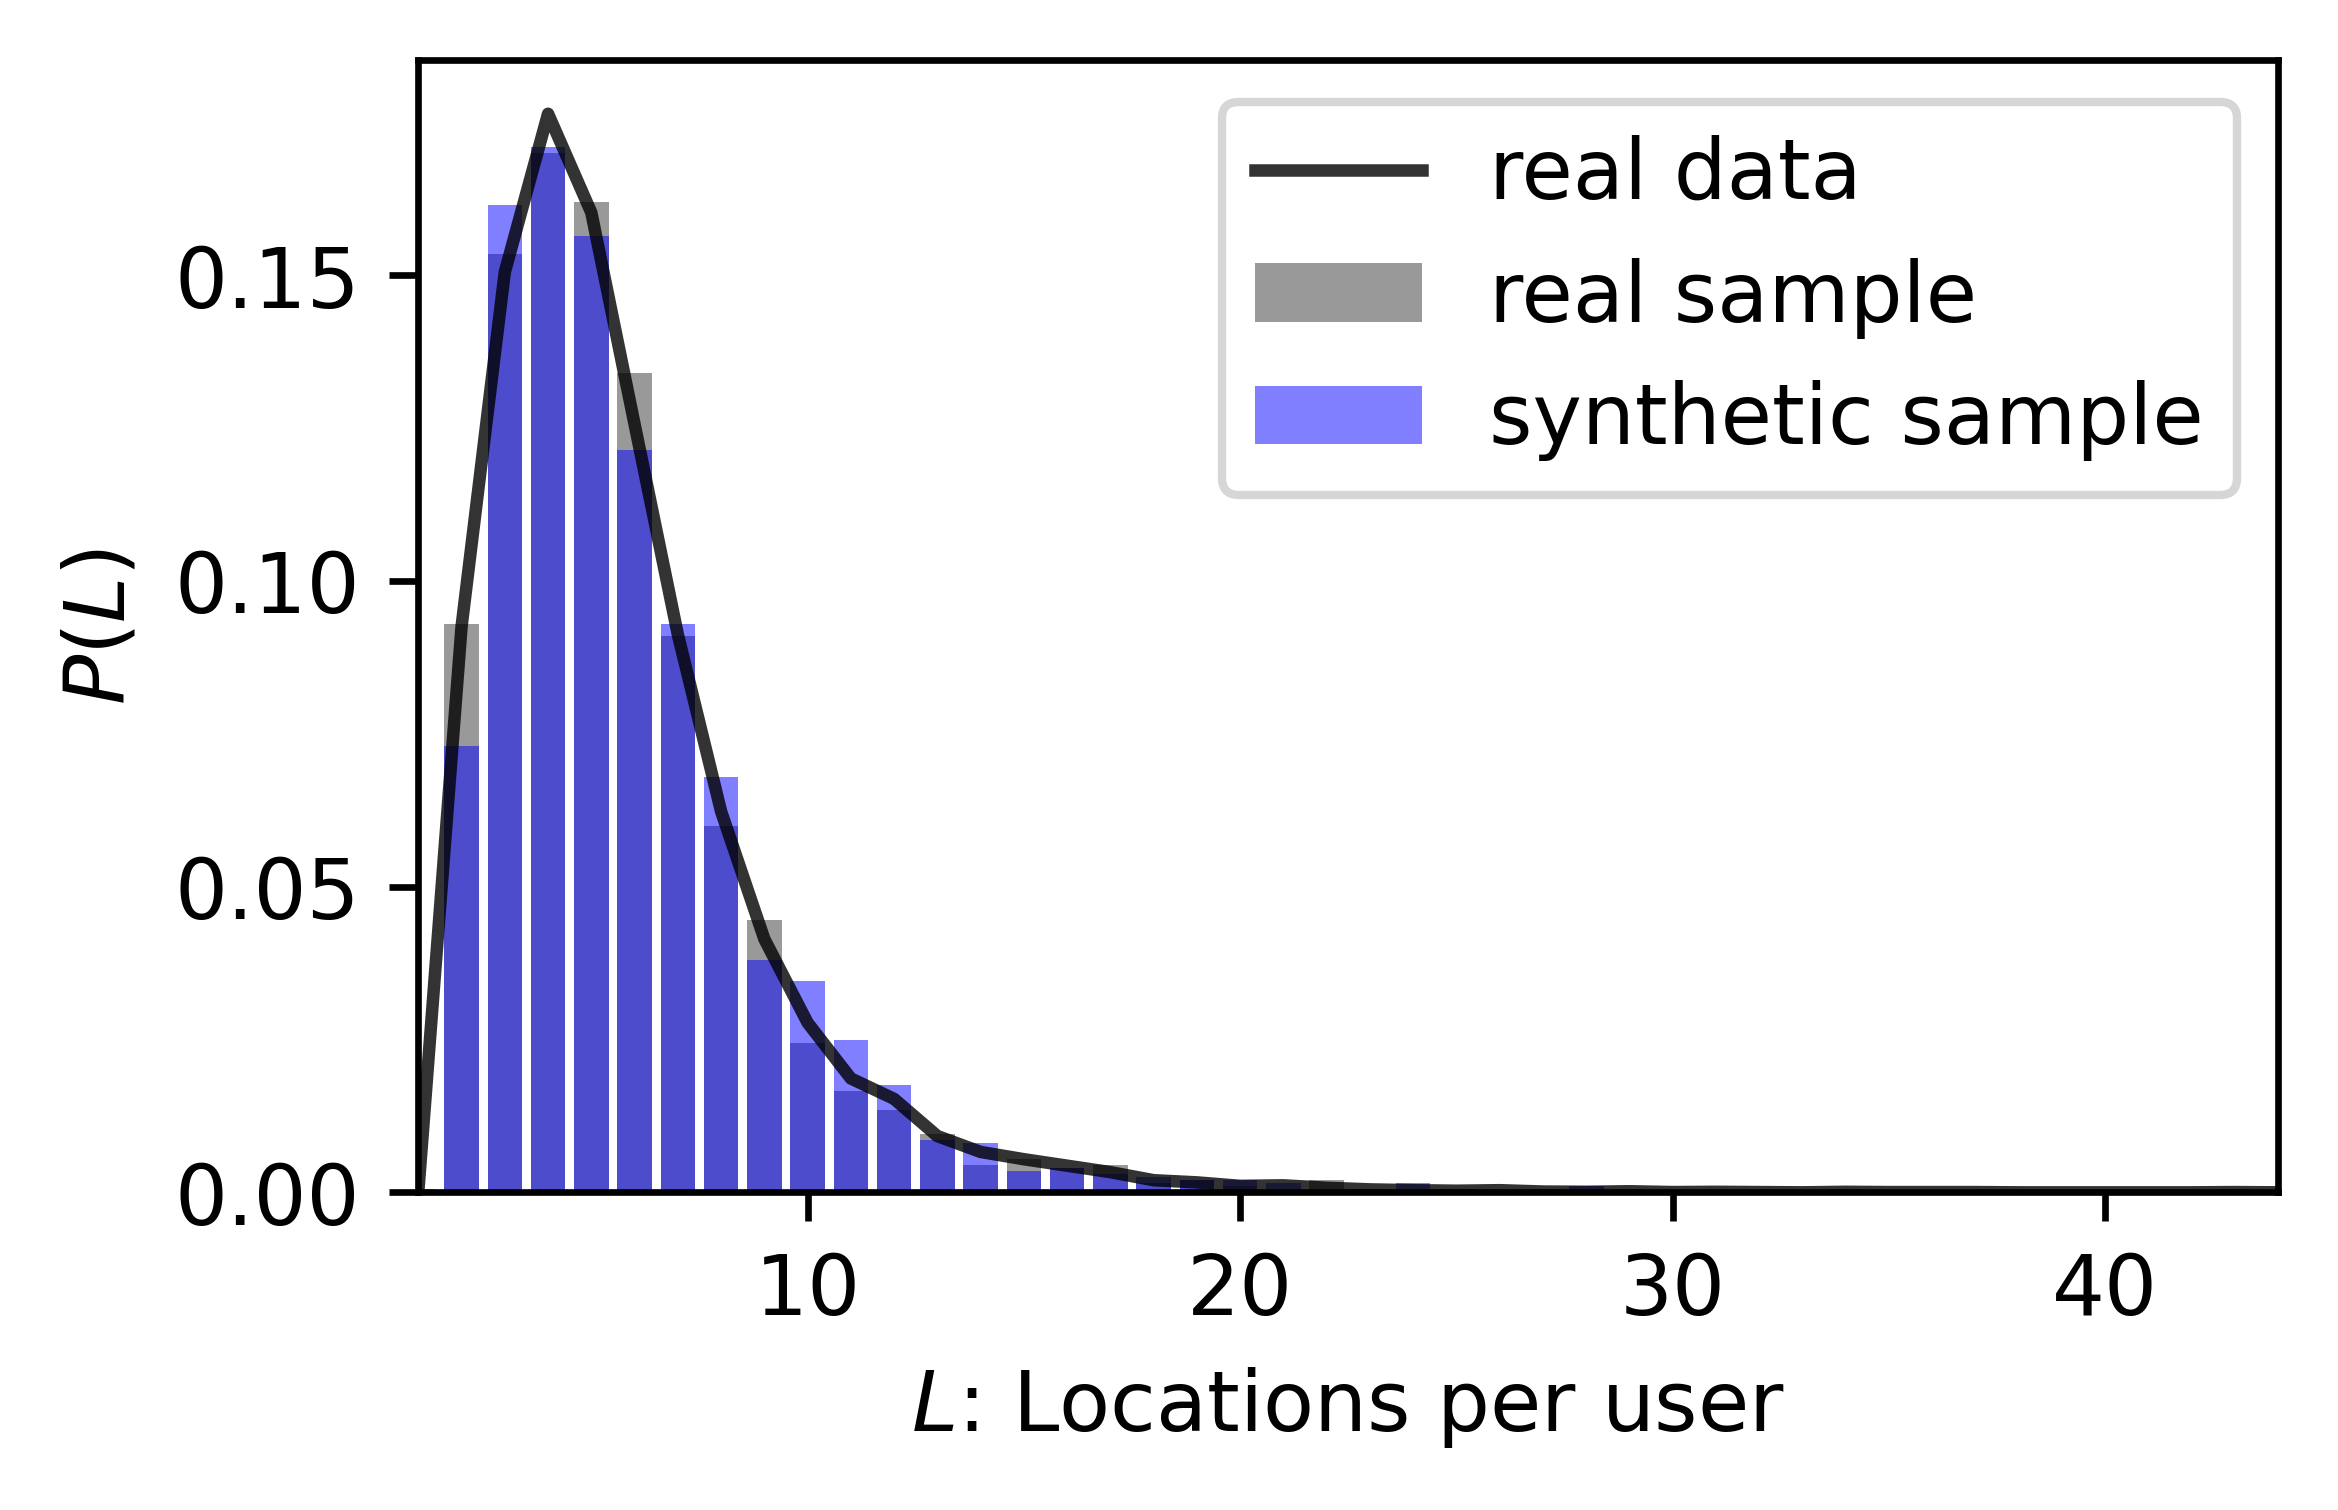

In [1336]:
fig,ax = plt.subplots(1, 1, figsize=(4,2.5), dpi=300)
L_plot = L[:real_locations_per_user.max()+1]
ax.plot(L_plot, real_locations_per_user_dist[L_plot], 
       label="real data", color="black", alpha=0.8)
ax.bar(L_plot, real_sample_locations_per_user_dist[L_plot], 
       label="real sample", color=c_secondary_real_sample, alpha=0.8)
ax.bar(L_plot, generated_sample_locations_per_user_dist[L_plot], 
       label="synthetic sample", color=c_syn_sample, alpha=0.5)

ax.set_xlim(L_plot[0], L_plot[-1])
ax.set_xlabel("$L$: Locations per user")
ax.set_ylabel("$P(L)$")
_ = ax.legend()

Compute KL divergence between samples

In [1218]:
locations_per_user_D_KL = 'Locations per user (KL-divergence)'
eval_df.loc[locations_per_user_D_KL] = '--'
eval_df.loc[locations_per_user_D_KL][SYN_DATA_SAMPLE] = compute_D_KL(generated_sample_locations_per_user_dist, real_locations_per_user_dist)
eval_df.loc[locations_per_user_D_KL][REAL_DATA_SAMPLE] = compute_D_KL(real_sample_locations_per_user_dist, real_locations_per_user_dist)
eval_df.loc[locations_per_user_D_KL][RANDOM_SAMPLE] = compute_D_KL(random_sample_locations_per_user_dist, real_locations_per_user_dist)
eval_df.apply(lambda x: round(x,4) if type(x)==float else x)

synthetic data sample  \
home label error rate                                             0.1375   
work label error rate                                             0.2675   
Trip distance (KL-divergence)                                   0.000847   
FP AvRE                                                          0.55871   
Proportion of aggregate time spent in locations...               0.03659   
Proportion of aggregate time spent in locations...              0.936617   
Locations per user (KL-divergence)                              0.012374   

                                                   secondary real data sample  \
home label error rate                                                0.086388   
work label error rate                                                0.241546   
Trip distance (KL-divergence)                                        0.001505   
FP AvRE                                                              0.357381   
Proportion of aggregate time spent in locations...                   0.008475   
Proportion of aggregate time spent in locations...                   0.965224   
Locations per user (KL-divergence)                                   0.004437   

                                                   random data sample  
home label error rate                                          0.9975  
work label error rate                                          0.9235  
Trip distance (KL-divergence)                                0.365503  
FP AvRE                                                      0.941059  
Proportion of aggregate time spent in locations...           0.960789  
Proportion of aggregate time spent in locations...          -0.028017  
Locations per user (KL-divergence)                           -2.45867

##### Pearson's chi-squared test for homogeneity

We use the Pearson's chi-squared test for homogeneity to compare the distribution of the number of distinct places visited between the generated synthetic data and the real data.

For each trajectory vector in the synthetic and real data, we take the number of distinct places visited as a category.  We compute the frequency of this category (number of distinct places visited) occuring in each of the synthetic and real datasets.

We then test the null hypothesis that:

The proportion of generated synthetic trajectory vectors with P distinct places visited is the same as the proportion of real trajectory vectors with P distinct places visited, for each P occuring in either of the generated or real datasets.

We test the null hypothesis with a significance level of 0.05.

In [1242]:
generated_data_sample_size = 2000
real_data_population_size = len(real_trajectories)
observed_to_expected_multiplier = generated_data_sample_size/real_data_population_size
print('real population size: %s, generated data sample size: %s, \n(sample size)/(population size)=%s' % (real_data_population_size, generated_data_sample_size, observed_to_expected_multiplier))

real population size: 22704, generated data sample size: 2000, 
(sample size)/(population size)=0.08809020436927413


In [1222]:
distinct_places_counts_per_user_real = get_locations_per_user(real_trajectories)

print('minimum distinct places visited for real users: %s' % min(distinct_places_counts_per_user_real))
print('maximum distinct places visited for real users: %s' % max(distinct_places_counts_per_user_real))

minimum distinct places visited for real users: 1
maximum distinct places visited for real users: 43


In [1237]:
distinct_places_category_to_frequency_map_real = get_locations_per_user_dist(
    real_trajectories, L=range(1,43+1)).to_dict()

frequency
distinct areas           
1                     2.0
2                  2101.0
3                  3418.0
4                  4006.0
5                  3639.0

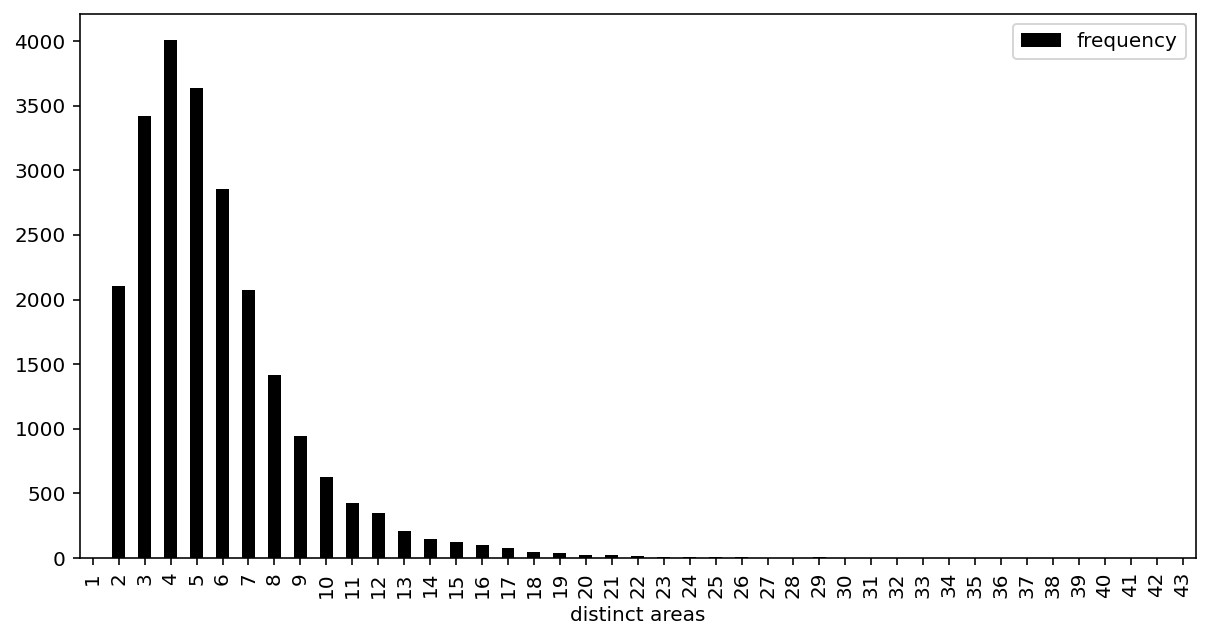

In [1236]:
def plot_distinct_places_category_to_frequency(observed_values_map, expected_values_map=None,
                                               name1='frequency', name2='expected frequency'):
    df = pd.DataFrame.from_dict({
        # 'distinct areas': list(observed_values_map.keys()),
        # name1: list(observed_values_map.values())
        'distinct areas': [k for k in observed_values_map.keys() if k != 0],
        name1: [v for k,v in observed_values_map.items() if k != 0],
    }).set_index('distinct areas')
    if expected_values_map:
        df2 = pd.DataFrame.from_dict({
            'distinct areas': list(expected_values_map.keys()),
            name2: list(expected_values_map.values())
        }).set_index('distinct areas')
        df[name2] = df2[name2]
    df.plot(kind='bar',figsize=(10,5))
    return df

df = plot_distinct_places_category_to_frequency(distinct_places_category_to_frequency_map_real)
df.head()

Handle binning the data

In [1238]:
# Get quantile bins based on the distribution of distinct places in the full real population
# Bins chosen based on how dividing data can get close as possible to equal bins, 
#  but because of data distribution (e.g. so many points with 4 distinct places), exactly equal bins impossible
# At the same time, bin the real data into these buckets -- this is the output binned series
# Each element in the binned series indicates the bin it belongs in, indicating that bin by the index of bin
# Then reuse these bins to bin the generated data
quantiles = 6 # 15 # Turns into 10 with drop duplicates (command to drop duplicate edges -- error on quantiles=10 otherwise)
# First print nicely with the labeled bins
real_reference_binned_series, bins = pd.qcut(distinct_places_counts_per_user_real, quantiles, retbins=True, duplicates='drop')
print('Binning:')
print(real_reference_binned_series)
# Then get the unlabeled bins and series that we need
real_reference_binned_series, bins = pd.qcut(distinct_places_counts_per_user_real, quantiles, retbins=True, labels=False, duplicates='drop')

# Note: the max bin value is increased to accommodated generated data long tails
print(len(bins), 'bins:', bins)

Binning:
0          (6.0, 8.0]
1          (3.0, 4.0]
2         (8.0, 43.0]
3          (4.0, 5.0]
4          (4.0, 5.0]
             ...     
22699      (3.0, 4.0]
22700      (4.0, 5.0]
22701    (0.999, 3.0]
22702      (5.0, 6.0]
22703    (0.999, 3.0]
Length: 22704, dtype: category
Categories (6, interval[float64, right]): [(0.999, 3.0] < (3.0, 4.0] < (4.0, 5.0] < (5.0, 6.0] < (6.0, 8.0] < (8.0, 43.0]]
7 bins: [ 1.  3.  4.  5.  6.  8. 43.]


In [1239]:
def get_binned_series_to_binned_map(binned_series, bins):
    """
    Transforms the binned series into a mapping of {bin name -> frequency count}
    """
    bin_index_to_name_map = {i:'(%s, %s]' % (bins[i], bins[i+1]) for i in range(1, len(bins)-1)}
    bin_index_to_name_map[0] = '<= %s' % bins[1]

    bin_index_to_name_map[len(bins)-2] = '> %s' % bins[len(bins)-2]
    bin_index_to_name_map
    # First make mapping of {bin index -> frequency}
    binned_map = {i:0 for i in range(len(bins)-1)}
    for item in binned_series:
        binned_map[item] += 1
    # rename bins based on their span
    binned_map = {bin_index_to_name_map[k]:v for k,v in binned_map.items()}
    return binned_map

{'<= 3.0': 5521,
 '(3.0, 4.0]': 4006,
 '(4.0, 5.0]': 3639,
 '(5.0, 6.0]': 2853,
 '(6.0, 8.0]': 3487,
 '> 8.0': 3198}

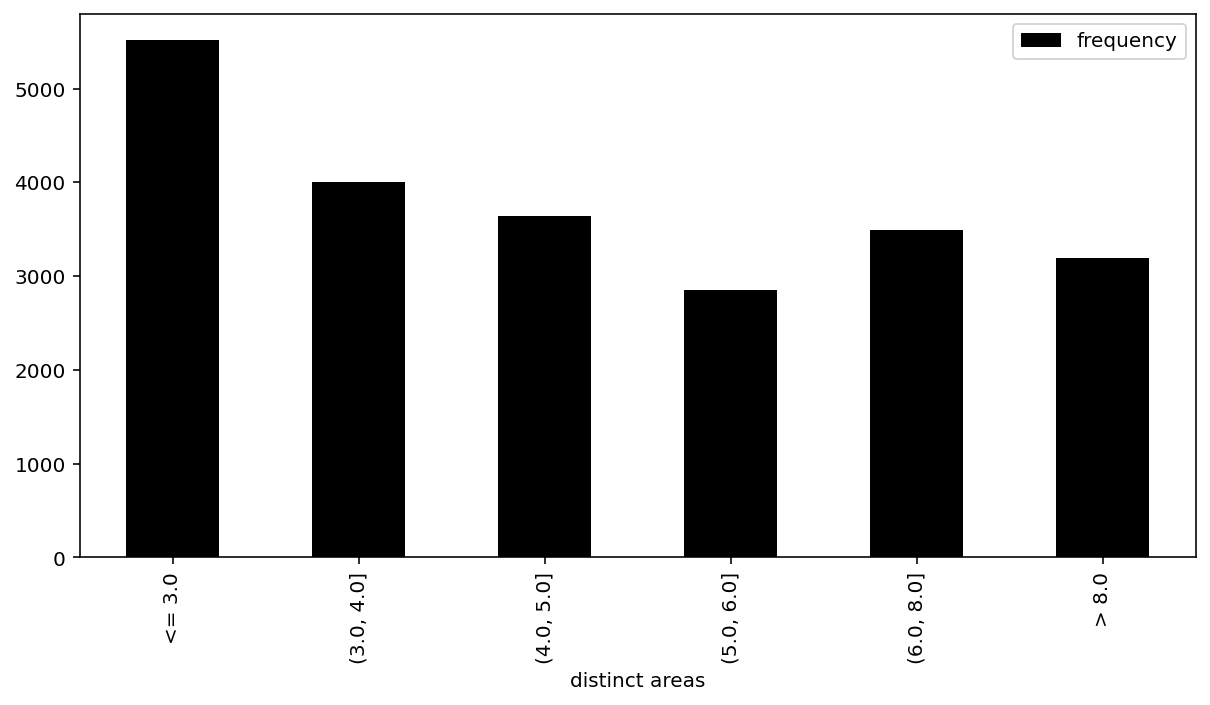

In [1240]:
real_reference_binned_map = get_binned_series_to_binned_map(real_reference_binned_series, bins)
plot_distinct_places_category_to_frequency(real_reference_binned_map)
real_reference_binned_map

{'<= 3.0': 486.34601832276246,
 '(3.0, 4.0]': 352.88935870331215,
 '(4.0, 5.0]': 320.5602536997886,
 '(5.0, 6.0]': 251.32135306553909,
 '(6.0, 8.0]': 307.1705426356589,
 '> 8.0': 281.7124735729387}

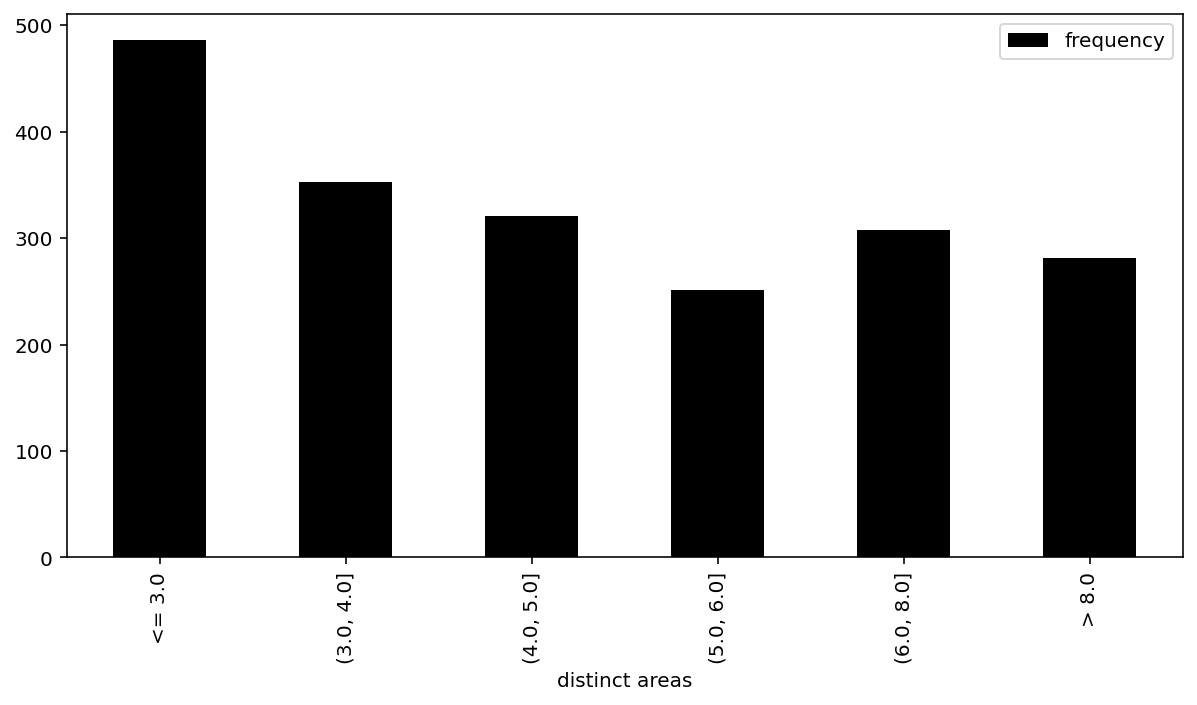

In [1243]:
# Make expected frequencies mapping for the sample size (values scaled and rounded to integer values)
expected_category_to_frequency_map = {c: f*observed_to_expected_multiplier for c, f in real_reference_binned_map.items()}
plot_distinct_places_category_to_frequency(expected_category_to_frequency_map)
expected_category_to_frequency_map

frequency  expected frequency
distinct areas                               
<= 3.0                493          486.346018
(3.0, 4.0]            340          352.889359
(4.0, 5.0]            324          320.560254
(5.0, 6.0]            268          251.321353
(6.0, 8.0]            302          307.170543

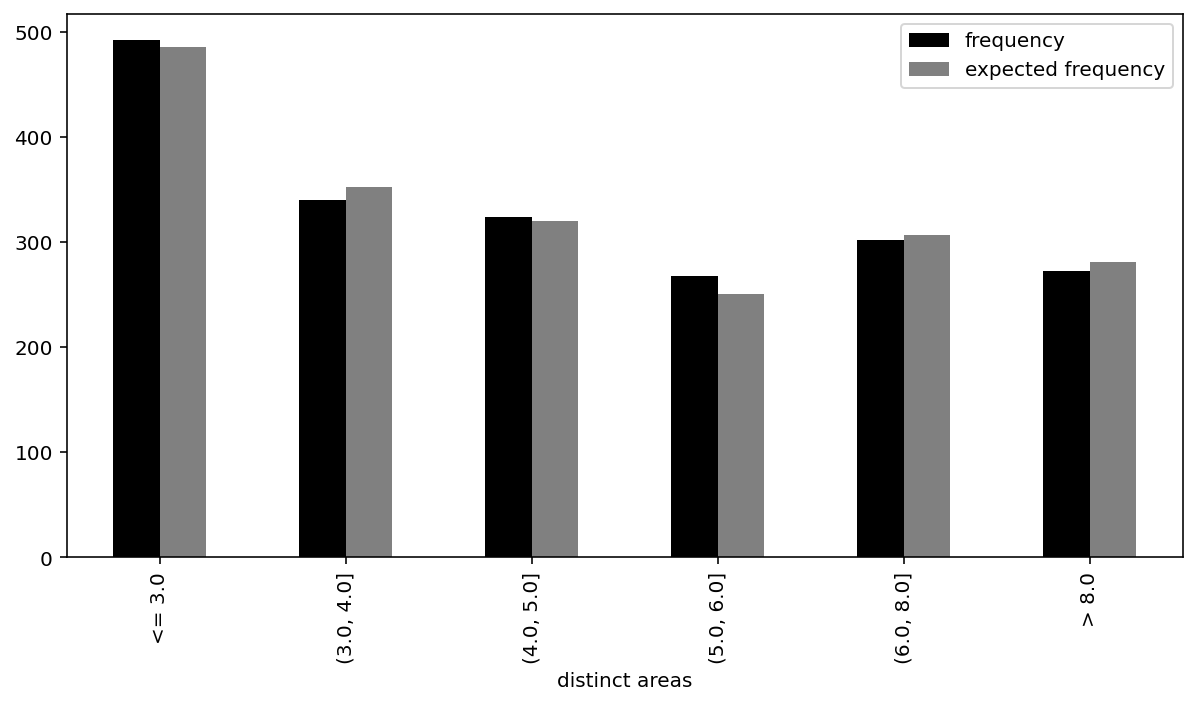

In [1248]:
# sanity check: now do chi-squared test for real sample observations vs expected observations
# Bin the sample data with chosen bins
distinct_places_counts_per_user_real_sample = get_locations_per_user(real_trajectories_sample)

real_sample_binned_series = pd.cut(distinct_places_counts_per_user_real_sample, bins=bins, labels=False, include_lowest=True)
real_sample_binned_map = get_binned_series_to_binned_map(real_sample_binned_series, bins)
df = plot_distinct_places_category_to_frequency(real_sample_binned_map, expected_category_to_frequency_map)
df.head()

In [1249]:
from scipy.stats import chisquare
chisq, p = chisquare(list(real_sample_binned_map.values()),
               f_exp=list(expected_category_to_frequency_map.values()))

print('The chi-squared test statistic: %s\np-value: %s' % (chisq, p))

The chi-squared test statistic: 2.0620762451973573
p-value: 0.8404906622555846


chi-squared test for generated sample

The chi-squared test statistic: 4.895595406310967
p-value: 0.42875441676663806


frequency  expected frequency
distinct areas                               
<= 3.0                470          486.346018
(3.0, 4.0]            342          352.889359
(4.0, 5.0]            313          320.560254
(5.0, 6.0]            243          251.321353
(6.0, 8.0]            322          307.170543

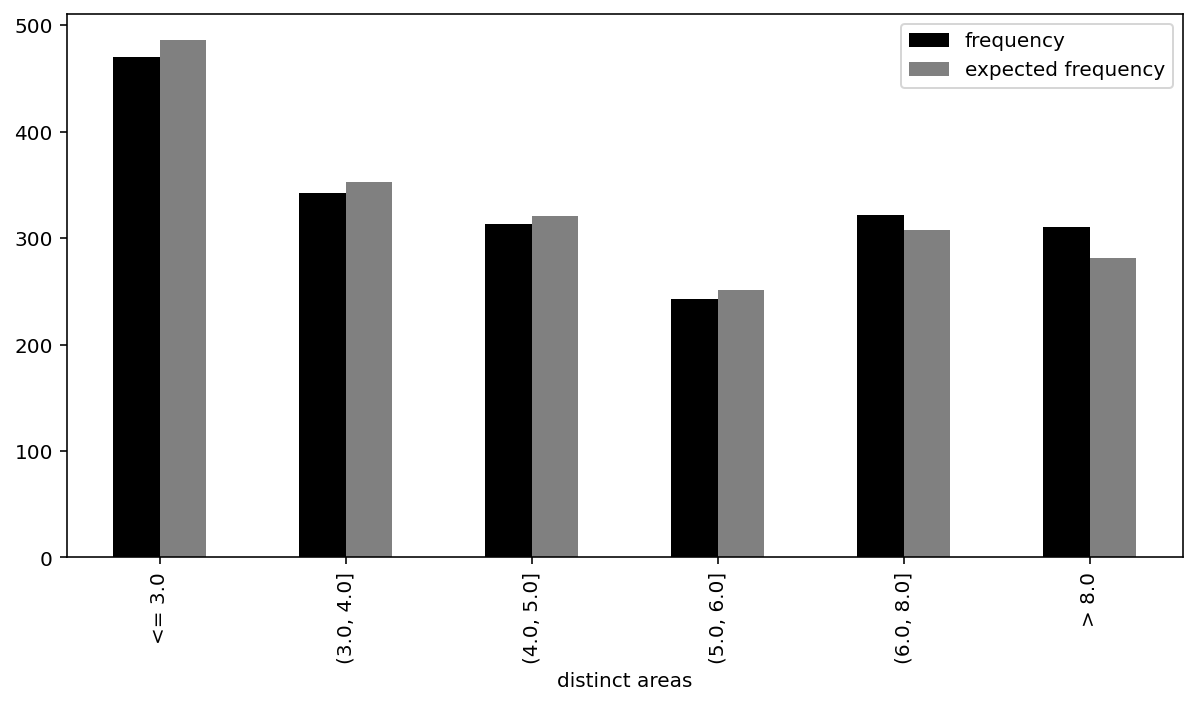

In [1251]:
distinct_places_counts_per_user_generated_sample = get_locations_per_user(generated_trajectories_sample)

generated_sample_binned_series = pd.cut(distinct_places_counts_per_user_generated_sample, bins=bins, labels=False, include_lowest=True)
generated_sample_binned_map = get_binned_series_to_binned_map(generated_sample_binned_series, bins)

chisq, p = chisquare(list(generated_sample_binned_map.values()),
               f_exp=list(expected_category_to_frequency_map.values()))

print('The chi-squared test statistic: %s\np-value: %s' % (chisq, p))

df = plot_distinct_places_category_to_frequency(generated_sample_binned_map, expected_category_to_frequency_map)
df.head()